In [16]:
import pickle
import math
import numpy as np
import logging
import itertools
import matplotlib.pyplot as plt
from collections import defaultdict

from scipy.optimize import minimize
from scipy.spatial import ConvexHull, convex_hull_plot_2d

from pymatgen.ext.matproj import MPRester
from pymatgen.core import Element, Composition
from pymatgen.analysis.phase_diagram import GrandPotentialPhaseDiagram, PhaseDiagram, PDPlotter, PDEntry
from pymatgen.util.plotting import pretty_plot
from pymatgen.core.periodic_table import Element
from pymatgen.core.composition import Composition
from pymatgen.core.ion import Ion
from pymatgen.entries.computed_entries import ComputedEntry
from pymatgen.analysis.reaction_calculator import Reaction, ReactionError
from pymatgen.analysis.phase_diagram import PhaseDiagram, PDEntry
from pymatgen.analysis.pourbaix_diagram import PourbaixEntry, IonEntry, PourbaixDiagram, PourbaixPlotter
from pymatgen.entries.compatibility import MaterialsProjectAqueousCompatibility

from matminer.featurizers.site import CrystalNNFingerprint
from matminer.featurizers.structure import SiteStatsFingerprint


# Initialize the MP Rester
mpr = MPRester('pn8XdbGhMrv90STu')
ssf = SiteStatsFingerprint(
    CrystalNNFingerprint.from_preset('ops', distance_cutoffs=None, x_diff_weight=0),
    stats=('mean', 'std_dev', 'minimum', 'maximum'))


import warnings
warnings.filterwarnings('ignore')


import pickle
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from scipy.optimize import minimize
from scipy.spatial import ConvexHull, convex_hull_plot_2d

from pymatgen.ext.matproj import MPRester
from pymatgen.core import Element, Composition
from pymatgen.analysis.phase_diagram import GrandPotentialPhaseDiagram, PhaseDiagram, PDPlotter, PDEntry

from matminer.featurizers.site import CrystalNNFingerprint
from matminer.featurizers.structure import SiteStatsFingerprint

# Initialize the MP Rester
mpr = MPRester('pn8XdbGhMrv90STu')
ssf = SiteStatsFingerprint(
    CrystalNNFingerprint.from_preset('ops', distance_cutoffs=None, x_diff_weight=0),
    stats=('mean', 'std_dev', 'minimum', 'maximum'))


In [2]:
unary_data = pickle.load(open("unary_oxide_data_self_calc.p", "rb"))
binary_oxide_data = pickle.load(open("binary_oxide_data_form_ene_self_calc.p", "rb"))
ele2gs = pickle.load(open("ele2gs.p", "rb"))

u_correction = {
    "V": -1.700,
    "Cr": -1.999,
    "Mn": -1.668,
    "Fe": -2.256,
    "Co": -1.638,
    "Ni": -2.541,
    "Mo": -3.202,
    "W": -4.438,
}

# define your reference materials project ids you want to compare, for now taking rutile if exists, or lowest
# octahedral MO2.
ele2mp = {
    'Mo': 'mp-510536',
    'W': 'mp-19372',
    'Nb': 'mp-557057', # not rutile, 0.03 eV/atom lower
    'Ni': 'mp-35925', # layered Ni
    'V': 'mp-19094',
    'Ir': 'mp-2723',
    'Ru': 'mp-825',
    'Cr': 'mp-19177',
    'Fe': 'mp-1205429', # this is lowest FeO2, suspect rutile in MP is wrong magmoms
    'Mn': 'mp-19395', # many morphologiesi close to eachother, rutile 0.03 eV/atom
    'Co': 'mvc-14149', # layered Co mp-1272749 octahedral
    'Pb': 'mp-20725',
    'Sb': 'mp-230',#mp-230 omst stable, # mvc-5581 was chosen since it is 0.17 eV/atom more unstable than the most stable MP SbO2 (this is chosen because OQMD has this difference for its rutile SbO2)
    'Sn': 'mp-856',
    'Bi': 'mp-557993',#mp-557993 not rutile
    'Ti': 'mp-390',
    'Ta': 'mp-510', #mp-20994 rutile, 0.02 eV/atom higher
    'In': 'mp-1181008',
    'Pt': 'mp-1077716',
    'Pd': 'mp-1018886',
    'Re': 'mp-12875',
    'Os': 'mp-996',
    'Ge': 'mp-2633',# not rutile
    'Tc': 'mp-1205302',
    'Rh': 'mp-725',
    'Cu': 'mp-25378',
    'Te': 'mp-2125', # mp-2237 rutile, 0.25 eV/atom higher, icsd
    'Li': 'mp-1018789',
    'Na': 'mp-1901',
    'Ca': 'mp-634859',
    'K': 'mp-1866',
    'Rb': 'mp-12105',
    'Cs': 'mp-1441',
    'Mg': 'mp-2589',
    'Y': 'mp-1206610',
    'Sc': 'mp-1179114',
    'Ba': 'mp-1105',
    'Zn': 'mp-1094003',
    'La': 'mp-1206559',
    'Ce': 'mp-20194',
    'Pr': 'mp-1302',
    'Nd': 'mp-31049',
    'Sm': 'mp-1077235',
    'Eu': 'mp-1018700',
    'Tb': 'mp-2458',
    'Dy': 'mp-1206731',
    #'Ho': 'mp-1206243',
    'Er': 'mp-1206338',
    'Tm': 'mp-1206313',
    'Yb': 'mp-1178667'
}


d2metals = {
    '3': ['Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu'],
    '4': ['Nb', 'Mo', 'Ru', 'Pd', ],
    '5': ['Ta', 'W', 'Re', 'Os', 'Ir', 'Pt']
}

ele2col = {
    "Ti": "#808080",
    "V": "#ffcccb",
    "Cr": "k",
    "Mn": "#9b870c",
    "Fe": "r",
    "Co": "b",
    "Cu": "#FFFF00",
    "Nb": "cyan",
    "Mo": "#FFA500",
    "Sn": "k",
    "W": "fuchsia",
    "Ge": "g",
    "Rh": "#FFA500",
    "Sb": "#66ff00",
    "Te": "y",
    "Ir": "b",
    "Ni": "#66FF00",
    "Bi": "b",
    'Sr': '#A020F0',
    'Ru': 'y',
    'Ta': '#8b0000',
    'In': '#a9a9a9',
    'Pt': 'gray',
    'Pd': 'orange',
    'Re': 'purple',
    'Os': 'brown',
    'Tc': 'indigo',
    'Pb': '#4169e1',
    'Rh': 'cyan',
    'Li': 'cyan',
    'Mg': 'orange',
    'K': 'purple',
    'Na': 'g',
    "La": "#808080",
    "Ce": "#ffcccb",
    "Pr": "k",
    "Nd": "#9b870c",
    "Pm": "r",
    "Sm": "b",
    "Eu": "#FFFF00",
    "Gd": "cyan",
    "Tb": "#FFA500",
    "Dy": "k",
    "Ho": "fuchsia",
    "Er": "g",
    "Tm": "#FFA500",
#    "Yb": "#66ff00",
    "Lu": "y",
} 

potential_hosts = ['Ag', 'Ge', 'Bi', 'Co', 'Ir', 'Nb', 'Pb', 'Pd', 'Pt', 'Rh',
                  'Ru', 'Sb', 'Si', 'Sn', 'Ta', 'Te', 'Ti', 'Tl', 'W']
#potential_hosts = [ 'Co', 'Ir', 'Nb','Sb', 'W']

abundant_hosts = ['Bi', 'Co', 'Nb', 'Pb', 'Sb', 'Si', 'Sn', 'Ti', 'Tl', 'W']
easy2deposit = ['Bi', 'Pb', 'Sn', 'W']

templates = ['Pb', 'Sn', 'Sb', 'Bi', 'Ta', 'Ti', 'W', 'Nb', 'Mo', 'Ir', 'Ru']
cr_mixers = ['Nb', 'V', 'Mo', 'Ir', 'Mn', 'W']
#templates = [ 'Ta']
mn_mixers = ['Ti', 'Cr', 'V', 'Fe', 'Sn']
fe_mixers = ['Mn', 'W']

In [66]:
ele2mp_3

defaultdict(None,
            {'Ti': None,
             'V': 'mp-25279',
             'Cr': 'mp-1244554',
             'Mn': None,
             'Fe': None,
             'Co': None,
             'Cu': None,
             'Nb': 'mp-581967',
             'Mo': 'mvc-4607',
             'Sn': None,
             'W': 'mvc-4845',
             'Ge': None,
             'Rh': None,
             'Sb': 'mp-1705',
             'Te': 'mp-12177',
             'Ir': None,
             'Ni': 'mp-1094139',
             'Bi': 'mvc-8471',
             'Sr': None,
             'Ru': None,
             'Ta': 'mp-1539317',
             'In': None,
             'Pt': None,
             'Pd': None,
             'Re': None,
             'Os': None,
             'Tc': None,
             'Pb': None,
             'Li': None,
             'Mg': None,
             'K': None,
             'Na': None,
             'La': None,
             'Ce': None,
             'Pr': None,
             'Nd': 'mp-985608',
            

In [126]:
def get_lowest_ene_id(element, oxidation_state):
    """
    Return the materials project id that is the lowest formation energy
    at that oxidation_state, related to relative mol. fraction of O
    """
    ref_formation_energy = 0
    ref_id = None
    for idx, struct in enumerate(unary_data[element]['structures']):
        m_coordinations, ox_state, o_o_coords, o_m_coords, o_pc = structure_inspection(struct)
        if ox_state==oxidation_state:
            formation_energy = unary_data[element]['formation_energies'][idx]
            if formation_energy<ref_formation_energy:
                ref_id = unary_data[element]['mp_ids'][idx]
                ref_formation_energy = formation_energy
    # if we return None
    # there isn't a value for this in materials project, need to invent
    # one later on, and label this as None, to be handled in get_ref_data
    return ref_id

def get_ref_data(element, reference_oxide_id, desired_ox=None):
    found = False
    
    if reference_oxide_id is None:
        # need to retrieve made up formation energy
        print("Making synthetic formation energy, since MP doesn't have data for {} in ox state: {}".format(element, desired_ox))
        ene_dict, val = get_ox2lowest_no_reference_(element, desired_ox)
        return val, _, _

    for idx, id_ in enumerate(unary_data[element]['mp_ids']):
        if id_==reference_oxide_id:
            found = True
            ref_fingerprint = unary_data[element]['fingerprints'][idx]
            ref_struct = unary_data[element]['structures'][idx]
            ref_ene = unary_data[element]['energies'][idx]
            ref_form_ene = unary_data[element]['formation_energies'][idx]
            if id_=='mvc-852':
                # too far off hull, need to bring it down.
                hull = mpr.query("mvc-852", properties=['e_above_hull'])[0]['e_above_hull']
                ref_form_ene -= hull
                ref_form_ene += 0.1
            return ref_form_ene, ref_fingerprint, ref_struct
    
    print("You probably mis-named ones of the reference oxides.")
    return 



def add_ox(energy_dict, desired_ox_state):
    """
    Makes a synthetic entry in the dictionary for a given oxidation state if it doesn't exist
    """
    ox_states = list(energy_dict.keys())
    ox_states_ = ox_states.copy()
    assert desired_ox_state not in ox_states
    
    ox_states_.append(desired_ox_state)
    # we need two points to project between or from to the desired oxidation state
    # if the desired points has examples either side of it, we handle that here
    minused = np.array(ox_states)-desired_ox_state
    if min(minused)<0 and max(minused)>0:
        # there are points with higher/lower ox states than the desired ox
        # initialise dummy check values
        closest_higher_ox = 10
        closest_lower_ox = -10
        for val in minused:
            if val<0 and val>closest_lower_ox:
                closest_lower_ox = val
            elif val>0 and val<closest_higher_ox:
                closest_higher_ox = val
        closest_lower_ox+=desired_ox_state
        closest_higher_ox+=desired_ox_state
        # need to ensure the key is right
        if closest_lower_ox.is_integer():
            form_ene1 = energy_dict[closest_lower_ox]
        else:
            form_ene1 = energy_dict[round(closest_lower_ox, 3)]
        if float(closest_higher_ox).is_integer():
            form_ene2 = energy_dict[closest_higher_ox]
        else:
            form_ene2 = energy_dict[round(closest_higher_ox, 3)]
        # get weighted average
        adapted = form_ene1*(abs(closest_higher_ox)/(abs(closest_lower_ox)+abs(float(closest_higher_ox))))+form_ene2*(abs(closest_lower_ox)/(abs(closest_lower_ox)+abs(float(closest_higher_ox))))
        return adapted
    
    elif min(minused)<0:
        # trying to get a value for a point which has no info at higher oxidation states        
        sorted_index_array = np.argsort(np.array(ox_states))
        sorted_array = np.array(ox_states)[sorted_index_array]
        # take 2 largest values
        rslt = sorted_array[-2:]
        lower_ox = min(rslt[0], rslt[1])
        higher_ox = max(rslt[0], rslt[1])
        l_ox_ene = energy_dict[lower_ox]
        h_ox_ene = energy_dict[higher_ox]
        # use eq. of line
        m = (h_ox_ene-l_ox_ene)/(higher_ox-lower_ox)
        c = h_ox_ene-m*higher_ox
        y_new = m*desired_ox_state+c
        return y_new

    elif max(minused)>0:
        # trying to get a value for a point which has no info at lower oxidation states        
        sorted_index_array = np.argsort(np.array(ox_states))
        sorted_array = np.array(ox_states)[sorted_index_array]
        # take min value
        rslt = sorted_array[0]
        lowest_energy = energy_dict[rslt]
        # use eq. of line
        m = (lowest_energy)/(rslt)
        c = lowest_energy
        y_new = m*(desired_ox_state-rslt)+c
        return y_new

    
    
def get_ox2lowest_no_reference_(reference_element_, ref_oxidation_state):
    """
    Returns a dictionary for a given element with keys for ox state and 
    values for the lowest formation energy at ox state.
    Args:
    reference_element_: The element to iterate over, passed as a string
    """
    ox2lowest = defaultdict(list)

    for idx, struct in enumerate(unary_data[reference_element_]['structures']):

        m_coordinations, ox_state, o_o_coords, o_m_coords, o_pc = structure_inspection(struct)
        formation_energy = unary_data[reference_element_]['formation_energies'][idx]
        
        if ox_state not in ox2lowest.keys():
            ox2lowest[ox_state] = formation_energy
        elif ox_state in ox2lowest.keys() and formation_energy<ox2lowest[ox_state]:
            ox2lowest[ox_state] = formation_energy
    if ref_oxidation_state not in ox2lowest.keys():
        
        synthetic_ref_form = add_ox(ox2lowest, ref_oxidation_state)
        ox2lowest[ref_oxidation_state] = synthetic_ref_form
        
    return ox2lowest, ox2lowest[ref_oxidation_state]


def uncorr_ene_from_formation_energy(formation_energy_correction, ele1, ele2, ele1_conc, o_conc,):
    """
    Return the synthetically calculated uncorrected DFT energy given a formation energy correction with
    respect to the reference oxides.
    Args:
    formation_energy_correction: The value below the weighted average of ele1/ele2 oxides, float.
    ele1: One of the mixed elements passed as a string.
    ele2: The other element, passed as a string.
    ele1_conc: The concentration of ele1, float between 0 and 1. eg. one-to-one mixture would have ele1_conc=0.5.
    o_conc: The oxygen concentration, float between 0 and 1. Eg. for MO2, o_conc=2/3.
    """
    o_energy = -4.948
    o_correction = -0.687
    ele1_ene, ele1_fingerprint, ele1_struct = get_ref_data(ele1, ele2mp_3[ele1], desired_ox=round((o_conc*2/(1-o_conc)), 3))
    ele2_ene, ele2_fingerprint, ele2_struct = get_ref_data(ele2, ele2mp_3[ele2], desired_ox=round((o_conc*2/(1-o_conc)), 3))
    #print(ele1_ene)
    if ele2mp_3[ele1] is None:
        # need to make energy per atom from hypothetical formation energy
        corr_ele1_ene = ele2_ene+o_energy*o_conc+ele2gs[ele1]*(1-o_conc)
    else:
        corr_ele1_ene = mpr.get_entries(ele2mp_3[ele1])[0].energy_per_atom
    if ele2mp_3[ele2] is None:
        # need to make energy per atom from hypothetical formation energy
        corr_ele2_ene = ele2_ene+o_energy*o_conc+ele2gs[ele2]*(1-o_conc)
    else:
        corr_ele2_ene = mpr.get_entries(ele2mp_3[ele2])[0].energy_per_atom
    ele1_ene = corr_ele1_ene-o_conc*o_energy-(1-o_conc)*ele2gs[ele1]
    ele2_ene = corr_ele2_ene-o_conc*o_energy-(1-o_conc)*ele2gs[ele2]

    total_form_ene = ele1_ene*ele1_conc+ele2_ene*(1-ele1_conc)+formation_energy_correction
    end_member_ene = (1-o_conc)*(ele1_conc*ele2gs[ele1]+(1-ele1_conc)*ele2gs[ele2])+(o_conc)*(o_energy)
    corrections = o_conc*(o_correction)
    # now get the corrections that would be applied per atom
    if ele1 in u_correction.keys():
        corrections += (1-o_conc)*(ele1_conc*u_correction[ele1])
    if ele2 in u_correction.keys():
        corrections += (1-o_conc)*((1-ele1_conc)*u_correction[ele2])
    # by definition formation energy = (mixed system energy) - (end member energy), here we just manipulate
    # that equation and remove the MP corrections.
    uncorr_energy = total_form_ene+end_member_ene

    return uncorr_energy 


def make_synthetic_mp(energy_correction, ele1, ele2, ele1_conc, o_conc):
    """
    Make a PourbaixDiagram, PDEntry object to be passed to the plotter
    Args:
    energy_correction: Difference in weighted formation energy, float
    ele1, ele2: The chemical symbol of the non-oxygen elements in the oxide, str
    ele1_conc: The concentration of ele1, varies from 0 to 1.
    o_conc: The amount of oxygen in the made up entry, eg. for MO2, would be 2/3
    """
    name = "{}{}{}{}O{}".format(ele1, (1-o_conc)*(ele1_conc), ele2, (1-o_conc)*(1-ele1_conc), o_conc)
    composition = Composition(name)
    #label = "{}{:.2f}{}{:.2f}O{:.2f}".format(ele1, (1)*(1-o_conc)*(ele1_conc), ele2, (1)*(1-o_conc)*(1-ele1_conc), (1)*o_conc)
    label = "{}{:.2f}{}{:.2f}O{:.2f}".format(ele1, (3.5)*(1-o_conc)*(ele1_conc), ele2, (3.5)*(1-o_conc)*(1-ele1_conc), (3.5)*o_conc)
    print(label)
    energy = uncorr_ene_from_formation_energy(energy_correction, ele1, ele2, ele1_conc, o_conc)
    entry = PDEntry(composition, energy, name=label)
    return entry, label


def get_hull_energy(min_mu_o, max_mu_o, entries):
    list_mu_Os = np.linspace(min_mu_o, max_mu_o, 10)
    data = []
    hull = []
    for mu_Os in list_mu_Os:
        open_elements_specific = {Element("O"):mu_Os}
        gcpd = GrandPotentialPhaseDiagram(entries, open_elements_specific)
        l = [gcpd.get_form_energy_per_atom(e) for e in gcpd.all_entries]
        h = [gcpd.get_e_above_hull(e) for e in gcpd.all_entries]
        data.append(l)
        hull.append(h)
    hull = np.array(hull)
    data = np.array(data)
    return hull, data, gcpd, list_mu_Os

def load_data(ele1, ele2):
    entries = []
    labels = []
    entries_1 = mpr.get_entries('{}-{}-O'.format(ele1, ele2))+mpr.get_entries('{}-O'.format(ele1))+mpr.get_entries('{}-O'.format(ele2))
    for entry in entries_1:
        if 'H' in entry.name:
            continue
        entries.append(entry)
        labels.append(entry.name)
    return entries, labels


def structure_inspection(structure):
    """
    Need to know the coordination and other structural data for a given oxide
    """
    num_o_sites = 0 
    m_coordinations = []
    o_o_coordinations = []
    o_m_coordinations = []
    for site in structure.sites:
        if str(site.specie)=='O':
            num_o_sites += 1
            nn_info = structure.get_neighbors(site, 2.5)
            o_coord = 0
            o_m_coord = 0
            for nn in nn_info:
                #print(str(nn.specie))
                if str(nn.specie)=="O" and nn.nn_distance<1.5:
                    o_coord+=1
                elif str(nn.specie)!="O":
                    o_m_coord+=1
                #assert str(nn.specie)=='O'
            o_o_coordinations.append(o_coord)
            o_m_coordinations.append(o_m_coord)
        else:
            # check nearest neighbours for coordination
            nn_info = structure.get_neighbors(site, 2.5)
            m_coord = 0
            for nn in nn_info:
                #print(str(nn.specie))
                if str(nn.specie)=="O":
                    m_coord+=1
                #assert str(nn.specie)=='O'
            m_coordinations.append(m_coord)
    o_percent = num_o_sites/len(structure.sites)
    ox_state = round((o_percent*2/(1-o_percent)), 3)
    return m_coordinations, ox_state, o_o_coordinations, o_m_coordinations, round(o_percent, 3)


def plot_coords(reference_element_):
    struct_differences = []
    mp_ids = []
    ox2lowest = {}
    ox2data = defaultdict(list)

    for idx, struct in enumerate(unary_data[reference_element_]['structures']):
        m_coordinations, ox_state, o_o_coords, o_m_coords, o_pc = structure_inspection(struct)
        mpid = unary_data[reference_element_]['mp_ids'][idx]
        mp_ids.append(mpid)
        query = mpr.get_entry_by_material_id(mpid, property_data=['formation_energy_per_atom',])
        formation_energy = query.data['formation_energy_per_atom']
        if set(list(m_coordinations))=={6}:
            plt.plot(ox_state, formation_energy, 'bo', alpha=0.1)
        elif set(list(m_coordinations))=={4}:
            plt.plot(ox_state, formation_energy, 'ro', alpha=0.9)
            #print(mpid)
        elif set(sorted(list(m_coordinations)))=={5}:
            plt.plot(ox_state, formation_energy, 'go', alpha=0.9)
        #else:
        #    plt.plot(ox_state, formation_energy, 'yo', alpha=0.7)

    plt.show()

def get_conc_in_binary(structure, element):
    element_count = 0
    other_element_count = 0
    for site in structure.sites:
        if str(site.specie)==element:
            element_count+=1
        elif str(site.specie)=='O':
            continue
        else:
            other_element_count+=1
    return element_count/(element_count+other_element_count)


def get_quadratic(lower_hull_data, max_x=4):
    """
    Iterate over the hull dictionary to get x and y to fit 2nd order polynomial through those points
    """
    xs = []
    ys = []
    for ox in lower_hull_data:
        xs.append(ox)
        ys.append(lower_hull_data[ox])
    try:
        coeffs_ = np.polyfit(xs, ys, 2)
    except TypeError:
        return None
    x = np.linspace(0, max_x, 100)
    y = coeffs_[0]*x**2 + coeffs_[1]*x + coeffs_[2]
    plt.plot(x, y)
    plt.show()
    
    return coeffs_


def check_if_upper(upper_hull_points, hull_simplex):
    """
    Helper function so that for loop in get_lower_hull_points function can be skipped when
    we see a point that is on the upper half of the hull.
    """
    for index in upper_hull_points:
        if index in hull_simplex:
            return True
    return False
    
def get_lower_hull_points(hull_, pairs_, plotting=True):
    """
    Function to remove points on the upper half of the hull, these are unstable and ignored,  
    to handle the fact that scipy gets the entire hull not just the low energy points we want.
    Args: 
    hull_: Returned value from scipy's ConvexHull, where the x-axis is oxidation state and the
    y-axis is formation energy.
    pairs_: The values themselves, pairs_[i, 0] gives the ith oxidation state
    pairs_[i, 1] the ith formation energy.
    plotting: Whether to plot the points to be fitted through
    """
    points_on_upper_hull = set()
    for vertex_index, vertex in enumerate(hull_.vertices):
        # check if on upper or lower half of hull
        for simplex in hull_.simplices:
            low_ox = min(pairs_[simplex, 0])
            low_ox_ene = pairs_[simplex, 1][np.argmin(pairs_[simplex, 0])]
            high_ox = max(pairs_[simplex, 0])
            high_ox_ene = pairs_[simplex, 1][np.argmax(pairs_[simplex, 0])]
            difference = high_ox - low_ox
            vertex_ox = pairs_[vertex, 0]
            vertex_diff = vertex_ox-low_ox

            difference_ratio = vertex_diff/difference
            value_on_hull = high_ox_ene*(1-difference_ratio)+low_ox_ene*(difference_ratio)
            if low_ox<pairs_[vertex,0]<high_ox and value_on_hull<pairs_[vertex,1]:
                # if this is true it means the oxidation state is between two other oxidation states on the hull,
                # and lies above the weighted average on the line connecting those oxidation states
                points_on_upper_hull.add(hull_.vertices[vertex_index])
        
    hullox2ene = defaultdict()
    for simplex in hull_.simplices:
        if check_if_upper(points_on_upper_hull, simplex):
            continue
        hullox2ene[pairs_[simplex, 0][0]] = pairs_[simplex, 1][0]
        hullox2ene[pairs_[simplex, 0][1]] = pairs_[simplex, 1][1] 
        if plotting:
            
            plt.plot(pairs_[simplex, 0], pairs_[simplex, 1], 'k--')
            plt.plot(pairs_[simplex, 0][0], pairs_[simplex, 1][0], 'ro')
            plt.plot(pairs_[simplex, 0][1], pairs_[simplex, 1][1], 'ro')

    return hullox2ene

def get_lower_hull(low_ox_state_data, ref_oxidation_state, ref_formation_ene, reference_element_, oxidising=True):
    """
    Returns the lower hull through the desired points along the phase diagram.
    low_ox_state_data: Dictionary returned from the result of get_ox2lowest
    ref_formation_ene: Formation energy in eV/atom of refernece state.
    ref_oxidation_state: The reference oxidation state from which we oxidise/reduce
    oxidising: Set to True if we want the hull oxidised, False if we want it reduced
    """
    pairs = [[0,0]]
    if oxidising:
        for ox in low_ox_state_data:
            #print(ox)
#             if ox>6 and reference_element_ not in ['Ru', 'Mo', 'W', 'Re', 'Sb'] and ref_oxidation_state==4:
#                 plt.plot(ox-ref_oxidation_state, low_ox_state_data[ox][0]-ref_formation_ene, 'bo')
#                 continue
            #if reference_element_ in ['Sb',] and ox==6:# or (reference_element_=='Mo' and ox==5):
            #    plt.plot(ox-ref_oxidation_state, low_ox_state_data[ox][0]-ref_formation_ene, 'bo')
                # need Sb minima at Sb2O5
            #    continue
            if reference_element_=='W' and not ox.is_integer() and ref_oxidation_state==4:
                # need to fit through WO3,this allows that
                plt.plot(ox-ref_oxidation_state, low_ox_state_data[ox][0]-ref_formation_ene, 'bo')
                print(ox)
                #pairs.append((ox-ref_oxidation_state, low_ox_state_data[ox][0]-ref_formation_ene ))
                continue
            if reference_element_=='Ta' and ox>10 and ref_oxidation_state==3:
                plt.plot(ref_oxidation_state-ox, low_ox_state_data[ox][0]-ref_formation_ene, 'bo')
                continue
                
            if reference_element_=='Nb' and ox==4 and ref_oxidation_state==3:
                plt.plot(ref_oxidation_state-ox, low_ox_state_data[ox][0]-ref_formation_ene, 'bo')
                continue
            if reference_element_=='Te' and ox==4.5 and ref_oxidation_state==4:
                plt.plot(ox-ref_oxidation_state, low_ox_state_data[ox][0]-ref_formation_ene, 'bo')
                continue
                
            if reference_element_=='Mo' and (4<ox<6 or ox>6) and ref_oxidation_state==3:
                plt.plot(ox-ref_oxidation_state, low_ox_state_data[ox][0]-ref_formation_ene, 'bo')
                continue

            if reference_element_=='Fe' and ox!=6.5 and ref_oxidation_state==3.0:
                # need to fit through WO3,this allows that
                plt.plot(ox-ref_oxidation_state, low_ox_state_data[ox][0]-ref_formation_ene, 'bo')
                print(ox)
                #pairs.append((ox-ref_oxidation_state, low_ox_state_data[ox][0]-ref_formation_ene ))
                continue

            else:
                pairs.append((ox-ref_oxidation_state,low_ox_state_data[ox][0]-ref_formation_ene ))
    else:
        for ox in low_ox_state_data:
            #print(ox)
            if reference_element_=='Ni' and 2.5<ox<3 and ref_oxidation_state==4:
                plt.plot(ref_oxidation_state-ox, low_ox_state_data[ox][0]-ref_formation_ene, 'bo')
                continue
                
            if reference_element_=='Li' and ref_oxidation_state==3:
                pairs.append((4, 0.))
                

            #elif reference_element_=='Fe' and not ox.is_integer():
            #    plt.plot(ref_oxidation_state-ox, low_ox_state_data[ox][0]-ref_formation_ene, 'bo')
            #    continue
            elif reference_element_=='Cr' and ox==2 and ref_oxidation_state==4:
                plt.plot(ref_oxidation_state-ox, low_ox_state_data[ox][0]-ref_formation_ene, 'bo')
                continue
            elif reference_element_=='Fe' and ox not in [3, 5] and ref_oxidation_state==6:
                plt.plot(ref_oxidation_state-ox, low_ox_state_data[ox][0]-ref_formation_ene, 'bo')
                continue

            if reference_element_ in ['Ni', 'Ca', 'Mg', 'Pt', 'Pd'] and ref_oxidation_state==4:
                # push to have minimum close to MO
                pairs.append((4, 0.))
            if reference_element_ in ['Li',] and ref_oxidation_state==4:
                # push to have minimum close to M2O
                pairs.append((6, 0.))
            if reference_element_ in ['Sm', 'Na'] and ref_oxidation_state==4 and ox==2:
                plt.plot(ref_oxidation_state-ox, low_ox_state_data[ox][0]-ref_formation_ene, 'bo')
                continue
            if reference_element_=='Pb' and ref_oxidation_state==4 and ox==2:
                plt.plot(ref_oxidation_state-ox, low_ox_state_data[ox][0]-ref_formation_ene, 'bo')
                continue
            if reference_element_=='Rb' and ref_oxidation_state==4 and ox==1:
                plt.plot(ref_oxidation_state-ox, low_ox_state_data[ox][0]-ref_formation_ene, 'bo')
                continue
            if reference_element_=='W' and ref_oxidation_state==6 and 2<=ox<6:
                plt.plot(ref_oxidation_state-ox, low_ox_state_data[ox][0]-ref_formation_ene, 'bo')
                continue

            pairs.append((ref_oxidation_state-ox,low_ox_state_data[ox][0]-ref_formation_ene ))        
            
    if len(pairs)==2 or (reference_element_=='W' and oxidising):
        # need to add oxygen end member data
        print("WARNING! Adding an end member so can perform fit, try gather more data for this element.")
        pairs.append((ref_oxidation_state, -ref_formation_ene))
    
    pairs = np.array(pairs)

    try:
        hull = ConvexHull(pairs)
    except Exception as e:
        print(e)
        print("{}  needs to be done differently.".format(reference_element_))
        if oxidising:
            plt.title("{} oxidising, not enough data".format(reference_element_))
        else:
            plt.title("{} reducing, not enough data".format(reference_element_))
        plt.show()
        return None
    
    if oxidising:
        plt.title("{} oxidising".format(reference_element_))
    else:
        plt.title("{} reducing".format(reference_element_))
    #print(hull)
    #print(pairs)
    resultant_hull = get_lower_hull_points(hull, pairs)

    return resultant_hull


def get_lower_hull_symmetric(low_ox_state_data, ref_oxidation_state, ref_formation_ene, reference_element_, oxidising=True):
    """
    Returns the lower hull through the desired points along the phase diagram, the difference here 
    is that if there is a structure lower in energy than the reference, we make a symmetric function
    about that minimum, makes it easier to fit things without hard coding a result by eye.
    
    low_ox_state_data: Dictionary returned from the result of get_ox2lowest
    ref_formation_ene: Formation energy in eV/atom of refernece state.
    ref_oxidation_state: The reference oxidation state from which we oxidise/reduce
    oxidising: Set to True if we want the hull oxidised, False if we want it reduced
    """
    pairs = [[0,0]]
    
    going_down = False
    min_energy = 100
    min_ox = 100
    if oxidising:
        for ox in low_ox_state_data:
            if low_ox_state_data[ox][0]<ref_formation_ene:
                # at least one more oxidised entry is lower in energy, will be symmetric about the minimum
                going_down = True
                if low_ox_state_data[ox][0]<min_energy:
                    min_energy = low_ox_state_data[ox][0]
                    min_ox = ox
        if going_down:
            pairs.append((min_ox-ref_oxidation_state, min_energy-ref_formation_ene))
            pairs.append(((min_ox-ref_oxidation_state)*2, 0))
    else:
        for ox in low_ox_state_data:
            if low_ox_state_data[ox][0]<ref_formation_ene:
                # at least one more oxidised entry is lower in energy, will be symmetric about the minimum
                going_down = True
                if low_ox_state_data[ox][0]<min_energy:
                    min_energy = low_ox_state_data[ox][0]
                    min_ox = ox
        if going_down:
            pairs.append((ref_oxidation_state-min_ox, min_energy-ref_formation_ene))
            pairs.append(((ref_oxidation_state-min_ox)*2, 0))

    if oxidising and not going_down:
        for ox in low_ox_state_data:
            pairs.append((ox-ref_oxidation_state,low_ox_state_data[ox][0]-ref_formation_ene ))
    elif not going_down:
        for ox in low_ox_state_data:
            pairs.append((ref_oxidation_state-ox,low_ox_state_data[ox][0]-ref_formation_ene ))        
            
    if len(pairs)==2:
        # need to add oxygen end member data
        print("WARNING! Adding an end member so can perform fit, try gather more data for this element.")
        pairs.append((ref_oxidation_state, -ref_formation_ene))
    
    pairs = np.array(pairs)

    try:
        hull = ConvexHull(pairs)
    except Exception as e:
        print(e)
        print("{}  needs to be done differently.".format(reference_element_))
        if oxidising:
            plt.title("{} oxidising, not enough data".format(reference_element_))
        else:
            plt.title("{} reducing, not enough data".format(reference_element_))
        plt.show()
        return None
    
    if oxidising:
        plt.title("{} oxidising".format(reference_element_))
    else:
        plt.title("{} reducing".format(reference_element_))
    #print(hull)
    #print(pairs)
    resultant_hull = get_lower_hull_points(hull, pairs)

    return resultant_hull


def get_ox2lowest(reference_element_, reference_mpid, ref_oxidation_state, oxidising=True):
    """
    Returns a dictionary for a given element with keys for oxidation states and 
    values for the lowest formation energy at that oxidation state
    Args:
    reference_element_: The element to iterate over, passed as a string
    reference_mpid: The mp-id being taken as a reference, passed as string
    ref_oxidation_state: The reference oxidation state, passed as an int.
    oxidising: Whether we want the dictionary of the oxidation state to formation energies with 
    oxidation states higher (oxidising=True) or lower (oxidising=False) than ref_oxidation_state
    """
    ref_form_ene, ref_fingerprint_, ref_structure_ = get_ref_data(reference_element_, reference_mpid, desired_ox=ref_oxidation_state)

    mp_ids = []
    ox2lowest = {}
    ox2data = defaultdict(list)
    if reference_mpid is None:
        ox2lowest[ref_oxidation_state] = (ref_form_ene, None)
    for idx, struct in enumerate(unary_data[reference_element_]['structures']):
        #struct_difference = np.linalg.norm(ref_fingerprint_ - unary_data[reference_element_]['fingerprints'][idx])
        m_coordinations, ox_state, o_o_coords, o_m_coords, o_pc = structure_inspection(struct)
        mpid = unary_data[reference_element_]['mp_ids'][idx]
        mp_ids.append(mpid)
        if oxidising:
            bool2check = ox_state>ref_oxidation_state# and sum(o_o_coords)==0# and max(o_o_coords)==0
        else:
            bool2check = ox_state<ref_oxidation_state# and sum(o_o_coords)==0# and max(o_o_coords)==0
        # this determines whether to save the entry based on coordinations, if your reference is different
#         if bool2check and set(list(m_coordinations))=={6}:#set(list(ref_m_coords)):

        if bool2check:# and :# and list(set(m_coordinations))==[6] or (bool2check and sorted(list(set(m_coordinations)))==[4, 6]) or (bool2check and sorted(list(set(m_coordinations)))==[4, 5, 6]) or (bool2check and sorted(list(set(m_coordinations)))==[4, 5]) or (bool2check and sorted(list(set(m_coordinations)))==[5, 6]) or (bool2check and sorted(list(set(m_coordinations)))==[4, 6]):

            #struct_differences.append(struct_difference)
            formation_energy = unary_data[reference_element_]['formation_energies'][idx]
            ox2data[ox_state].append(formation_energy)

            if ox_state not in ox2lowest.keys():# and e_above_hull<1:
                ox2lowest[ox_state] = (formation_energy, None)
            elif ox_state in ox2lowest.keys() and formation_energy<ox2lowest[ox_state][0]:
                ox2lowest[ox_state] = (formation_energy, None)
    print(ox2lowest, ref_form_ene)
    return ox2lowest, ref_form_ene


def get_ox2lowest_no_reference(reference_element_):
    """
    Returns a dictionary for a given element with keys for oxygen concentration and 
    values for the lowest formation energy at that concentration from 0 to 1.
    Args:
    reference_element_: The element to iterate over, passed as a string
    """
    conc2lowest = defaultdict(list)

    for idx, struct in enumerate(unary_data[reference_element_]['structures']):

        m_coordinations, ox_state, o_o_coords, o_m_coords, o_pc = structure_inspection(struct)
        
        #query = unary_data[reference_element_]['fingerprints'][idx]#mpr.get_entry_by_material_id(mpid, property_data=['formation_energy_per_atom', 'e_above_hull'])
        formation_energy = unary_data[reference_element_]['formation_energies'][idx]

        if o_pc not in conc2lowest.keys():
            conc2lowest[o_pc] = formation_energy
        elif o_pc in conc2lowest.keys() and formation_energy<conc2lowest[o_pc]:
            conc2lowest[o_pc] = formation_energy
    return conc2lowest


In [118]:
#ox_state_ = 3#round(8./3, 3)
ox_state_ = 5#round(8./3, 3)

ele2mp_3 = defaultdict()
#for ele in ele2mp:
for ele in ele2col.keys():#['Ir', 'W', 'Fe', 'Ni', 'Co', 'Mn', 'Cr',]:
    if ele in ['Ho', 'Pm', 'Ca']:
        # these materials don't return anything when you do get_pourbaix_entries
        continue
    print(ele)
    #print(get_lowest_ene_id(ele, 3.0))
    value = get_lowest_ene_id(ele, ox_state_)
    if value is None:
        energy, _, _ = get_ref_data(ele, None, ox_state_)
        print(energy)
    ele2mp_3[ele] = get_lowest_ene_id(ele, ox_state_, )

#ele2mp_3 = ele2mp

Ti
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5
-2.6918424492994673
V
Cr
Mn
Making synthetic formation energy, since MP doesn't have data for Mn in ox state: 5
-1.2830007617108057
Fe
Making synthetic formation energy, since MP doesn't have data for Fe in ox state: 5
-0.8334251921865851
Co
Making synthetic formation energy, since MP doesn't have data for Co in ox state: 5
-0.7354497083333336
Cu
Making synthetic formation energy, since MP doesn't have data for Cu in ox state: 5
-0.22527619116666786
Nb
Mo
Sn
Making synthetic formation energy, since MP doesn't have data for Sn in ox state: 5
-1.7168403575533697
W
Ge
Making synthetic formation energy, since MP doesn't have data for Ge in ox state: 5
-1.3047757311119914
Rh
Making synthetic formation energy, since MP doesn't have data for Rh in ox state: 5
-1.3717615694999972
Sb
Te
Ir
Making synthetic formation energy, since MP doesn't have data for Ir in ox state: 5
-1.147988563499999
Ni
Bi
Sr
Making sy

In [5]:
ele2mp_3['Sn']

Ti_ox
Ti None 5
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5
{5: (-2.6918424492994673, None), 7.0: (-1.8382687622222225, None), 5.333: (-2.4398223627272713, None)} -2.6918424492994673


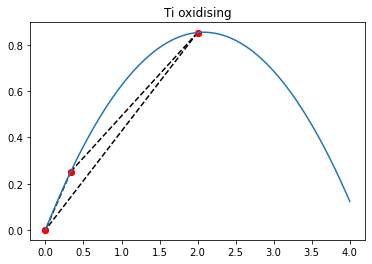

[-1.97978544e-01  8.22743932e-01 -1.28197512e-16]
V_ox
V mp-25279 5
{6.0: (-1.6672025899999996, None), 5.6: (-1.9032921203947368, None), 5.333: (-2.055800711136365, None), 6.667: (-1.4313400207692313, None)} -2.2880048985714287


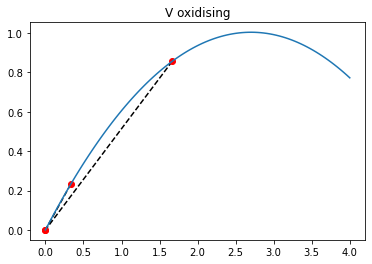

[-1.37491548e-01  7.43094558e-01 -1.92296269e-16]
Cr_ox
Cr mp-1244554 5
{6.0: (-1.5096780562500003, None), 5.333: (-1.648125680909089, None), 5.25: (-1.6757490275862064, None), 5.053: (-1.6798458562686558, None)} -1.6560083814285713


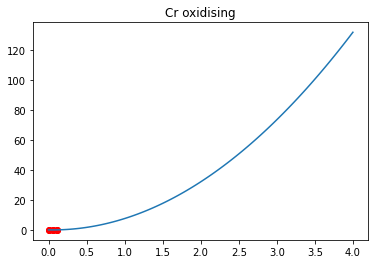

[ 8.48610710e+00 -8.99527352e-01 -4.00617226e-18]
Mn_ox
Mn None 5
Making synthetic formation energy, since MP doesn't have data for Mn in ox state: 5
{5: (-1.2830007617108057, None), 6.0: (-0.8597958736637921, None), 7.0: (-0.8788899611733711, None), 8.0: (-0.5717481299310352, None)} -1.2830007617108057


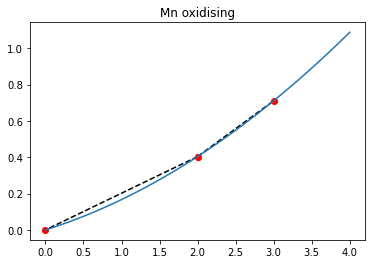

[ 3.50288103e-02  1.31997780e-01 -3.20493781e-17]
Fe_ox
Fe None 5
Making synthetic formation energy, since MP doesn't have data for Fe in ox state: 5
{5: (-0.8334251921865851, None), 6.5: (-0.4228968541176461, None), 6.0: (-0.5252123012499998, None)} -0.8334251921865851


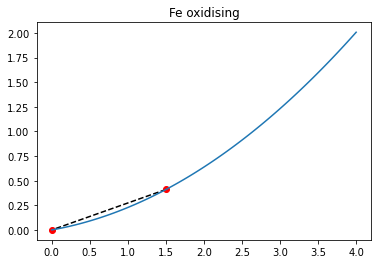

[ 9.12285196e-02  1.36842779e-01 -1.96261557e-17]
Co_ox
Co None 5
Making synthetic formation energy, since MP doesn't have data for Co in ox state: 5
{5: (-0.7354497083333336, None), 8.0: (-0.047739770000000625, None)} -0.7354497083333336
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 398835086  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  3  Error-roundoff 2.3e-15  _one-merge 1.2e-14
  _near-inside 5.8e-14  Visible-distance 4.6e-15  U-max-coplanar 4.6e-15
  Width-outside 9.3e-15  _wide-facet 2.8e-14  _maxoutside 1.4e-14

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     3  0.69
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring f

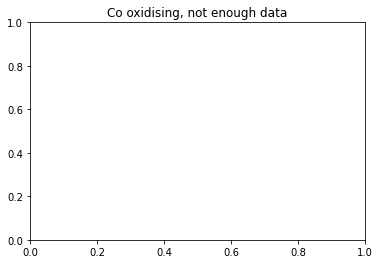

Cu_ox
Cu None 5
Making synthetic formation energy, since MP doesn't have data for Cu in ox state: 5
{5: (-0.22527619116666786, None)} -0.22527619116666786
WARNING! Adding an end member so can perform fit, try gather more data for this element.
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 398835086  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  5  Error-roundoff 3.5e-15  _one-merge 1.7e-14
  _near-inside 8.6e-14  Visible-distance 6.9e-15  U-max-coplanar 6.9e-15
  Width-outside 1.4e-14  _wide-facet 4.1e-14  _maxoutside 2.1e-14

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     5  0.23
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighbor

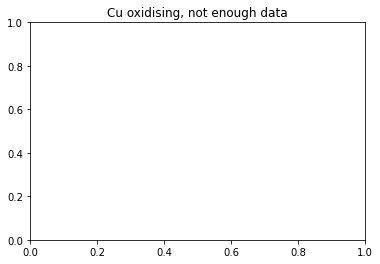

Nb_ox
Nb mp-581967 5
{6.0: (-2.4647783575, None)} -3.0327488496938786
WARNING! Adding an end member so can perform fit, try gather more data for this element.


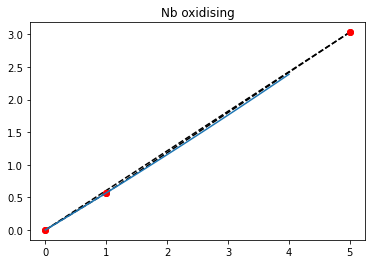

[0.00964482 0.55832567 0.        ]
Mo_ox
Mo mvc-4607 5
{5.333: (-1.6921007063636373, None), 6.0: (-1.9229110493749992, None), 10.0: (-0.6122070558333323, None), 5.778: (-1.9306581831428562, None), 8.0: (-1.0676932999999993, None), 5.75: (-1.9357723592741927, None), 5.5: (-1.9379535385000008, None), 5.6: (-1.9219500065789474, None), 5.556: (-1.933849459852941, None), 7.0: (-1.3700206205555556, None), 6.667: (-1.5436972284615376, None), 5.529: (-1.9361885139843742, None), 5.077: (-1.907396499130436, None)} -1.8604069878571439


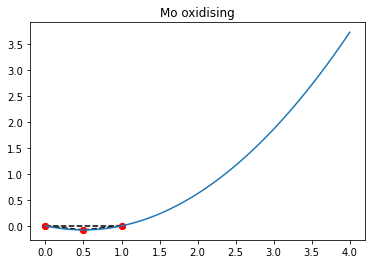

[ 3.10186203e-01 -3.10186203e-01  4.80740672e-17]
Sn_ox
Sn None 5
Making synthetic formation energy, since MP doesn't have data for Sn in ox state: 5
{5: (-1.7168403575533697, None), 5.333: (-1.1902154681818167, None)} -1.7168403575533697
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 398885507  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 0.53  Error-roundoff 4.5e-16  _one-merge 2.3e-15
  _near-inside 1.1e-14  Visible-distance 9e-16  U-max-coplanar 9e-16
  Width-outside 1.8e-15  _wide-facet 5.4e-15  _maxoutside 2.7e-15

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):  0.33  0.53
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring fac

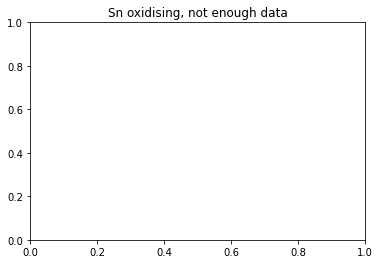

W_ox
W mvc-4845 5
{6.667: (-1.8374891892307703, None), 6.0: (-2.18341356125, None), 5.333: (-2.1379384777272725, None), 7.0: (-1.487451970555556, None), 10.0: (-0.9952835791666672, None), 5.444: (-2.1510018071641777, None), 5.25: (-2.1342536723275862, None), 5.6: (-1.393965988684211, None), 5.529: (-1.2628713085937497, None), 5.8: (-2.164486339230768, None), 5.84: (-2.169087442244897, None), 8.0: (-1.166829711, None)} -1.8945053635714295


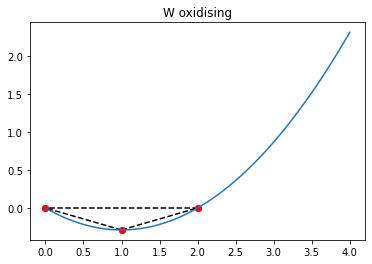

[ 2.88908198e-01 -5.77816395e-01  1.92296269e-16]
Ge_ox
Ge None 5
Making synthetic formation energy, since MP doesn't have data for Ge in ox state: 5
{5: (-1.3047757311119914, None), 6.571: (-0.7961393696666668, None)} -1.3047757311119914
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 398902314  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 1.6  Error-roundoff 1.3e-15  _one-merge 6.4e-15
  _near-inside 3.2e-14  Visible-distance 2.6e-15  U-max-coplanar 2.6e-15
  Width-outside 5.1e-15  _wide-facet 1.5e-14  _maxoutside 7.7e-15

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):   1.6  0.51
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring 

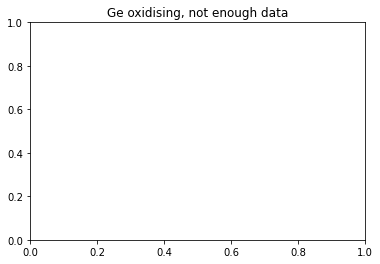

Rh_ox
Rh None 5
Making synthetic formation energy, since MP doesn't have data for Rh in ox state: 5
{5: (-1.3717615694999972, None)} -1.3717615694999972
WARNING! Adding an end member so can perform fit, try gather more data for this element.
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 398902314  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  5  Error-roundoff 4e-15  _one-merge 2e-14  _near-inside 9.9e-14
  Visible-distance 7.9e-15  U-max-coplanar 7.9e-15  Width-outside 1.6e-14
  _wide-facet 4.8e-14  _maxoutside 2.4e-14

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     5   1.4
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring fa

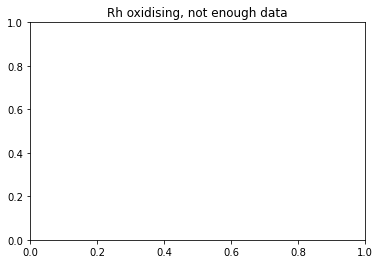

Sb_ox
Sb mp-1705 5
{9.333: (-0.156261096176471, None), 6.0: (-1.3299966474999998, None), 5.6: (-1.484265018157894, None), 8.0: (-0.5656004555000003, None), 7.0: (-0.9105243799999991, None), 5.333: (-1.6141966156060592, None)} -1.746537438571429


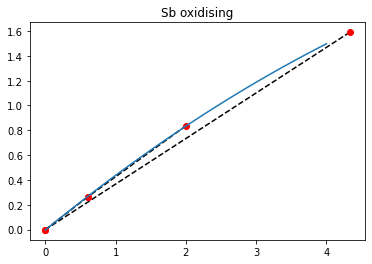

[-0.02167795  0.46162722 -0.0025957 ]
Te_ox
Te mp-12177 5
{6.0: (-1.34014721375, None), 12.0: (0.01071349196428617, None), 8.0: (-0.6346576669999999, None)} -1.416410942142857


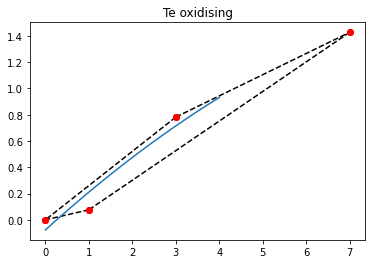

[-0.01189054  0.29945762 -0.07683758]
Ir_ox
Ir None 5
Making synthetic formation energy, since MP doesn't have data for Ir in ox state: 5
{5: (-1.147988563499999, None), 6.0: (-0.9806692612500001, None)} -1.147988563499999
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 398919121  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  1  Error-roundoff 7.5e-16  _one-merge 3.7e-15
  _near-inside 1.9e-14  Visible-distance 1.5e-15  U-max-coplanar 1.5e-15
  Width-outside 3e-15  _wide-facet 8.9e-15  _maxoutside 4.5e-15

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     1  0.17
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum

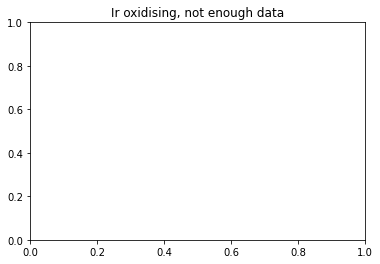

Ni_ox
Ni mp-1094139 5
{6.0: (0.4418155500000003, None)} -0.18039122642857164
WARNING! Adding an end member so can perform fit, try gather more data for this element.


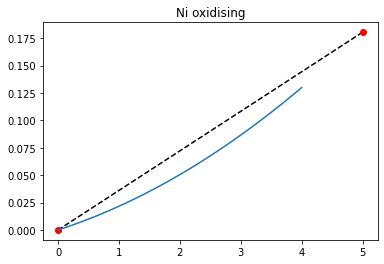

[0.00360782 0.01803912 0.        ]
Bi_ox
Bi mvc-8471 5
{} -1.1048817435714282
QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 398935928  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _maxoutside  0

Bi  needs to be done differently.


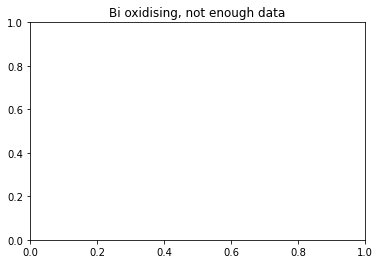

Sr_ox
Sr None 5
Making synthetic formation energy, since MP doesn't have data for Sr in ox state: 5
{5: (-1.6155305028148141, None), 20.0: (-0.5366029024242422, None), 12.0: (-0.7608211009523815, None), 8.0: (-0.43844373733333253, None)} -1.6155305028148141


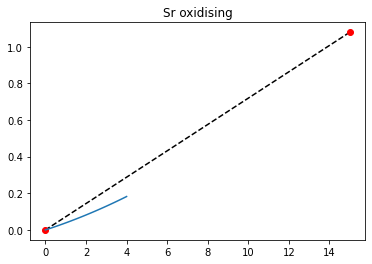

[0.00239762 0.03596425 0.        ]
Ru_ox
Ru None 5
Making synthetic formation energy, since MP doesn't have data for Ru in ox state: 5
{5: (-1.3643194628055548, None), 8.0: (-1.18034517175, None)} -1.3643194628055548
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 398935928  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  3  Error-roundoff 2.1e-15  _one-merge 1e-14  _near-inside 5.2e-14
  Visible-distance 4.2e-15  U-max-coplanar 4.2e-15  Width-outside 8.4e-15
  _wide-facet 2.5e-14  _maxoutside 1.3e-14

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     3  0.18
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round

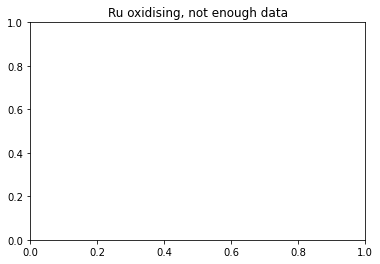

Ta_ox
Ta mp-1539317 5
{6.0: (-2.773167433125, None), 20.0: (-0.6023283481818185, None), 5.333: (-3.155838199772727, None), 7.0: (-2.1040779216666667, None)} -3.3394399635714285


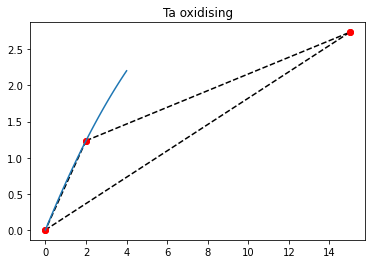

[-3.34774549e-02  6.84635931e-01 -5.12790050e-16]
In_ox
In None 5
Making synthetic formation energy, since MP doesn't have data for In in ox state: 5
{5: (-1.1178536784999995, None), 6.0: (-0.6457070812499994, None)} -1.1178536784999995
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 398952735  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  1  Error-roundoff 8.6e-16  _one-merge 4.3e-15
  _near-inside 2.1e-14  Visible-distance 1.7e-15  U-max-coplanar 1.7e-15
  Width-outside 3.4e-15  _wide-facet 1e-14  _maxoutside 5.1e-15

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     1  0.47
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet

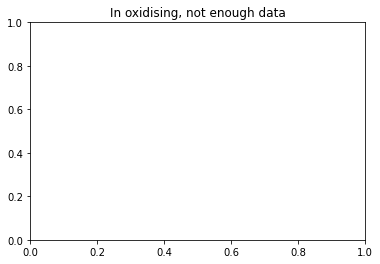

Pt_ox
Pt None 5
Making synthetic formation energy, since MP doesn't have data for Pt in ox state: 5
{5: (-0.7978397724999999, None), 12.0: (-0.13822952499999985, None), 6.0: (-0.6066289887499998, None)} -0.7978397724999999


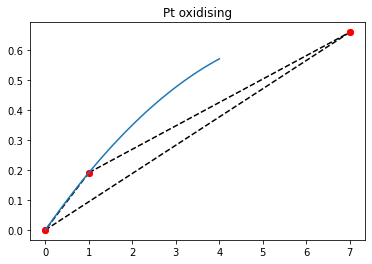

[-1.61634581e-02  2.07374242e-01  1.28197512e-16]
Pd_ox
Pd None 5
Making synthetic formation energy, since MP doesn't have data for Pd in ox state: 5
{5: (-0.725615179701154, None)} -0.725615179701154
WARNING! Adding an end member so can perform fit, try gather more data for this element.
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 398952735  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  5  Error-roundoff 3.7e-15  _one-merge 1.8e-14
  _near-inside 9.2e-14  Visible-distance 7.4e-15  U-max-coplanar 7.4e-15
  Width-outside 1.5e-14  _wide-facet 4.4e-14  _maxoutside 2.2e-14

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     5  0.73
- p0(v1):     0     0

The center point is coplanar with a 

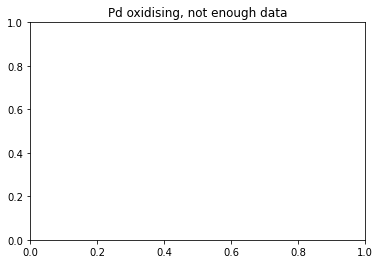

Re_ox
Re None 5
Making synthetic formation energy, since MP doesn't have data for Re in ox state: 5
{5: (-1.888515225139801, None), 6.0: (-2.1338565137500005, None), 5.333: (-1.879803413181817, None), 7.0: (-2.025063832638887, None), 10.0: (-1.0611578233333336, None), 6.667: (-1.0715554173076915, None)} -1.888515225139801


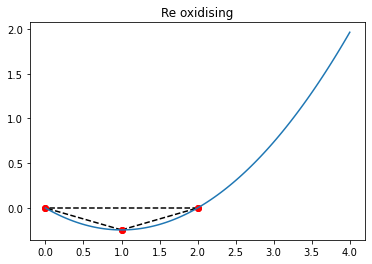

[ 2.45341289e-01 -4.90682577e-01  2.56395025e-16]
Os_ox
Os None 5
Making synthetic formation energy, since MP doesn't have data for Os in ox state: 5
{5: (-1.403616900999999, None), 8.0: (-1.5267574429999993, None)} -1.403616900999999


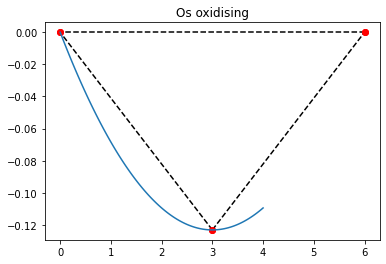

[ 1.36822824e-02 -8.20936947e-02  6.40987562e-17]
Tc_ox
Tc None 5
Making synthetic formation energy, since MP doesn't have data for Tc in ox state: 5
{5: (-1.851348721515151, None), 7.0: (-1.7976895825000003, None)} -1.851348721515151
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 398969542  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  2  Error-roundoff 1.4e-15  _one-merge 6.8e-15
  _near-inside 3.4e-14  Visible-distance 2.7e-15  U-max-coplanar 2.7e-15
  Width-outside 5.5e-15  _wide-facet 1.6e-14  _maxoutside 8.2e-15

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     2 0.054
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet

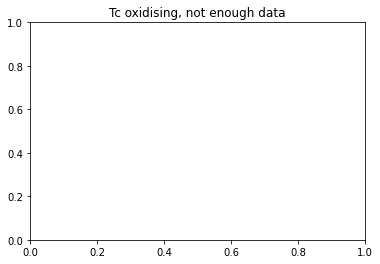

Pb_ox
Pb None 5
Making synthetic formation energy, since MP doesn't have data for Pb in ox state: 5
{5: (-0.6339690860637317, None)} -0.6339690860637317
WARNING! Adding an end member so can perform fit, try gather more data for this element.
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 398969542  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  5  Error-roundoff 3.6e-15  _one-merge 1.8e-14
  _near-inside 9.1e-14  Visible-distance 7.3e-15  U-max-coplanar 7.3e-15
  Width-outside 1.5e-14  _wide-facet 4.4e-14  _maxoutside 2.2e-14

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     5  0.63
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighborin

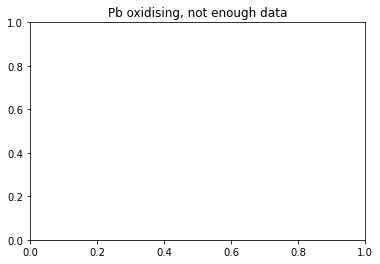

Li_ox
Li None 5
Making synthetic formation energy, since MP doesn't have data for Li in ox state: 5
{5: (-0.8742547079999995, None), 16.0: (-0.41708197851851736, None), 6.0: (-0.6233211891666661, None)} -0.8742547079999995


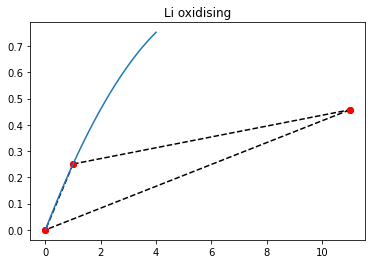

[-2.09372362e-02  2.71870755e-01 -1.28197512e-16]
Mg_ox
Mg None 5
Making synthetic formation energy, since MP doesn't have data for Mg in ox state: 5
{5: (-1.5038329520833318, None)} -1.5038329520833318
WARNING! Adding an end member so can perform fit, try gather more data for this element.
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 398986349  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  5  Error-roundoff 4e-15  _one-merge 2e-14  _near-inside 1e-13
  Visible-distance 8.1e-15  U-max-coplanar 8.1e-15  Width-outside 1.6e-14
  _wide-facet 4.8e-14  _maxoutside 2.4e-14

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     5   1.5
- p0(v1):     0     0

The center point is coplanar with a face

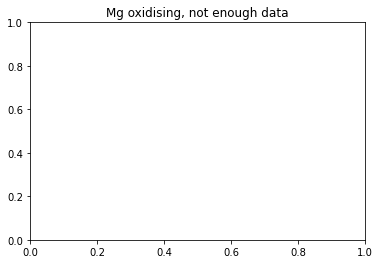

K_ox
K None 5
Making synthetic formation energy, since MP doesn't have data for K in ox state: 5
{5: (-0.8548918228999992, None), 6.0: (-0.6585419557499996, None)} -0.8548918228999992
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 398986349  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  1  Error-roundoff 7.6e-16  _one-merge 3.8e-15
  _near-inside 1.9e-14  Visible-distance 1.5e-15  U-max-coplanar 1.5e-15
  Width-outside 3e-15  _wide-facet 9.1e-15  _maxoutside 4.6e-15

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     1   0.2
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distance

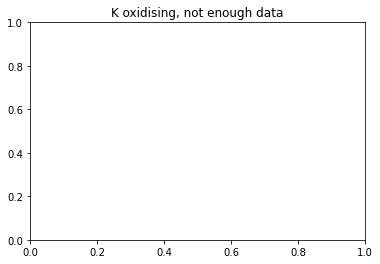

Na_ox
Na None 5
Making synthetic formation energy, since MP doesn't have data for Na in ox state: 5
{5: (-0.7904078934999996, None), 16.0: (-0.03585704916666632, None), 9.0: (-0.46065742249999886, None), 10.0: (-0.08516470083333338, None), 6.0: (-0.6018197012499993, None)} -0.7904078934999996


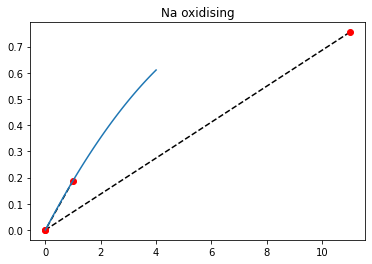

[-1.19992661e-02  2.00587458e-01 -2.56395025e-16]
La_ox
La None 5
Making synthetic formation energy, since MP doesn't have data for La in ox state: 5
{5: (-2.6646052945, None), 6.0: (-2.028691273749999, None)} -2.6646052945
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 399003156  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  1  Error-roundoff 8.6e-16  _one-merge 4.3e-15
  _near-inside 2.1e-14  Visible-distance 1.7e-15  U-max-coplanar 1.7e-15
  Width-outside 3.4e-15  _wide-facet 1e-14  _maxoutside 5.1e-15

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     1  0.64
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximu

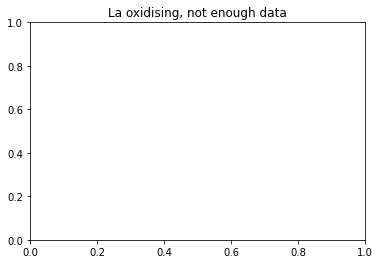

Ce_ox
Ce None 5
Making synthetic formation energy, since MP doesn't have data for Ce in ox state: 5
{5: (-3.3294228274999997, None), 6.0: (-2.4336232762499996, None)} -3.3294228274999997
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 399003156  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  1  Error-roundoff 8.6e-16  _one-merge 4.3e-15
  _near-inside 2.1e-14  Visible-distance 1.7e-15  U-max-coplanar 1.7e-15
  Width-outside 3.4e-15  _wide-facet 1e-14  _maxoutside 5.1e-15

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     1   0.9
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing dista

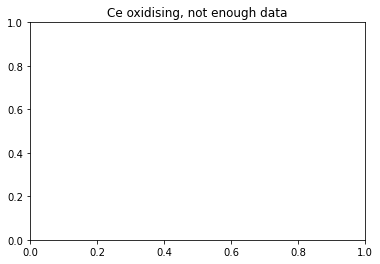

Pr_ox
Pr None 5
Making synthetic formation energy, since MP doesn't have data for Pr in ox state: 5
{5: (-2.5907789374999997, None), 6.0: (-1.9404715562499995, None)} -2.5907789374999997
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 399019963  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  1  Error-roundoff 8.6e-16  _one-merge 4.3e-15
  _near-inside 2.1e-14  Visible-distance 1.7e-15  U-max-coplanar 1.7e-15
  Width-outside 3.4e-15  _wide-facet 1e-14  _maxoutside 5.1e-15

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     1  0.65
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing dista

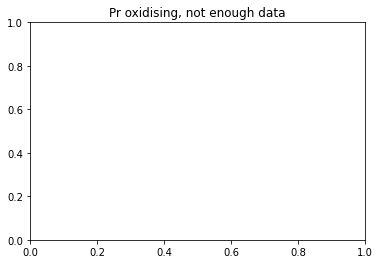

Nd_ox
Nd mp-985608 5
{6.0: (-2.0825348624999993, None)} -2.678576924285715
WARNING! Adding an end member so can perform fit, try gather more data for this element.


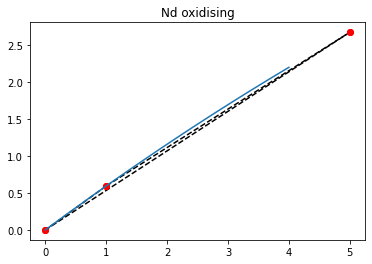

[-1.50816692e-02  6.11123731e-01 -1.28197512e-16]
Sm_ox
Sm None 5
Making synthetic formation energy, since MP doesn't have data for Sm in ox state: 5
{5: (-2.630604956499999, None), 6.0: (-1.9847407920833327, None)} -2.630604956499999
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 399019963  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  1  Error-roundoff 8.6e-16  _one-merge 4.3e-15
  _near-inside 2.1e-14  Visible-distance 1.7e-15  U-max-coplanar 1.7e-15
  Width-outside 3.4e-15  _wide-facet 1e-14  _maxoutside 5.1e-15

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     1  0.65
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet. 

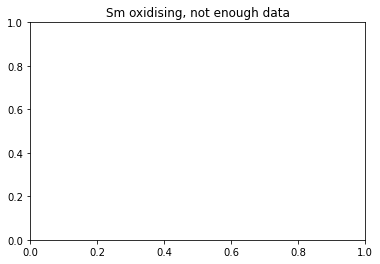

Eu_ox
Eu None 5
Making synthetic formation energy, since MP doesn't have data for Eu in ox state: 5
{5: (-2.1743737869999995, None), 6.0: (-1.7015827825, None)} -2.1743737869999995
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 399019963  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  1  Error-roundoff 8.6e-16  _one-merge 4.3e-15
  _near-inside 2.1e-14  Visible-distance 1.7e-15  U-max-coplanar 1.7e-15
  Width-outside 3.4e-15  _wide-facet 1e-14  _maxoutside 5.1e-15

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     1  0.47
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances i

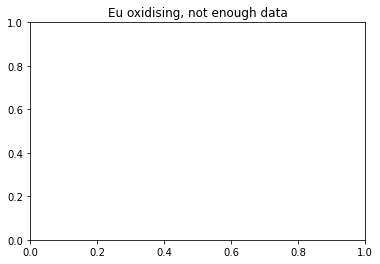

Gd_ox
Gd None 5
Making synthetic formation energy, since MP doesn't have data for Gd in ox state: 5
{5: (-2.5642914994999986, None), 6.0: (-1.7648668062499988, None)} -2.5642914994999986
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 399019963  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  1  Error-roundoff 8.6e-16  _one-merge 4.3e-15
  _near-inside 2.1e-14  Visible-distance 1.7e-15  U-max-coplanar 1.7e-15
  Width-outside 3.4e-15  _wide-facet 1e-14  _maxoutside 5.1e-15

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     1   0.8
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing dista

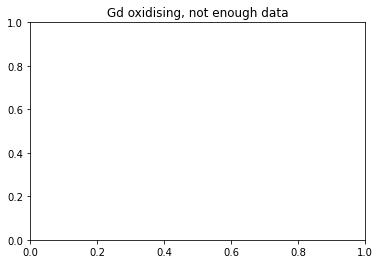

Tb_ox
Tb None 5
Making synthetic formation energy, since MP doesn't have data for Tb in ox state: 5
{5: (-2.729626439999999, None), 6.0: (-2.0443497949999996, None)} -2.729626439999999
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 399019963  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  1  Error-roundoff 8.6e-16  _one-merge 4.3e-15
  _near-inside 2.1e-14  Visible-distance 1.7e-15  U-max-coplanar 1.7e-15
  Width-outside 3.4e-15  _wide-facet 1e-14  _maxoutside 5.1e-15

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     1  0.69
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distanc

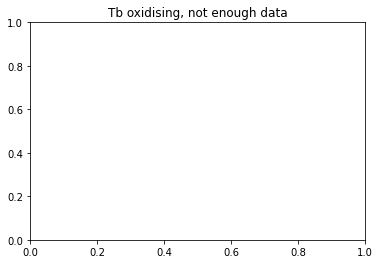

Dy_ox
Dy None 5
Making synthetic formation energy, since MP doesn't have data for Dy in ox state: 5
{5: (-2.6980675169999992, None), 6.0: (-1.9951220799999998, None)} -2.6980675169999992
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 399036770  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  1  Error-roundoff 8.6e-16  _one-merge 4.3e-15
  _near-inside 2.1e-14  Visible-distance 1.7e-15  U-max-coplanar 1.7e-15
  Width-outside 3.4e-15  _wide-facet 1e-14  _maxoutside 5.1e-15

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     1   0.7
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing dista

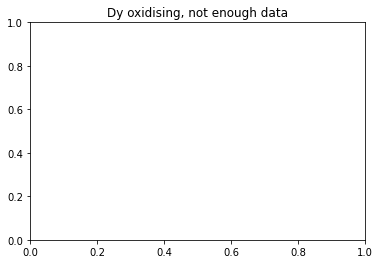

Er_ox
Er None 5
Making synthetic formation energy, since MP doesn't have data for Er in ox state: 5
{5: (-2.7493449929999993, None), 6.0: (-2.0756603474999995, None)} -2.7493449929999993
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 399036770  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  1  Error-roundoff 8.6e-16  _one-merge 4.3e-15
  _near-inside 2.1e-14  Visible-distance 1.7e-15  U-max-coplanar 1.7e-15
  Width-outside 3.4e-15  _wide-facet 1e-14  _maxoutside 5.1e-15

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     1  0.67
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing dista

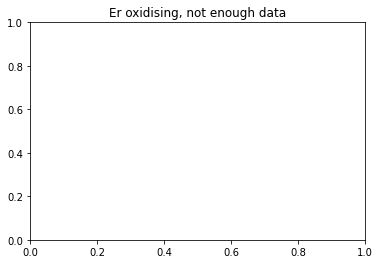

Tm_ox
Tm None 5
Making synthetic formation energy, since MP doesn't have data for Tm in ox state: 5
{5: (-2.773378927, None), 6.0: (-2.0950142308333337, None)} -2.773378927
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 399053577  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  1  Error-roundoff 8.6e-16  _one-merge 4.3e-15
  _near-inside 2.1e-14  Visible-distance 1.7e-15  U-max-coplanar 1.7e-15
  Width-outside 3.4e-15  _wide-facet 1e-14  _maxoutside 5.1e-15

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     1  0.68
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 8.6e-1

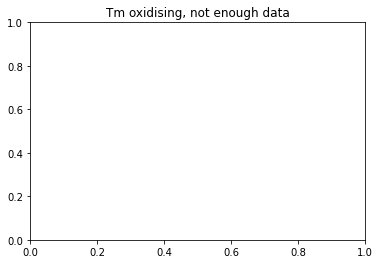

Lu_ox
Lu None 5
Making synthetic formation energy, since MP doesn't have data for Lu in ox state: 5
{5: (-2.7495184094999994, None), 6.0: (-2.0099909587499996, None)} -2.7495184094999994
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 399053577  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  1  Error-roundoff 8.6e-16  _one-merge 4.3e-15
  _near-inside 2.1e-14  Visible-distance 1.7e-15  U-max-coplanar 1.7e-15
  Width-outside 3.4e-15  _wide-facet 1e-14  _maxoutside 5.1e-15

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     1  0.74
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing dista

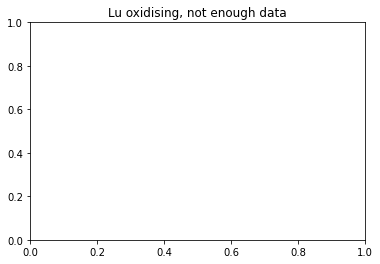

Ti_red
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5
{5: (-2.6918424492994673, None), 2.0: (-2.9071563699999987, None), 4.0: (-3.5004083808333317, None), 0.667: (-1.5697335962499988, None), 3.75: (-3.4431146963043484, None), 1.0: (-2.0351443700000003, None), 3.0: (-3.3023919079999993, None), 2.286: (-2.9231182106666656, None), 2.222: (-2.814811233157895, None), 3.333: (-3.3788314575000005, None), 2.667: (-3.162819814285714, None), 1.5: (-2.4343817757142863, None), 2.6: (-3.1366758056521733, None), 3.714: (-3.4387194580000005, None), 3.273: (-3.348024685172412, None), 3.2: (-3.3376386461538448, None), 4.667: (-2.9123895604999994, None), 2.2: (-2.8552565857142853, None), 2.545: (-3.0972685827999986, None), 1.333: (-2.352037861999999, None), 2.5: (-3.0901187155555556, None), 3.5: (-3.4050568290909085, None), 0.333: (-0.9167805728571415, None), 3.778: (-3.447345939038462, None), 3.385: (-3.3788645235714267, None), 3.667: (-3.43545341235294, None), 1.77

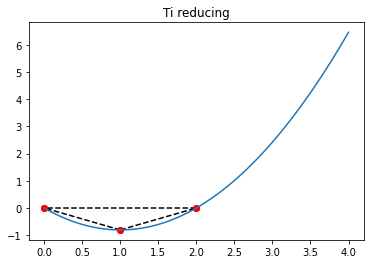

V_red
{3.6: (-2.4959239401785704, None), 4.333: (-2.3911917192105263, None), 3.667: (-2.485902672941177, None), 4.0: (-2.4794067783333333, None), 2.0: (-2.090043212499999, None), 0.857: (-0.43666697499999985, None), 1.143: (-0.8881518818181797, None), 3.778: (-2.462404367500001, None), 3.333: (-2.5216525662499993, None), 4.889: (-2.2714556470967744, None), 4.8: (-2.298258969264706, None), 4.667: (-2.321625787999998, None), 3.0: (-2.5252870819999997, None), 3.5: (-2.490026317272726, None), 4.5: (-2.351045160384616, None), 3.714: (-2.4586360342499978, None), 3.75: (-2.337635941956521, None), 0.375: (0.7281016226315802, None), 0.25: (0.9098015111111126, None), 2.56: (-2.2929163908771932, None), 4.833: (-2.282671881707316, None), 2.889: (-2.275099697727272, None), 2.8: (-2.282146054583334, None), 1.8: (-1.7884478799999992, None), 2.462: (-1.6411814374137919, None)} -2.2880048985714287


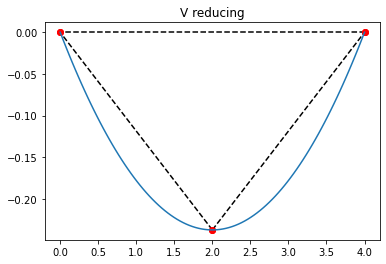

Cr_red
{2.0: (-1.9660694824999996, None), 1.0: (0.007758293333332444, None), 4.5: (-1.5744720719230765, None), 3.0: (-2.3653643719999997, None), 4.0: (-2.0463415316666667, None), 4.8: (-1.830739899558821, None), 3.333: (-1.8854764925000005, None), 0.667: (0.08262339625000004, None), 2.889: (-2.036759932727272, None), 2.667: (-2.1697531942857133, None), 2.8: (-1.8816294612499989, None), 3.667: (-1.760707489705883, None), 4.667: (-1.5873285454999984, None)} -1.6560083814285713


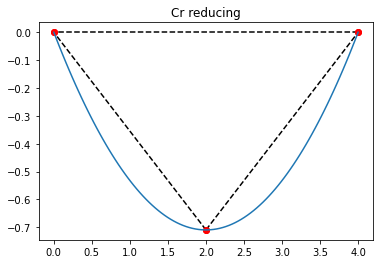

Mn_red
Making synthetic formation energy, since MP doesn't have data for Mn in ox state: 5
{5: (-1.2830007617108057, None), 3.0: (-2.01278611373707, None), 3.81: (-1.7949999269304695, None), 4.0: (-1.8045735507183918, None), 4.25: (-1.6370894718896554, None), 3.2: (-1.9554149721750664, None), 2.0: (-1.9783539098275864, None), 2.667: (-2.04937645270936, None), 4.267: (-1.6300832924431403, None), 2.8: (-1.7996586556896559, None), 2.889: (-1.7962894089498413, None), 4.3: (-1.5862975981444989, None), 3.429: (-1.8663043782940107, None)} -1.2830007617108057


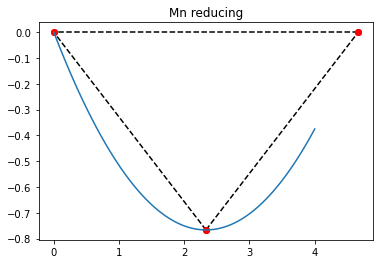

Fe_red
Making synthetic formation energy, since MP doesn't have data for Fe in ox state: 5
{5: (-0.8334251921865851, None), 4.0: (-1.235214297916666, None), 3.0: (-1.706157623999999, None), 2.0: (-1.4808619749999994, None), 2.667: (-1.6443452507142848, None), 2.143: (-1.4611972017241386, None), 2.286: (-1.4929919349999996, None), 2.25: (-1.497695499999999, None), 2.2: (-1.4895340702380948, None), 2.571: (-1.4037979220833336, None), 2.133: (-1.440410848387096, None), 3.2: (-1.4770011859615377, None), 2.923: (-1.38999518875, None), 2.977: (-1.582225990654206, None), 2.783: (-1.5573064770909086, None), 2.222: (-1.1914144752631572, None), 2.5: (0.2217913722222229, None), 2.732: (-1.5702393636082461, None), 2.118: (-1.47294044, None), 3.048: (-1.495322866226414, None), 2.154: (-1.451367239259259, None), 2.8: (-1.4990504666666662, None), 2.56: (-0.07701086964912074, None), 2.889: (-1.422402863181817, None), 2.053: (-1.4245943180519474, None), 2.057: (-0.7133691808450711, None), 2.174: (-1.47

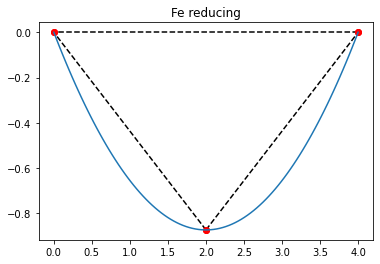

Co_red
Making synthetic formation energy, since MP doesn't have data for Co in ox state: 5
{5: (-0.7354497083333336, None), 4.0: (-1.0793046775000001, None), 3.81: (-0.9897550699180333, None), 2.759: (-1.1907349313768116, None), 2.783: (-1.1552269373636372, None), 2.0: (-1.283361111250001, None), 2.8: (-0.8709627491666674, None), 2.667: (-1.2688075828571415, None), 3.0: (-0.8174023644999995, None), 3.2: (-1.1397359465384613, None), 3.429: (-1.0254213628947362, None), 2.889: (-1.012852294772728, None), 3.733: (-1.0861586291860479, None)} -0.7354497083333336


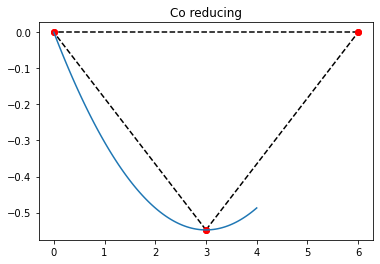

Cu_red
Making synthetic formation energy, since MP doesn't have data for Cu in ox state: 5
{5: (-0.22527619116666786, None), 2.0: (-0.9417754449999993, None), 2.667: (-0.830971802857142, None), 0.25: (-0.09701978444444426, None), 1.75: (-0.828966427333333, None), 4.0: (-0.5284182333333338, None), 3.0: (-0.8315602754999998, None), 1.5: (-0.8034370885714286, None), 2.889: (-0.6653228745454531, None), 0.031: (0.0023917419999993916, None), 2.8: (-0.6631301674999999, None), 1.333: (-0.6026431479999994, None), 1.0: (-0.6438123283333332, None)} -0.22527619116666786


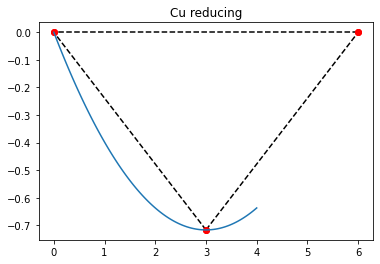

Nb_red
{4.0: (-2.8962547749999996, None), 2.0: (-2.284779936666666, None), 4.833: (-3.037484205731707, None), 4.5: (-2.7844568053846155, None), 2.5: (-2.4662042883333326, None), 3.0: (-2.571343245000001, None)} -3.0327488496938786


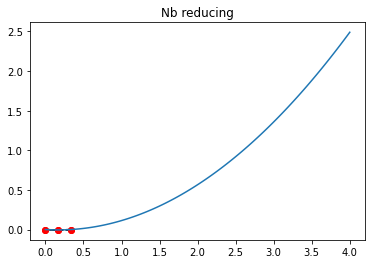

Mo_red
{4.0: (-2.015734385833332, None), 1.0: (1.4477830133333336, None), 4.5: (-1.8623810976923076, None), 2.5: (-1.0023631494444443, None), 4.667: (-1.7659168107500003, None), 3.0: (-1.4891102515, None)} -1.8604069878571439


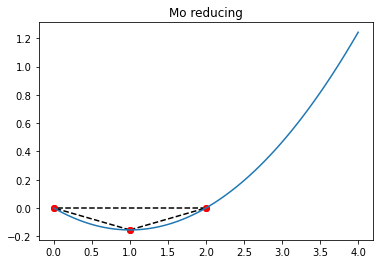

Sn_red
Making synthetic formation energy, since MP doesn't have data for Sn in ox state: 5
{5: (-1.7168403575533697, None), 4.0: (-2.1118337116666663, None), 2.0: (-1.6373192899999993, None), 2.8: (-1.6239665812500008, None), 2.667: (-1.4847793421428572, None), 3.0: (-1.6564513714999998, None), 2.4: (-1.7689397277272736, None)} -1.7168403575533697


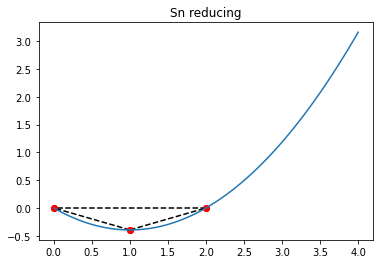

W_red
{4.0: (-1.9415572149999991, None), 2.889: (-0.9532264250000009, None), 4.5: (-1.920446263076924, None), 0.667: (2.3424234975000013, None), 3.0: (-0.9583725439999999, None), 2.8: (-0.9263005275000009, None), 4.667: (-1.9940342265000002, None)} -1.8945053635714295


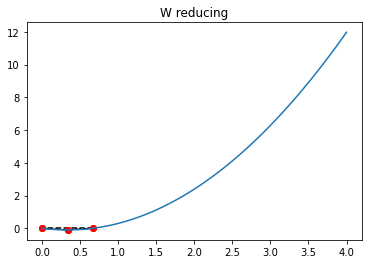

Ge_red
Making synthetic formation energy, since MP doesn't have data for Ge in ox state: 5
{5: (-1.3047757311119914, None), 4.0: (-2.077524513333333, None), 0.667: (0.07809425750000032, None), 4.4: (-1.5926114290625, None), 3.0: (-1.487880064, None), 4.571: (-1.658599625217391, None)} -1.3047757311119914


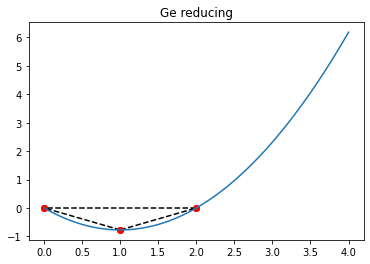

Rh_red
Making synthetic formation energy, since MP doesn't have data for Rh in ox state: 5
{5: (-1.3717615694999972, None), 3.0: (-1.0805171705000007, None), 4.0: (-1.226139369999999, None)} -1.3717615694999972
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 399339296  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  2  Error-roundoff 1.5e-15  _one-merge 7.4e-15
  _near-inside 3.7e-14  Visible-distance 2.9e-15  U-max-coplanar 2.9e-15
  Width-outside 5.9e-15  _wide-facet 1.8e-14  _maxoutside 8.8e-15

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v3):     0     0
- p2(v2):     2  0.29
- p0(v1):     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off

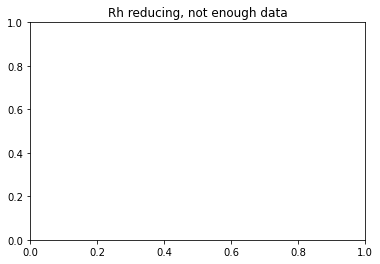

Sb_red
{4.0: (-1.8361327245833334, None), 4.077: (-1.4033647975949375, None), 3.0: (-1.7505081319999998, None), 4.333: (-1.780067918157895, None), 4.667: (-1.6950011810000003, None), 4.5: (-1.5627934211538461, None)} -1.746537438571429


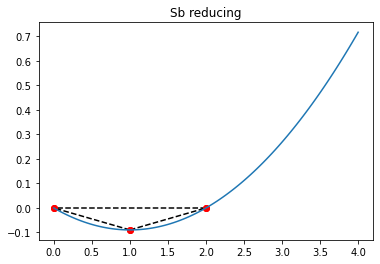

Te_red
{2.0: (-0.2967256174999995, None), 4.0: (-1.4933416687499999, None), 4.5: (-1.450862100769231, None)} -1.416410942142857


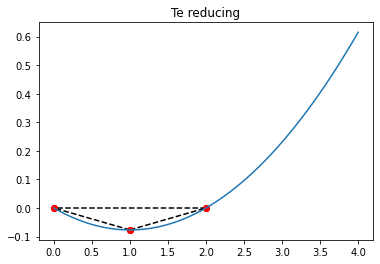

Ir_red
Making synthetic formation energy, since MP doesn't have data for Ir in ox state: 5
{5: (-1.147988563499999, None), 4.0: (-1.2595347649999984, None)} -1.147988563499999


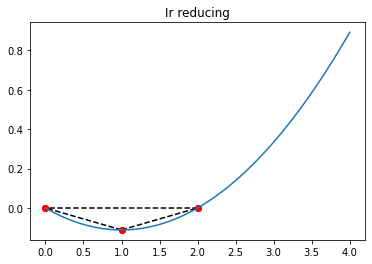

Ni_red
{2.4: (-1.067370058181818, None), 4.0: (-0.6854691133333328, None), 4.4: (-0.52219416375, None), 0.5: (1.0186116860000005, None), 2.333: (-1.0777615892307693, None), 2.889: (-0.8096237477272723, None), 2.133: (-1.1516823264516134, None), 3.0: (-0.6389061689999997, None), 2.222: (-1.1073149231578947, None), 2.0: (-1.2172232425000002, None), 1.5: (-0.6123868157142858, None), 1.6: (-0.7310815366666668, None), 2.667: (-1.045719877857143, None), 2.8: (-0.4415433120833332, None)} -0.18039122642857164


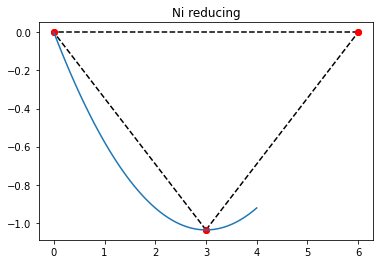

Bi_red
{4.0: (-1.4596107733333326, None), 3.0: (-1.6419509899999993, None), 2.5: (-1.3705073783333344, None), 1.333: (-0.9692701079999995, None), 3.5: (-1.5692198868181815, None), 3.333: (-1.532515026875, None), 3.125: (-1.5730462600000013, None), 2.0: (-0.8834113649999993, None), 3.158: (-1.5676038183673473, None), 4.5: (-1.1281416711538457, None), 3.077: (-1.596705497272727, None), 3.04: (-1.5938509382539676, None), 4.667: (-1.170843057999999, None)} -1.1048817435714282


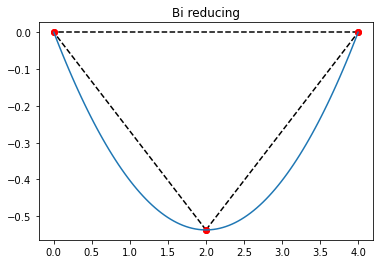

Sr_red
Making synthetic formation energy, since MP doesn't have data for Sr in ox state: 5
{5: (-1.6155305028148141, None), 2.0: (-3.0760772683333326, None), 3.0: (-1.947839178666666, None), 4.0: (-2.204073885555555, None)} -1.6155305028148141


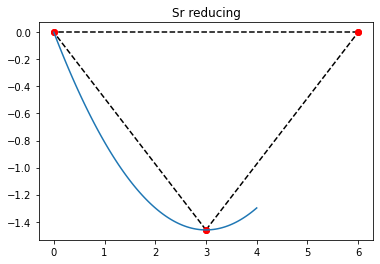

Ru_red
Making synthetic formation energy, since MP doesn't have data for Ru in ox state: 5
{5: (-1.3643194628055548, None), 4.0: (-1.4563066083333323, None)} -1.3643194628055548


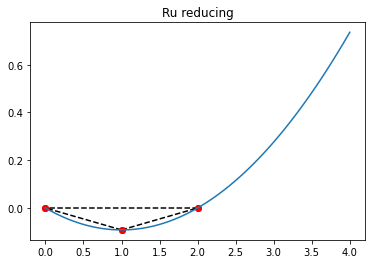

Ta_red
{3.0: (-2.5973844159999993, None), 0.364: (-0.49981957461538407, None), 2.0: (-1.2294543900000003, None), 0.5: (-0.7141294899999997, None), 1.909: (-1.7283779502325576, None), 4.0: (-3.0563588270833315, None), 1.8: (-1.5579393142105258, None), 1.0: (0.21959143666666736, None)} -3.3394399635714285


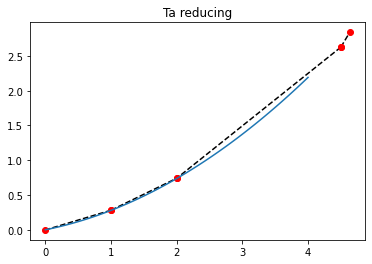

In_red
Making synthetic formation energy, since MP doesn't have data for In in ox state: 5
{5: (-1.1178536784999995, None), 3.0: (-1.9957859764999992, None), 4.0: (-1.432618076666666, None), 2.0: (-1.3538012274999995, None)} -1.1178536784999995


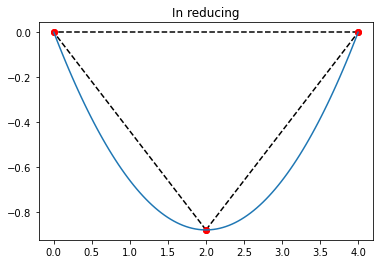

Pt_red
Making synthetic formation energy, since MP doesn't have data for Pt in ox state: 5
{5: (-0.7978397724999999, None), 4.0: (-0.9253136283333334, None), 2.667: (-0.8257142857142856, None), 2.0: (-0.5834008599999998, None), 1.0: (-0.046155861666665965, None)} -0.7978397724999999


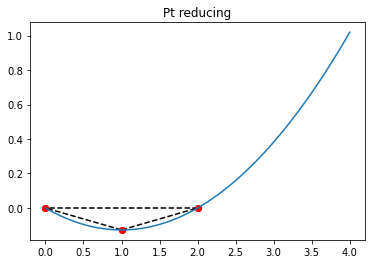

Pd_red
Making synthetic formation energy, since MP doesn't have data for Pd in ox state: 5
{5: (-0.725615179701154, None), 4.0: (-0.7272990283333329, None), 2.286: (-0.7301851448888876, None), 1.0: (-0.38643381666666676, None), 2.0: (-0.7904939249999994, None)} -0.725615179701154


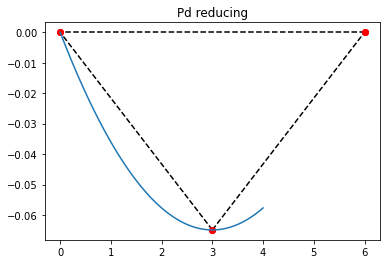

Re_red
Making synthetic formation energy, since MP doesn't have data for Re in ox state: 5
{5: (-1.888515225139801, None), 4.0: (-1.8950494924999988, None)} -1.888515225139801


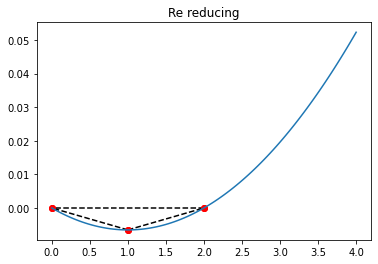

Os_red
Making synthetic formation energy, since MP doesn't have data for Os in ox state: 5
{5: (-1.403616900999999, None), 4.0: (-1.3420466299999991, None), 0.667: (0.6572859300000016, None), 0.0: (0.0, None)} -1.403616900999999


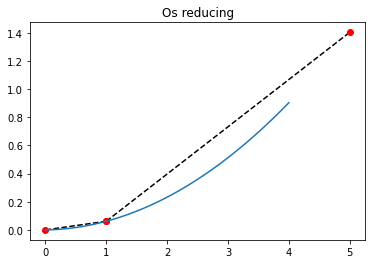

Tc_red
Making synthetic formation energy, since MP doesn't have data for Tc in ox state: 5
{5: (-1.851348721515151, None), 4.0: (-1.8820110866666657, None)} -1.851348721515151


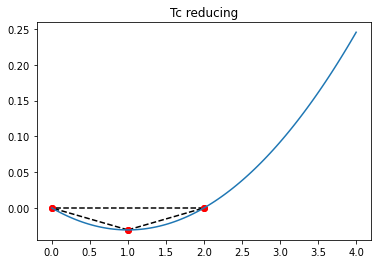

Pb_red
Making synthetic formation energy, since MP doesn't have data for Pb in ox state: 5
{5: (-0.6339690860637317, None), 3.0: (-1.3921388914999997, None), 2.667: (-1.4458367167857138, None), 2.0: (-1.468085744531249, None), 4.0: (-1.2983015083333336, None), 1.0: (-0.6230187866666663, None), 4.571: (-0.9189676952173911, None), 0.667: (0.0013737949999999, None), 3.333: (-1.3205758828125003, None)} -0.6339690860637317


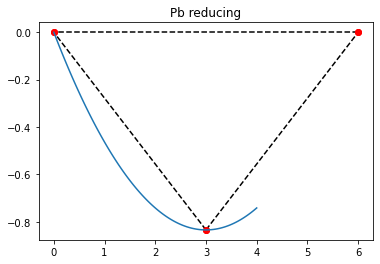

Li_red
Making synthetic formation energy, since MP doesn't have data for Li in ox state: 5
{5: (-0.8742547079999995, None), 4.0: (-1.041543720555555, None), 1.0: (-2.060918257777777, None), 2.0: (-1.649150745833333, None)} -0.8742547079999995


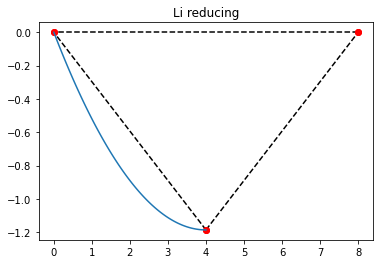

Mg_red
Making synthetic formation energy, since MP doesn't have data for Mg in ox state: 5
{5: (-1.5038329520833318, None), 2.0: (-3.053762761666667, None), 4.0: (-2.020476221944443, None)} -1.5038329520833318


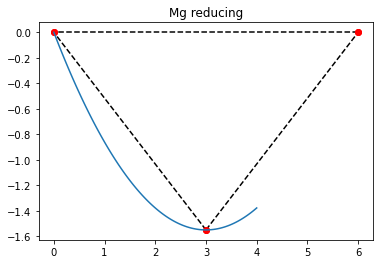

K_red
Making synthetic formation energy, since MP doesn't have data for K in ox state: 5
{5: (-0.8548918228999992, None), 4.0: (-0.9857917343333322, None), 1.0: (-1.2471773619999997, None), 2.0: (-1.2944210415000001, None)} -0.8548918228999992


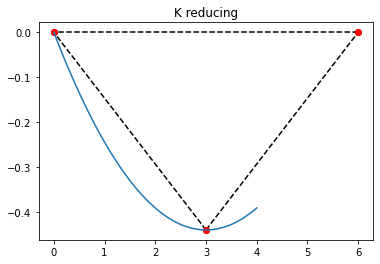

Na_red
Making synthetic formation energy, since MP doesn't have data for Na in ox state: 5
{5: (-0.7904078934999996, None), 4.0: (-0.9161333549999999, None), 1.0: (-1.4445339566666664, None), 0.333: (-0.48058498809523786, None), 2.0: (-1.3117934458333331, None)} -0.7904078934999996


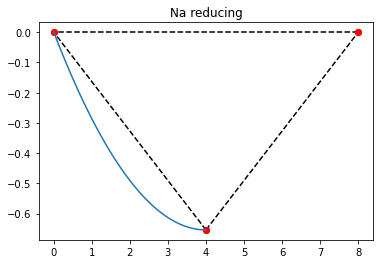

La_red
Making synthetic formation energy, since MP doesn't have data for La in ox state: 5
{5: (-2.6646052945, None), 4.0: (-3.0885479750000004, None), 3.0: (-3.8729007112499994, None), 2.0: (-3.2033101475000003, None)} -2.6646052945


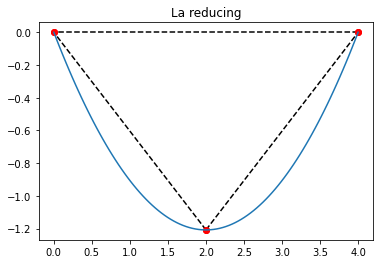

Ce_red
Making synthetic formation energy, since MP doesn't have data for Ce in ox state: 5
{5: (-3.3294228274999997, None), 3.375: (-3.8897423948837204, None), 3.429: (-3.9176818328947363, None), 3.0: (-3.768572169250001, None), 4.0: (-3.926622528333333, None), 3.6: (-3.9414715867857146, None), 3.636: (-3.9398167995161293, None), 2.0: (-3.2331423524999994, None), 3.692: (-3.9333783812162166, None), 3.765: (-3.934809990918366, None)} -3.3294228274999997


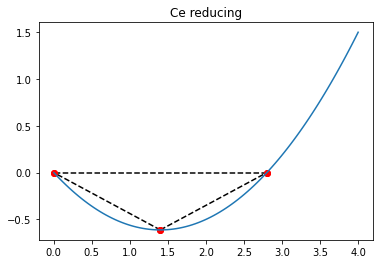

Pr_red
Making synthetic formation energy, since MP doesn't have data for Pr in ox state: 5
{5: (-2.5907789374999997, None), 4.0: (-3.024317191666666, None), 3.667: (-3.2180700727941165, None), 2.0: (-3.0452805774999994, None), 3.429: (-3.4043555749999994, None), 3.556: (-3.311919916999999, None), 3.0: (-3.7338758977500004, None), 3.636: (-3.2632359953225816, None), 3.6: (-3.2581782119642857, None)} -2.5907789374999997


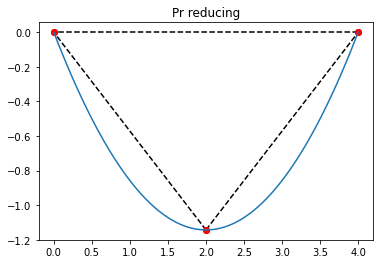

Nd_red
{2.0: (-3.072314965, None), 4.0: (-3.158298708333334, None), 3.0: (-3.780325633499999, None)} -2.678576924285715


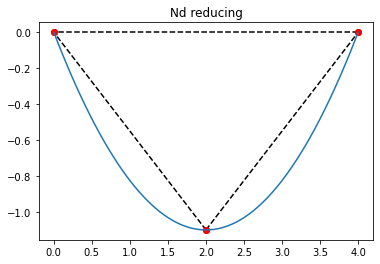

Sm_red
Making synthetic formation energy, since MP doesn't have data for Sm in ox state: 5
{5: (-2.630604956499999, None), 4.0: (-3.0611810661111103, None), 1.313: (-2.3164324476729563, None), 3.0: (-3.8610905335833317, None), 1.0: (-2.0739774922222223, None), 2.0: (-3.1065974566666665, None)} -2.630604956499999


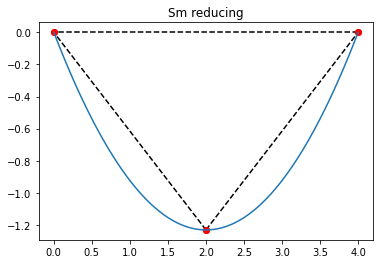

Eu_red
Making synthetic formation energy, since MP doesn't have data for Eu in ox state: 5
{5: (-2.1743737869999995, None), 4.0: (-2.4895677899999993, None), 2.0: (-3.120071602500001, None), 3.0: (-3.16916702975, None), 2.667: (-3.2162326671428576, None)} -2.1743737869999995


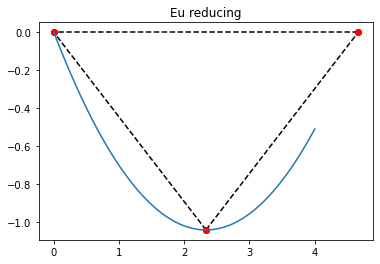

Gd_red
Making synthetic formation energy, since MP doesn't have data for Gd in ox state: 5
{5: (-2.5642914994999986, None), 3.0: (-3.8941747337499986, None), 4.0: (-3.0972412949999986, None), 2.0: (-3.0340646700000007, None)} -2.5642914994999986


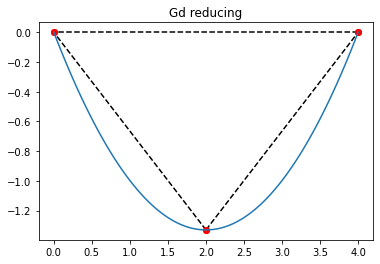

Tb_red
Making synthetic formation energy, since MP doesn't have data for Tb in ox state: 5
{5: (-2.729626439999999, None), 3.636: (-3.45479136580645, None), 3.0: (-3.98235453075, None), 4.0: (-3.1864775366666653, None), 3.429: (-3.609428142631577, None), 3.25: (-3.7167553709523804, None), 3.6: (-3.4674899171428577, None), 3.667: (-3.387980654117647, None)} -2.729626439999999


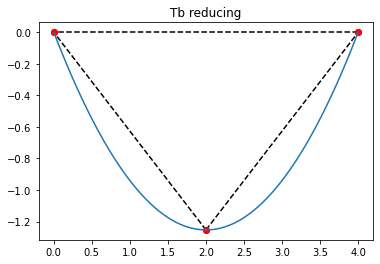

Dy_red
Making synthetic formation energy, since MP doesn't have data for Dy in ox state: 5
{5: (-2.6980675169999992, None), 3.0: (-4.008457858, None), 4.0: (-3.1666978083333324, None)} -2.6980675169999992


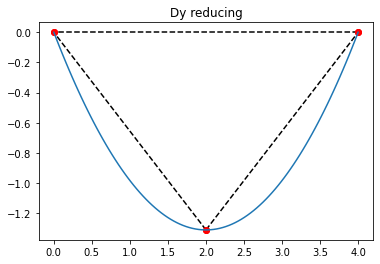

Er_red
Making synthetic formation energy, since MP doesn't have data for Er in ox state: 5
{5: (-2.7493449929999993, None), 3.0: (-4.055964048249999, None), 2.0: (-3.126673905, None), 4.0: (-3.198468089999999, None)} -2.7493449929999993


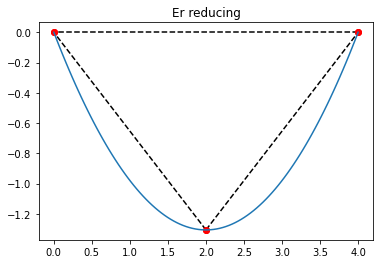

Tm_red
Making synthetic formation energy, since MP doesn't have data for Tm in ox state: 5
{5: (-2.773378927, None), 3.0: (-4.091819262583334, None), 4.0: (-3.225622057777777, None)} -2.773378927


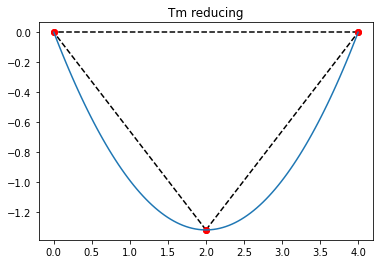

Lu_red
Making synthetic formation energy, since MP doesn't have data for Lu in ox state: 5
{5: (-2.7495184094999994, None), 3.0: (-4.12285494725, None), 4.0: (-3.242536709999999, None)} -2.7495184094999994


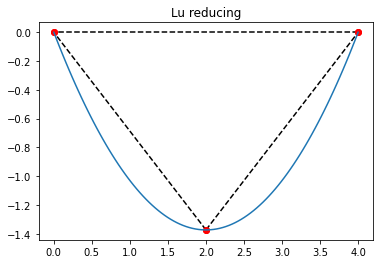

In [122]:
quadratic_equations_ox = defaultdict()
ox_state = 5
ox_state_ = 5

for ele in ele2mp_3:#['Fe', 'Co', 'Mn', 'Ir', 'Ru']:
    print("{}_ox".format(ele))
    print(ele, ele2mp_3[ele], ox_state)
    ox2low, form_ene = get_ox2lowest(ele, ele2mp_3[ele], ox_state_, oxidising=True)
    hull_ox2energy = get_lower_hull_symmetric(ox2low, ox_state_, form_ene, ele, oxidising=True)
    if hull_ox2energy is None:
        #ref_ene, _, _ = get_ref_data(ele, ele2mp_3[ele], desired_ox=ox_state)
        # for now we just divide the formation energy and assume a linear slope
        # but ideally would be a quadratic equation using MO_[2+/-x] data
        quadratic_equations_ox[ele] = [0, -form_ene/(8-ox_state),0]
        continue

    coeffs = get_quadratic(hull_ox2energy)
    print(coeffs)
    quadratic_equations_ox[ele] = coeffs
    
quadratic_equations_red = defaultdict()
for ele in ele2mp_3:#['Fe', 'Co', 'Mn', 'Ir', 'Ru']:
    print("{}_red".format(ele))
    ox2low, form_ene = get_ox2lowest(ele, ele2mp_3[ele], ox_state_, oxidising=False)
        
    #hull_ox2energy = get_lower_hull(ox2low, ox_state_, form_ene, ele, oxidising=False)
    hull_ox2energy = get_lower_hull_symmetric(ox2low, ox_state_, form_ene, ele, oxidising=False)

    if hull_ox2energy is None:
        #ref_ene, _, _ = get_ref_data(ele, ele2mp_3[ele], desired_ox=3.0)
        quadratic_equations_red[ele] = [0, -form_ene/ox_state, 0]
        continue
    try:
        coeffs = get_quadratic(hull_ox2energy)
        quadratic_equations_red[ele] = coeffs

    except TypeError:
        quadratic_equations_red[ele] = coeffs

    


In [123]:
def get_binary_mp_data(element1, element2, desired_ox):
    pairings = []
    conc2lowest = defaultdict()

    found_key = False
    for key in binary_oxide_data.keys():
        if element1 in key and element2 in key:
            # the order of the elements is arbitrary, depends how the data was gathered
            needed_key = key
            found_key = True
    if not found_key:
        print("No data for combination: {}, {}".format(element1, element2))
        return pairings, conc2lowest
    
    best_stabilisation = 100
    best_conc = 0
    lowest_ene = 0 
    for idx, struct in enumerate(binary_oxide_data[needed_key]['structures']):
        m_coords, ox_state, o_o_coords, o_m_coords, o_pc = structure_inspection(struct)
        if ox_state==desired_ox:
            # then we care about this structure to make comparisons
            dope_conc = get_conc_in_binary(struct, element2)
            mixed_energy = binary_oxide_data[needed_key]['formation_energies'][idx]
            dope_o2_ene, dope_o2_fingerprint, dope_o2_struct = get_ref_data(element2, ele2mp_3[element2], desired_ox=desired_ox)
            mo2_ene, mo2_fingerprint, mo2_struct = get_ref_data(element1, ele2mp_3[element1], desired_ox=desired_ox)
            #binary_fingerprint = np.array(ssf.featurize(struct))
            #diff_mo2 = np.linalg.norm(binary_fingerprint-mo2_fingerprint)
            #diff_eleo2 = np.linalg.norm(binary_fingerprint-dope_o2_fingerprint)
            mixing_stabilisation = mixed_energy - (dope_o2_ene*dope_conc+(mo2_ene)*(1-dope_conc))
            pairings.append((dope_conc, mixing_stabilisation, element2))
            gs_key = element2+"_{:.2f}".format(dope_conc)
            #boolean = (list(set(m_coords))==[6] or sorted(list(set(m_coords)))==[5, 6] or sorted(list(set(m_coords)))==[4, 5, 6] or sorted(list(set(m_coords)))==[6, 12] or sorted(list(set(m_coords)))==[0, 6]) and min(o_m_coords)>0 and len(set(o_m_coords))==1 and min(o_o_coords)==0
            boolean = (list(set(m_coords))==[6]) and min(o_m_coords)>0 and len(set(o_m_coords))==1 and min(o_o_coords)==0

            print(m_coords)
            print(o_m_coords)
            print(o_o_coords)
            if mixing_stabilisation<best_stabilisation:
                best_stabilisation = mixing_stabilisation 
                best_conc = dope_conc

                
            if gs_key not in conc2lowest:
                conc2lowest[element2+"_{:.2f}".format(dope_conc)] = (dope_conc, mixing_stabilisation, boolean)
            elif conc2lowest[gs_key][1]>mixing_stabilisation:
                conc2lowest[element2+"_{:.2f}".format(dope_conc)] = (dope_conc, mixing_stabilisation, boolean)
    return (best_stabilisation, best_conc), conc2lowest

        
def formation_energy_mixing(ele1, ele2, concentrations, plotting=False):
    ox_quadratic_1 = quadratic_equations_ox[ele1]
    ox_quadratic_2 = quadratic_equations_ox[ele2]
    red_quadratic_1 = quadratic_equations_red[ele2]
    red_quadratic_2 = quadratic_equations_red[ele1]

    predicted_forms_1 = []
    predicted_forms_2 = []
    predicted_ox_change_1 = []
    predicted_ox_change_2 = []
    for conc in concentrations:
        
        o_1a, o_2a, o_3a = ox_quadratic_1
        r_1a, r_2a, r_3a = red_quadratic_1

        o_1b, o_2b, o_3b = ox_quadratic_2
        r_1b, r_2b, r_3b = red_quadratic_2
        if plotting:
            #print('checking {}'.format(conc))
            result_1 = minimize(oxidation_reduction_equation, 1, args=(conc, o_1a, o_2a, o_3a, r_1a, r_2a, r_3a, True), bounds=[(0, 5)])
            result_2 = minimize(oxidation_reduction_equation, 1, args=(1-conc, o_1b, o_2b, o_3b, r_1b, r_2b, r_3b, True), bounds=[(0, conc/(1-conc))])
            
        else:
            result_1 = minimize(oxidation_reduction_equation, 1, args=(conc, o_1a, o_2a, o_3a, r_1a, r_2a, r_3a),  bounds=[(0, 5)])
            # Note, the definition of concentration is different  between 1/2, handle this when plotting 
            # by flipping the x-axis horizontally
            result_2 = minimize(oxidation_reduction_equation, 1, args=(1-conc, o_1b, o_2b, o_3b, r_1b, r_2b, r_3b),  bounds=[(0, 5)])#10*upper_bound+0.01)])
        
        x_space = np.linspace(0, 3, 50)
        predicted_ox_change_1.append(result_1.x[0])
        predicted_forms_1.append(result_1.fun[0])
        predicted_ox_change_2.append(result_2.x[0])
        predicted_forms_2.append(result_2.fun[0])#result_2.fun[0] + diff*(1-conc))
        
    xs_1 = []
    xs_2 = []
    for conc in concentrations:
        # need to shift the energies so that either end is set to 0
        # so shift every point proportionally
        xs_1.append(predicted_forms_1[0]*(1-conc)+predicted_forms_1[-1]*(conc))
        xs_2.append(predicted_forms_2[0]*(1-conc)+predicted_forms_2[-1]*(conc))
        

    return np.array(predicted_forms_1)-xs_1, np.array(predicted_forms_2)-xs_2, predicted_ox_change_1, predicted_ox_change_2
    #return np.array(predicted_forms_1), [1000], predicted_ox_change_1, [1000]

def oxidation_reduction_equation(x, ox_conc, o1, o2, o3, r1, r2, r3, plot=False):
    """
    Defines the equation to optimize oxidation state when mixed
    Args:
    x: The amount of oxidation state change
    ox_conc: The concentration of the oxidising element between 0 and 1
    o1, o2, o3: Define the quadratic equation for the oxidising element
    r1, r2, r3: Define the quadratic equation for the reducing element
    """
    return (o1*x**2*(1-ox_conc)**2+o2*x*(1-ox_conc))+(r1*(ox_conc*x)**2+r2*(ox_conc*x))

def find_nearest(array, value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx



Ti Nb


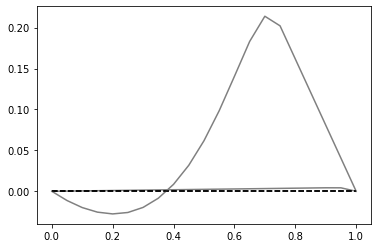

Ti0.05Nb0.95O2.50
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5.0
Ti0.10Nb0.90O2.50
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5.0
Ti0.15Nb0.85O2.50
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5.0
Ti0.20Nb0.80O2.50
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5.0
Ti0.25Nb0.75O2.50
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5.0
Ti0.30Nb0.70O2.50
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5.0
Ti0.35Nb0.65O2.50
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5.0
Ti0.40Nb0.60O2.50
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5.0
Ti0.45Nb0.55O2.50
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5.0
Ti0.50Nb0.50O2.50
Making synthetic formation energy, since MP do

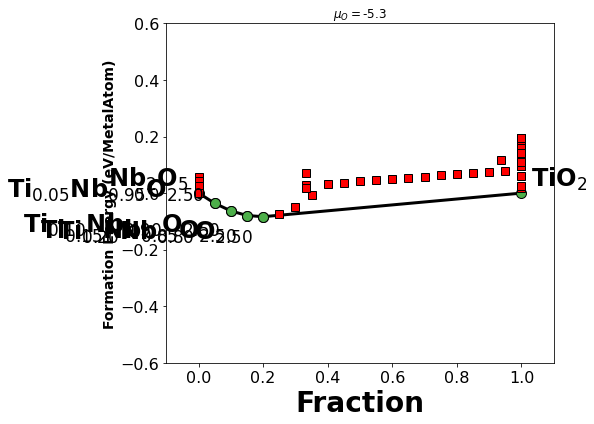

defaultdict(None, {'0.05': array([[0.01193987, 0.01082742, 0.01082742, 0.01082742, 0.01082742,
        0.01082742, 0.01082742, 0.01082742, 0.01082742, 0.01082742,
        0.01082742]]), '0.1': array([[0.00628323, 0.00405831, 0.00405831, 0.00405831, 0.00405831,
        0.00405831, 0.00405831, 0.00405831, 0.00405831, 0.00405831,
        0.00405831]]), '0.15': array([[0.00364946, 0.00031209, 0.00031209, 0.00031209, 0.00031209,
        0.00031209, 0.00031209, 0.00031209, 0.00031209, 0.00031209,
        0.00031209]]), '0.2': array([[4.44982725e-03, 5.07530526e-16, 5.07530526e-16, 5.07530526e-16,
        0.00000000e+00, 5.07530526e-16, 1.01506105e-15, 1.01506105e-15,
        1.01506105e-15, 1.01506105e-15, 1.01506105e-15]]), '0.25': array([[ 0.00915821,  0.00320078,  0.00141507, -0.00037064, -0.00215636,
        -0.00394207, -0.00572779, -0.0075135 , -0.00929922, -0.01108493,
        -0.01287064]]), '0.3': array([[ 0.01831479,  0.01084976,  0.00727833,  0.0037069 ,  0.00013547,
        -0.00

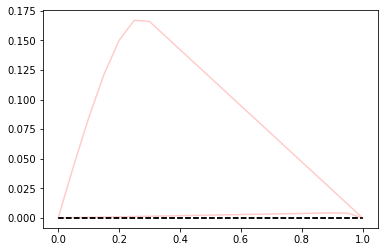

[5, 5, 4, 4]
[2, 2, 1, 2, 2, 2, 2, 1, 2, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[6, 6, 6, 6, 4, 4, 4, 4]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[4, 5, 5, 4]
[2, 1, 2, 2, 2, 2, 2, 2, 1, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[6, 6, 6, 6, 6, 6, 6, 6, 6, 4]
[2, 2, 2, 3, 2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 3, 2, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
V0.05Nb0.95O2.50
V0.10Nb0.90O2.50
V0.15Nb0.85O2.50
V0.20Nb0.80O2.50
V0.25Nb0.75O2.50
V0.30Nb0.70O2.50
V0.35Nb0.65O2.50
V0.40Nb0.60O2.50
V0.45Nb0.55O2.50
V0.50Nb0.50O2.50
V0.55Nb0.45O2.50
V0.60Nb0.40O2.50
V0.65Nb0.35O2.50
V0.70Nb0

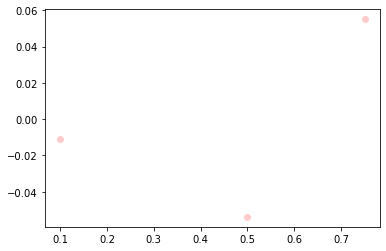

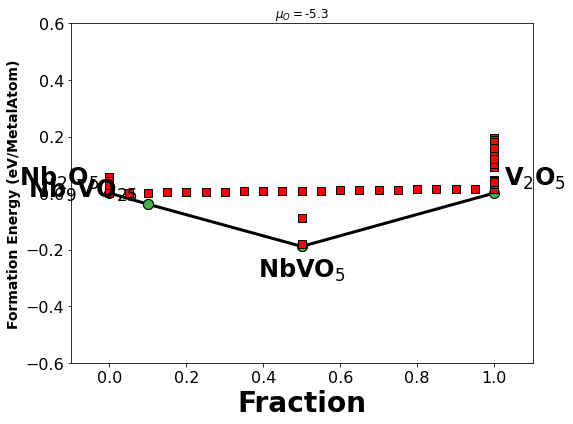

defaultdict(None, {'0.05': array([[0.02580763, 0.02639934, 0.02925648, 0.03211363, 0.03497077,
        0.03782791, 0.04068506, 0.0435422 , 0.04639934, 0.04925648,
        0.05211363]]), '0.1': array([[0.03135102, 0.03253445, 0.03824873, 0.04396302, 0.04967731,
        0.05539159, 0.06110588, 0.06682016, 0.07253445, 0.07824873,
        0.08396302]]), '0.15': array([[0.03689441, 0.03866956, 0.04724098, 0.05581241, 0.06438384,
        0.07295527, 0.0815267 , 0.09009813, 0.09866956, 0.10724098,
        0.11581241]]), '0.2': array([[0.04243781, 0.04480466, 0.05623323, 0.06766181, 0.07909038,
        0.09051895, 0.10194752, 0.11337609, 0.12480466, 0.13623323,
        0.14766181]]), '0.25': array([[0.0479812 , 0.05093977, 0.06522548, 0.0795112 , 0.09379691,
        0.10808263, 0.12236834, 0.13665406, 0.15093977, 0.16522548,
        0.1795112 ]]), '0.3': array([[0.05352459, 0.05707488, 0.07421774, 0.09136059, 0.10850345,
        0.12564631, 0.14278916, 0.15993202, 0.17707488, 0.19421774,
     

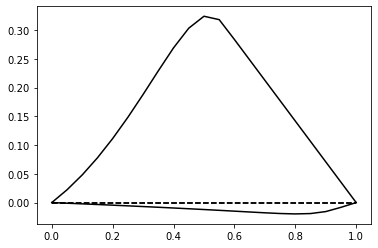

Cr0.05Nb0.95O2.50
Cr0.10Nb0.90O2.50
Cr0.15Nb0.85O2.50
Cr0.20Nb0.80O2.50
Cr0.25Nb0.75O2.50
Cr0.30Nb0.70O2.50
Cr0.35Nb0.65O2.50
Cr0.40Nb0.60O2.50
Cr0.45Nb0.55O2.50
Cr0.50Nb0.50O2.50
Cr0.55Nb0.45O2.50
Cr0.60Nb0.40O2.50
Cr0.65Nb0.35O2.50
Cr0.70Nb0.30O2.50
Cr0.75Nb0.25O2.50
Cr0.80Nb0.20O2.50
Cr0.85Nb0.15O2.50
Cr0.90Nb0.10O2.50
Cr0.95Nb0.05O2.50


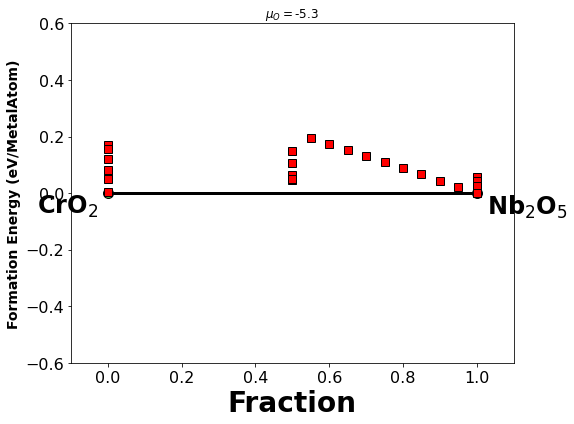

defaultdict(None, {'0.05': array([[0.04258452, 0.03972738, 0.03687023, 0.03401309, 0.03199966,
        0.03342823, 0.03485681, 0.03628538, 0.03771395, 0.03914252,
        0.04057109]]), '0.1': array([[0.06488989, 0.05917561, 0.05346132, 0.04774704, 0.04372018,
        0.04657732, 0.04943447, 0.05229161, 0.05514875, 0.05800589,
        0.06086304]]), '0.15': array([[0.08717828, 0.07860685, 0.07003543, 0.061464  , 0.05542371,
        0.05970943, 0.06399514, 0.06828085, 0.07256657, 0.07685228,
        0.081138  ]]), '0.2': array([[0.10944726, 0.09801869, 0.08659012, 0.07516155, 0.06710783,
        0.07282212, 0.0785364 , 0.08425069, 0.08996497, 0.09567926,
        0.10139355]]), '0.25': array([[0.131694  , 0.11740828, 0.10312257, 0.08883686, 0.07876971,
        0.08591257, 0.09305543, 0.10019828, 0.10734114, 0.114484  ,
        0.12162686]]), '0.3': array([[0.15391522, 0.13677236, 0.11962951, 0.10248665, 0.09040608,
        0.09897751, 0.10754894, 0.11612036, 0.12469179, 0.13326322,
     

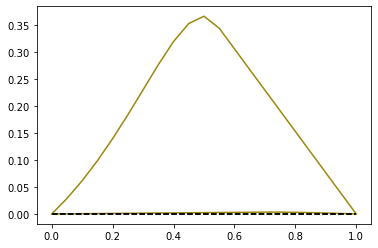

Mn0.05Nb0.95O2.50
Making synthetic formation energy, since MP doesn't have data for Mn in ox state: 5.0
Mn0.10Nb0.90O2.50
Making synthetic formation energy, since MP doesn't have data for Mn in ox state: 5.0
Mn0.15Nb0.85O2.50
Making synthetic formation energy, since MP doesn't have data for Mn in ox state: 5.0
Mn0.20Nb0.80O2.50
Making synthetic formation energy, since MP doesn't have data for Mn in ox state: 5.0
Mn0.25Nb0.75O2.50
Making synthetic formation energy, since MP doesn't have data for Mn in ox state: 5.0
Mn0.30Nb0.70O2.50
Making synthetic formation energy, since MP doesn't have data for Mn in ox state: 5.0
Mn0.35Nb0.65O2.50
Making synthetic formation energy, since MP doesn't have data for Mn in ox state: 5.0
Mn0.40Nb0.60O2.50
Making synthetic formation energy, since MP doesn't have data for Mn in ox state: 5.0
Mn0.45Nb0.55O2.50
Making synthetic formation energy, since MP doesn't have data for Mn in ox state: 5.0
Mn0.50Nb0.50O2.50
Making synthetic formation energy, since MP do

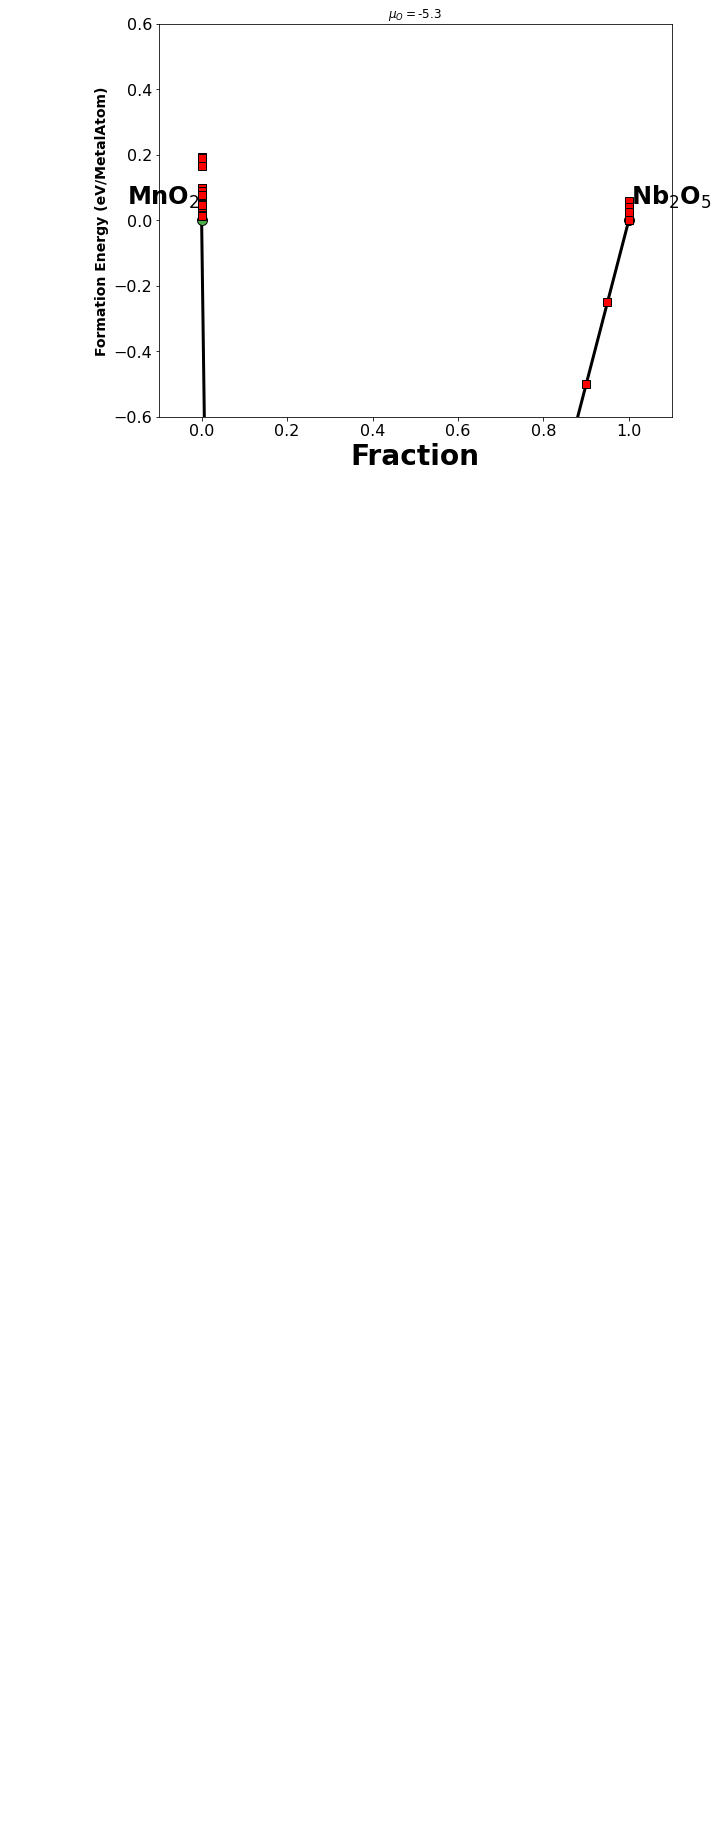

defaultdict(None, {'0.05': array([[0.01938949, 0.01938949, 0.01938949, 0.01938949, 0.01938949,
        0.01938949, 0.01938949, 0.01938949, 0.01938949, 0.01938949,
        0.01938949]]), '0.1': array([[0.01851475, 0.01851475, 0.01851475, 0.01851475, 0.01851475,
        0.01851475, 0.01851475, 0.01851475, 0.01851475, 0.01851475,
        0.01851475]]), '0.15': array([[0.01764001, 0.01764001, 0.01764001, 0.01764001, 0.01764001,
        0.01764001, 0.01764001, 0.01764001, 0.01764001, 0.01764001,
        0.01764001]]), '0.2': array([[0.01676527, 0.01676527, 0.01676527, 0.01676527, 0.01676527,
        0.01676527, 0.01676527, 0.01676527, 0.01676527, 0.01676527,
        0.01676527]]), '0.25': array([[0.01589053, 0.01589053, 0.01589053, 0.01589053, 0.01589053,
        0.01589053, 0.01589053, 0.01589053, 0.01589053, 0.01589053,
        0.01589053]]), '0.3': array([[0.01501578, 0.01501578, 0.01501578, 0.01501578, 0.01501578,
        0.01501578, 0.01501578, 0.01501578, 0.01501578, 0.01501578,
     

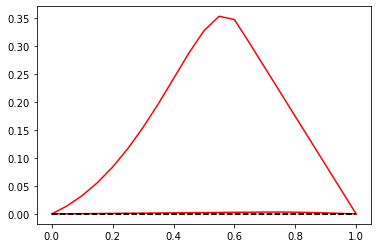

Fe0.05Nb0.95O2.50
Making synthetic formation energy, since MP doesn't have data for Fe in ox state: 5.0
Fe0.10Nb0.90O2.50
Making synthetic formation energy, since MP doesn't have data for Fe in ox state: 5.0
Fe0.15Nb0.85O2.50
Making synthetic formation energy, since MP doesn't have data for Fe in ox state: 5.0
Fe0.20Nb0.80O2.50
Making synthetic formation energy, since MP doesn't have data for Fe in ox state: 5.0
Fe0.25Nb0.75O2.50
Making synthetic formation energy, since MP doesn't have data for Fe in ox state: 5.0
Fe0.30Nb0.70O2.50
Making synthetic formation energy, since MP doesn't have data for Fe in ox state: 5.0
Fe0.35Nb0.65O2.50
Making synthetic formation energy, since MP doesn't have data for Fe in ox state: 5.0
Fe0.40Nb0.60O2.50
Making synthetic formation energy, since MP doesn't have data for Fe in ox state: 5.0
Fe0.45Nb0.55O2.50
Making synthetic formation energy, since MP doesn't have data for Fe in ox state: 5.0
Fe0.50Nb0.50O2.50
Making synthetic formation energy, since MP do

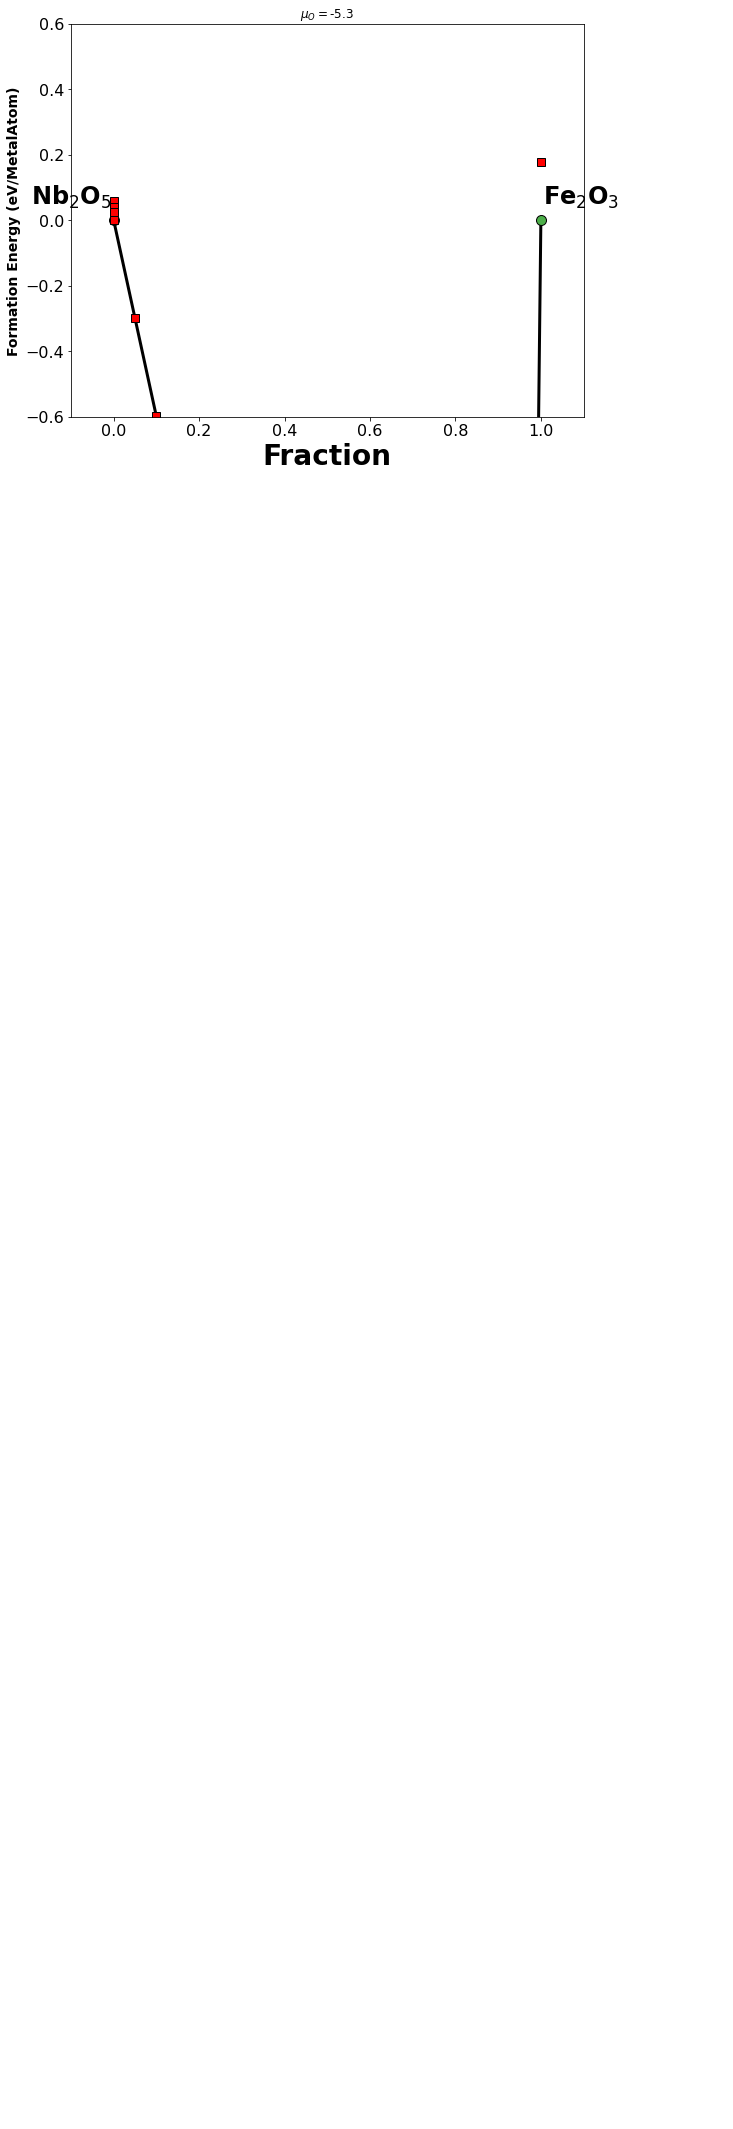

defaultdict(None, {'0.05': array([[0.01938736, 0.01938736, 0.01938736, 0.01938736, 0.01938736,
        0.01938736, 0.01938736, 0.01938736, 0.01938736, 0.01938736,
        0.01938736]]), '0.1': array([[0.01851048, 0.01851048, 0.01851048, 0.01851048, 0.01851048,
        0.01851048, 0.01851048, 0.01851048, 0.01851048, 0.01851048,
        0.01851048]]), '0.15': array([[0.01763361, 0.01763361, 0.01763361, 0.01763361, 0.01763361,
        0.01763361, 0.01763361, 0.01763361, 0.01763361, 0.01763361,
        0.01763361]]), '0.2': array([[0.01675673, 0.01675673, 0.01675673, 0.01675673, 0.01675673,
        0.01675673, 0.01675673, 0.01675673, 0.01675673, 0.01675673,
        0.01675673]]), '0.25': array([[0.01587985, 0.01587985, 0.01587985, 0.01587985, 0.01587985,
        0.01587985, 0.01587985, 0.01587985, 0.01587985, 0.01587985,
        0.01587985]]), '0.3': array([[0.01500298, 0.01500298, 0.01500298, 0.01500298, 0.01500298,
        0.01500298, 0.01500298, 0.01500298, 0.01500298, 0.01500298,
     

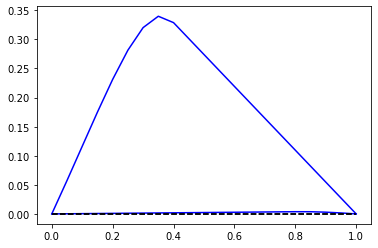

Co0.05Nb0.95O2.50
Making synthetic formation energy, since MP doesn't have data for Co in ox state: 5.0
Co0.10Nb0.90O2.50
Making synthetic formation energy, since MP doesn't have data for Co in ox state: 5.0
Co0.15Nb0.85O2.50
Making synthetic formation energy, since MP doesn't have data for Co in ox state: 5.0
Co0.20Nb0.80O2.50
Making synthetic formation energy, since MP doesn't have data for Co in ox state: 5.0
Co0.25Nb0.75O2.50
Making synthetic formation energy, since MP doesn't have data for Co in ox state: 5.0
Co0.30Nb0.70O2.50
Making synthetic formation energy, since MP doesn't have data for Co in ox state: 5.0
Co0.35Nb0.65O2.50
Making synthetic formation energy, since MP doesn't have data for Co in ox state: 5.0
Co0.40Nb0.60O2.50
Making synthetic formation energy, since MP doesn't have data for Co in ox state: 5.0
Co0.45Nb0.55O2.50
Making synthetic formation energy, since MP doesn't have data for Co in ox state: 5.0
Co0.50Nb0.50O2.50
Making synthetic formation energy, since MP do

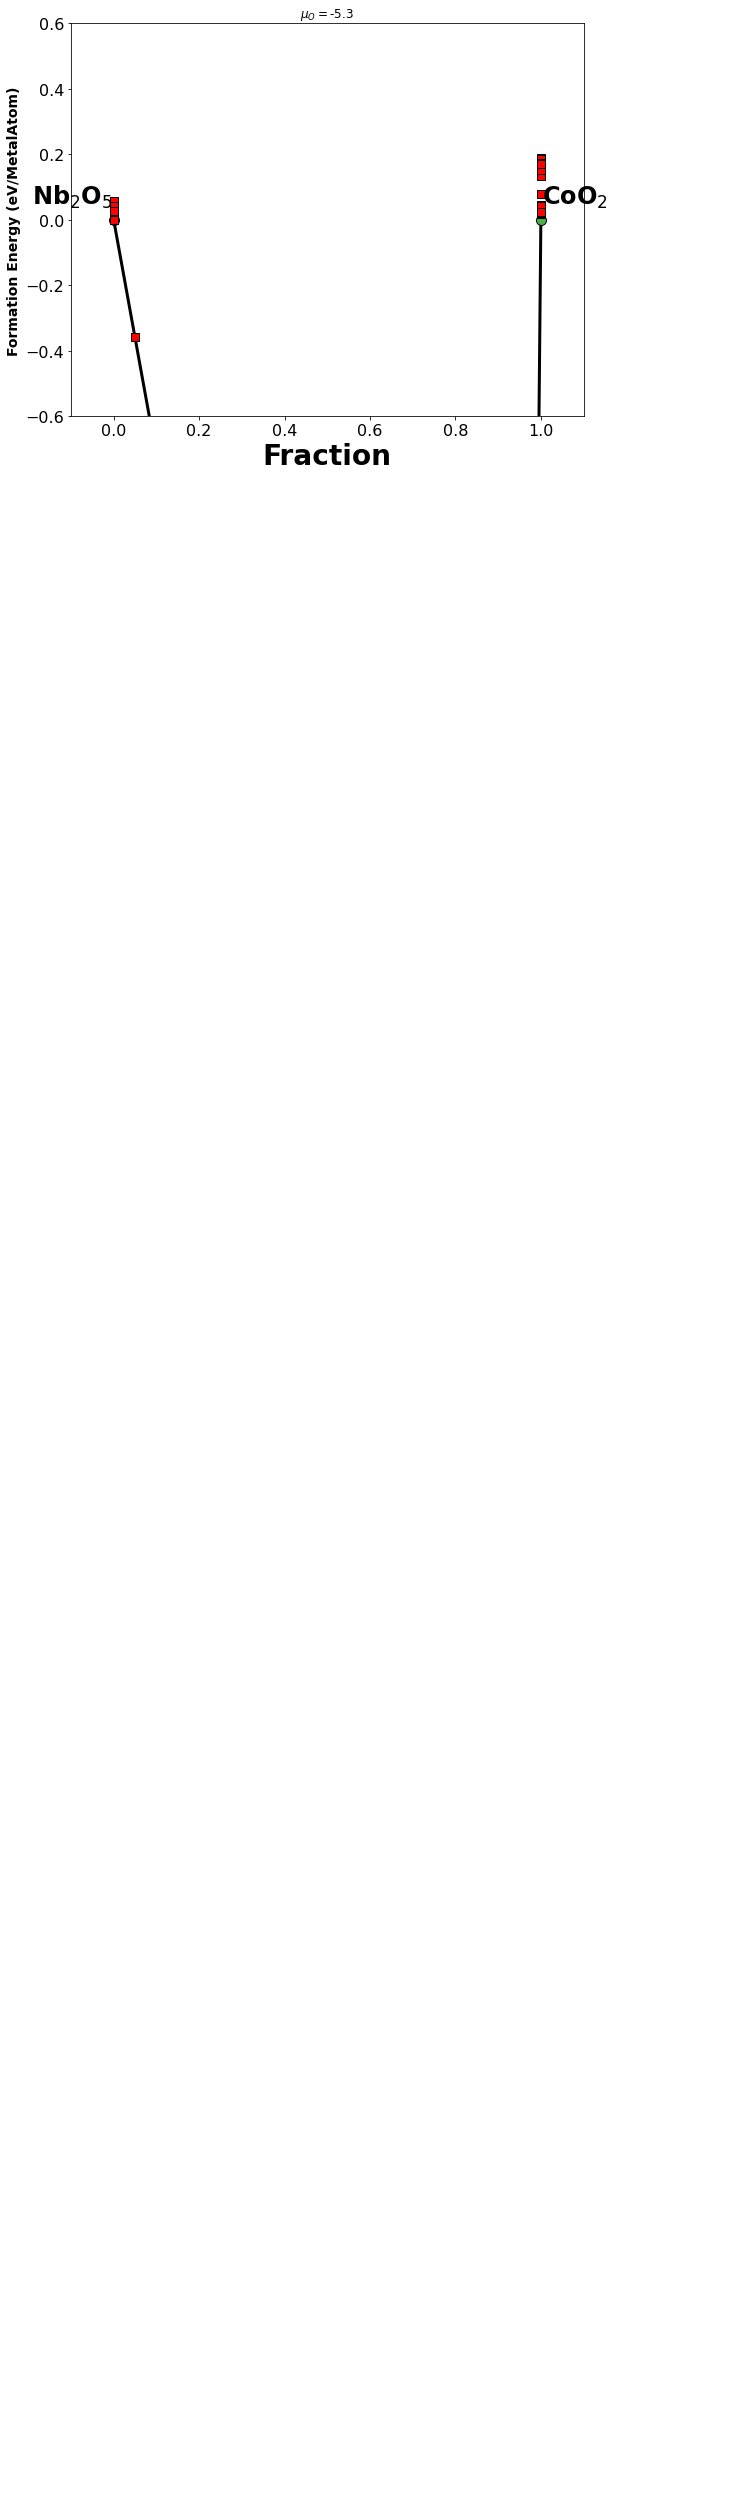

defaultdict(None, {'0.05': array([[0.01934642, 0.01934642, 0.01934642, 0.01934642, 0.01934642,
        0.01934642, 0.01934642, 0.01934642, 0.01934642, 0.01934642,
        0.01934642]]), '0.1': array([[0.0184286, 0.0184286, 0.0184286, 0.0184286, 0.0184286, 0.0184286,
        0.0184286, 0.0184286, 0.0184286, 0.0184286, 0.0184286]]), '0.15': array([[0.01751079, 0.01751079, 0.01751079, 0.01751079, 0.01751079,
        0.01751079, 0.01751079, 0.01751079, 0.01751079, 0.01751079,
        0.01751079]]), '0.2': array([[0.01659297, 0.01659297, 0.01659297, 0.01659297, 0.01659297,
        0.01659297, 0.01659297, 0.01659297, 0.01659297, 0.01659297,
        0.01659297]]), '0.25': array([[0.01567516, 0.01567516, 0.01567516, 0.01567516, 0.01567516,
        0.01567516, 0.01567516, 0.01567516, 0.01567516, 0.01567516,
        0.01567516]]), '0.3': array([[0.01475734, 0.01475734, 0.01475734, 0.01475734, 0.01475734,
        0.01475734, 0.01475734, 0.01475734, 0.01475734, 0.01475734,
        0.01475734]]), '

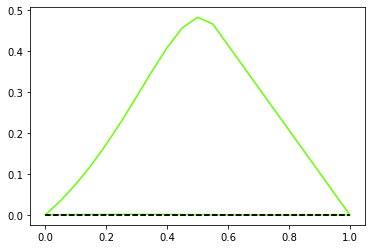

Ni0.05Nb0.95O2.50
Ni0.10Nb0.90O2.50
Ni0.15Nb0.85O2.50
Ni0.20Nb0.80O2.50
Ni0.25Nb0.75O2.50
Ni0.30Nb0.70O2.50
Ni0.35Nb0.65O2.50
Ni0.40Nb0.60O2.50
Ni0.45Nb0.55O2.50
Ni0.50Nb0.50O2.50
Ni0.55Nb0.45O2.50
Ni0.60Nb0.40O2.50
Ni0.65Nb0.35O2.50
Ni0.70Nb0.30O2.50
Ni0.75Nb0.25O2.50
Ni0.80Nb0.20O2.50
Ni0.85Nb0.15O2.50
Ni0.90Nb0.10O2.50
Ni0.95Nb0.05O2.50


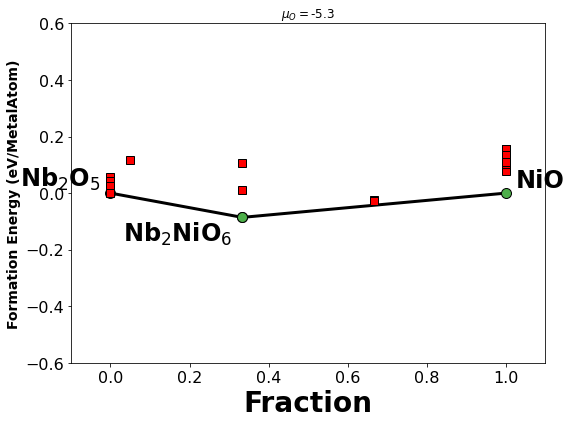

defaultdict(None, {'0.05': array([[0.07752715, 0.07324144, 0.06895572, 0.06467001, 0.06038429,
        0.05609858, 0.05181287, 0.04752715, 0.04324144, 0.03895572,
        0.03467001]]), '0.1': array([[0.13479007, 0.12621864, 0.11764721, 0.10907578, 0.10050435,
        0.09193293, 0.0833615 , 0.07479007, 0.06621864, 0.05764721,
        0.04907578]]), '0.15': array([[0.19205299, 0.17919584, 0.1663387 , 0.15348156, 0.14062442,
        0.12776727, 0.11491013, 0.10205299, 0.08919584, 0.0763387 ,
        0.06348156]]), '0.2': array([[0.24931591, 0.23217305, 0.21503019, 0.19788733, 0.18074448,
        0.16360162, 0.14645876, 0.12931591, 0.11217305, 0.09503019,
        0.07788733]]), '0.25': array([[0.30657051, 0.28514194, 0.26371337, 0.2422848 , 0.22085622,
        0.19942765, 0.17799908, 0.15657051, 0.13514194, 0.11371337,
        0.0922848 ]]), '0.3': array([[0.36355968, 0.33784539, 0.31213111, 0.28641682, 0.26070253,
        0.23498825, 0.20927396, 0.18355968, 0.15784539, 0.13213111,
     

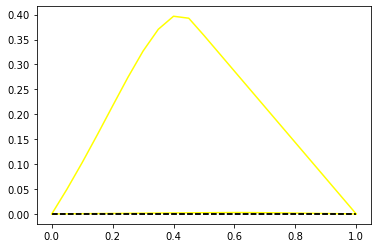

Cu0.05Nb0.95O2.50
Making synthetic formation energy, since MP doesn't have data for Cu in ox state: 5.0
Cu0.10Nb0.90O2.50
Making synthetic formation energy, since MP doesn't have data for Cu in ox state: 5.0
Cu0.15Nb0.85O2.50
Making synthetic formation energy, since MP doesn't have data for Cu in ox state: 5.0
Cu0.20Nb0.80O2.50
Making synthetic formation energy, since MP doesn't have data for Cu in ox state: 5.0
Cu0.25Nb0.75O2.50
Making synthetic formation energy, since MP doesn't have data for Cu in ox state: 5.0
Cu0.30Nb0.70O2.50
Making synthetic formation energy, since MP doesn't have data for Cu in ox state: 5.0
Cu0.35Nb0.65O2.50
Making synthetic formation energy, since MP doesn't have data for Cu in ox state: 5.0
Cu0.40Nb0.60O2.50
Making synthetic formation energy, since MP doesn't have data for Cu in ox state: 5.0
Cu0.45Nb0.55O2.50
Making synthetic formation energy, since MP doesn't have data for Cu in ox state: 5.0
Cu0.50Nb0.50O2.50
Making synthetic formation energy, since MP do

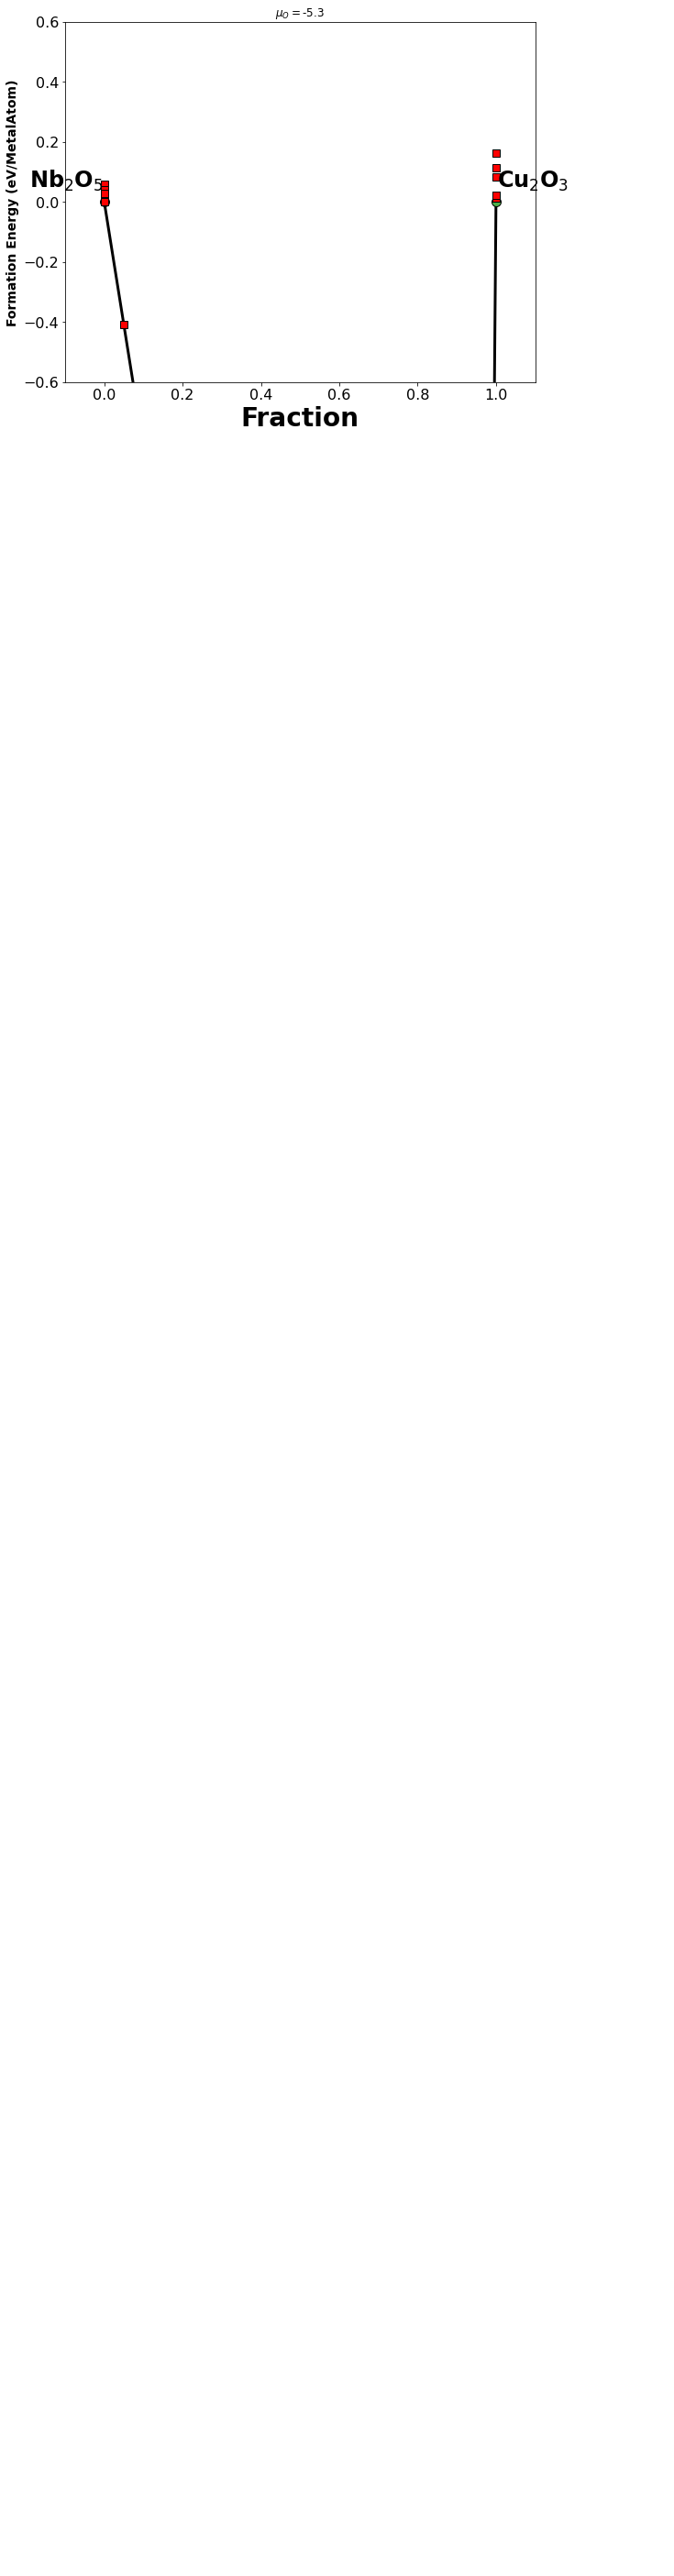

defaultdict(None, {'0.05': array([[0.0194134, 0.0194134, 0.0194134, 0.0194134, 0.0194134, 0.0194134,
        0.0194134, 0.0194134, 0.0194134, 0.0194134, 0.0194134]]), '0.1': array([[0.01856256, 0.01856256, 0.01856256, 0.01856256, 0.01856256,
        0.01856256, 0.01856256, 0.01856256, 0.01856256, 0.01856256,
        0.01856256]]), '0.15': array([[0.01771172, 0.01771172, 0.01771172, 0.01771172, 0.01771172,
        0.01771172, 0.01771172, 0.01771172, 0.01771172, 0.01771172,
        0.01771172]]), '0.2': array([[0.01686089, 0.01686089, 0.01686089, 0.01686089, 0.01686089,
        0.01686089, 0.01686089, 0.01686089, 0.01686089, 0.01686089,
        0.01686089]]), '0.25': array([[0.01601005, 0.01601005, 0.01601005, 0.01601005, 0.01601005,
        0.01601005, 0.01601005, 0.01601005, 0.01601005, 0.01601005,
        0.01601005]]), '0.3': array([[0.01515921, 0.01515921, 0.01515921, 0.01515921, 0.01515921,
        0.01515921, 0.01515921, 0.01515921, 0.01515921, 0.01515921,
        0.01515921]]), '

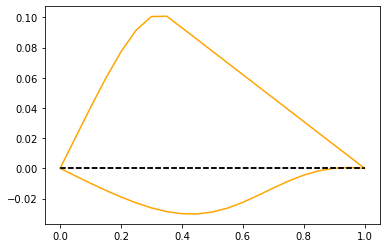

Mo0.05Nb0.95O2.50
Mo0.10Nb0.90O2.50
Mo0.15Nb0.85O2.50
Mo0.20Nb0.80O2.50
Mo0.25Nb0.75O2.50
Mo0.30Nb0.70O2.50
Mo0.35Nb0.65O2.50
Mo0.40Nb0.60O2.50
Mo0.45Nb0.55O2.50
Mo0.50Nb0.50O2.50
Mo0.55Nb0.45O2.50
Mo0.60Nb0.40O2.50
Mo0.65Nb0.35O2.50
Mo0.70Nb0.30O2.50
Mo0.75Nb0.25O2.50
Mo0.80Nb0.20O2.50
Mo0.85Nb0.15O2.50
Mo0.90Nb0.10O2.50
Mo0.95Nb0.05O2.50


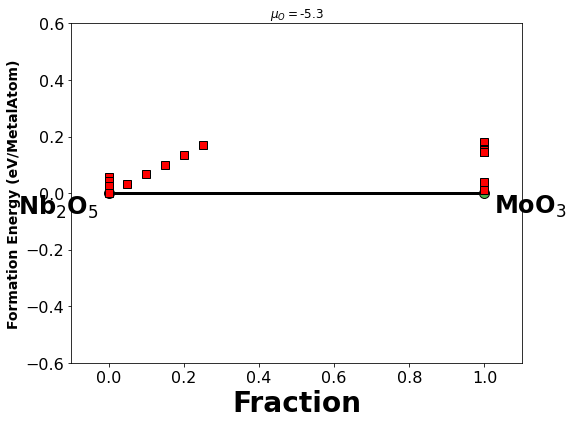

defaultdict(None, {'0.05': array([[0.02556952, 0.02699809, 0.02842666, 0.02985523, 0.0312838 ,
        0.03271238, 0.03414095, 0.03556952, 0.03699809, 0.03842666,
        0.03985523]]), '0.1': array([[0.03099388, 0.03385103, 0.03670817, 0.03956531, 0.04242246,
        0.0452796 , 0.04813674, 0.05099388, 0.05385103, 0.05670817,
        0.05956531]]), '0.15': array([[0.03662013, 0.04090585, 0.04519156, 0.04947728, 0.05376299,
        0.0580487 , 0.06233442, 0.06662013, 0.07090585, 0.07519156,
        0.07947728]]), '0.2': array([[0.0425592 , 0.04827348, 0.05398777, 0.05970206, 0.06541634,
        0.07113063, 0.07684491, 0.0825592 , 0.08827348, 0.09398777,
        0.09970206]]), '0.25': array([[0.04895479, 0.05609765, 0.0632405 , 0.07038336, 0.07752622,
        0.08466907, 0.09181193, 0.09895479, 0.10609765, 0.1132405 ,
        0.12038336]]), '0.3': array([[0.05598491, 0.06455634, 0.07312777, 0.0816992 , 0.09027063,
        0.09884206, 0.10741348, 0.11598491, 0.12455634, 0.13312777,
     

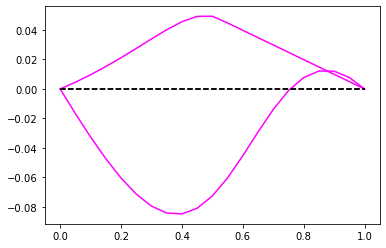

W0.05Nb0.95O2.50
W0.10Nb0.90O2.50
W0.15Nb0.85O2.50
W0.20Nb0.80O2.50
W0.25Nb0.75O2.50
W0.30Nb0.70O2.50
W0.35Nb0.65O2.50
W0.40Nb0.60O2.50
W0.45Nb0.55O2.50
W0.50Nb0.50O2.50
W0.55Nb0.45O2.50
W0.60Nb0.40O2.50
W0.65Nb0.35O2.50
W0.70Nb0.30O2.50
W0.75Nb0.25O2.50
W0.80Nb0.20O2.50
W0.85Nb0.15O2.50
W0.90Nb0.10O2.50
W0.95Nb0.05O2.50


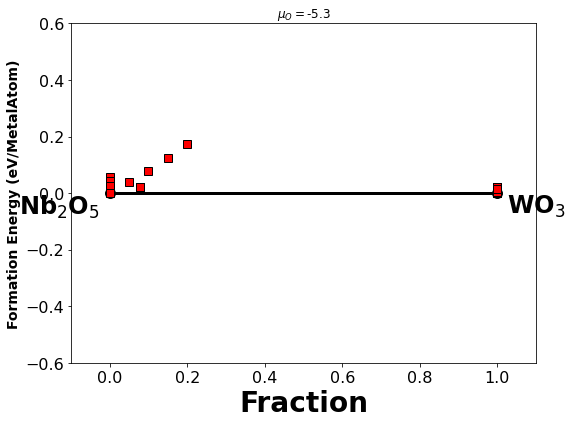

defaultdict(None, {'0.05': array([[0.02704422, 0.02847279, 0.02990136, 0.03132993, 0.0327585 ,
        0.03418708, 0.03561565, 0.03704422, 0.03847279, 0.03990136,
        0.04132993]]), '0.1': array([[0.03465149, 0.03750863, 0.04036577, 0.04322292, 0.04608006,
        0.0489372 , 0.05179434, 0.05465149, 0.05750863, 0.06036577,
        0.06322292]]), '0.15': array([[0.04343794, 0.04772365, 0.05200937, 0.05629508, 0.0605808 ,
        0.06486651, 0.06915222, 0.07343794, 0.07772365, 0.08200937,
        0.08629508]]), '0.2': array([[0.05384928, 0.05956357, 0.06527785, 0.07099214, 0.07670642,
        0.08242071, 0.08813499, 0.09384928, 0.09956357, 0.10527785,
        0.11099214]]), '0.25': array([[0.06642872, 0.07357158, 0.08071444, 0.0878573 , 0.09500015,
        0.10214301, 0.10928587, 0.11642872, 0.12357158, 0.13071444,
        0.1378573 ]]), '0.3': array([[0.08180241, 0.09037384, 0.09894527, 0.1075167 , 0.11608812,
        0.12465955, 0.13323098, 0.14180241, 0.15037384, 0.15894527,
     

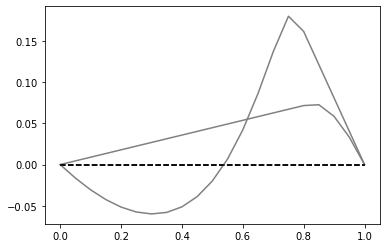

Ti0.05Sb0.95O2.50
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5.0
Ti0.10Sb0.90O2.50
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5.0
Ti0.15Sb0.85O2.50
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5.0
Ti0.20Sb0.80O2.50
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5.0
Ti0.25Sb0.75O2.50
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5.0
Ti0.30Sb0.70O2.50
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5.0
Ti0.35Sb0.65O2.50
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5.0
Ti0.40Sb0.60O2.50
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5.0
Ti0.45Sb0.55O2.50
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5.0
Ti0.50Sb0.50O2.50
Making synthetic formation energy, since MP do

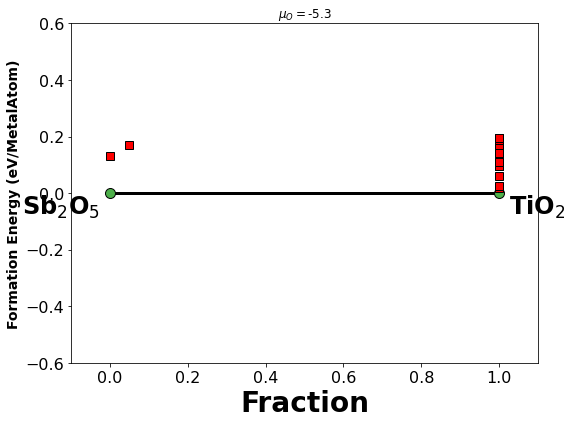

defaultdict(None, {'0.05': array([[0.05191048, 0.05048191, 0.04905334, 0.04762477, 0.0461962 ,
        0.04476763, 0.04333906, 0.04191048, 0.04048191, 0.03905334,
        0.03762477]]), '0.1': array([[0.10593766, 0.10308052, 0.10022338, 0.09736624, 0.09450909,
        0.09165195, 0.08879481, 0.08593766, 0.08308052, 0.08022338,
        0.07736624]]), '0.15': array([[0.16236773, 0.15808202, 0.1537963 , 0.14951059, 0.14522487,
        0.14093916, 0.13665345, 0.13236773, 0.12808202, 0.1237963 ,
        0.11951059]]), '0.2': array([[0.22153882, 0.21582453, 0.21011025, 0.20439596, 0.19868168,
        0.19296739, 0.18725311, 0.18153882, 0.17582453, 0.17011025,
        0.16439596]]), '0.25': array([[0.28385233, 0.27670947, 0.26956661, 0.26242376, 0.2552809 ,
        0.24813804, 0.24099519, 0.23385233, 0.22670947, 0.21956661,
        0.21242376]]), '0.3': array([[0.3497867 , 0.34121527, 0.33264384, 0.32407241, 0.31550098,
        0.30692955, 0.29835812, 0.2897867 , 0.28121527, 0.27264384,
     

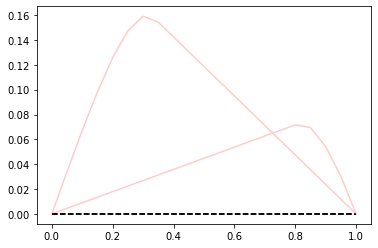

V0.05Sb0.95O2.50
V0.10Sb0.90O2.50
V0.15Sb0.85O2.50
V0.20Sb0.80O2.50
V0.25Sb0.75O2.50
V0.30Sb0.70O2.50
V0.35Sb0.65O2.50
V0.40Sb0.60O2.50
V0.45Sb0.55O2.50
V0.50Sb0.50O2.50
V0.55Sb0.45O2.50
V0.60Sb0.40O2.50
V0.65Sb0.35O2.50
V0.70Sb0.30O2.50
V0.75Sb0.25O2.50
V0.80Sb0.20O2.50
V0.85Sb0.15O2.50
V0.90Sb0.10O2.50
V0.95Sb0.05O2.50


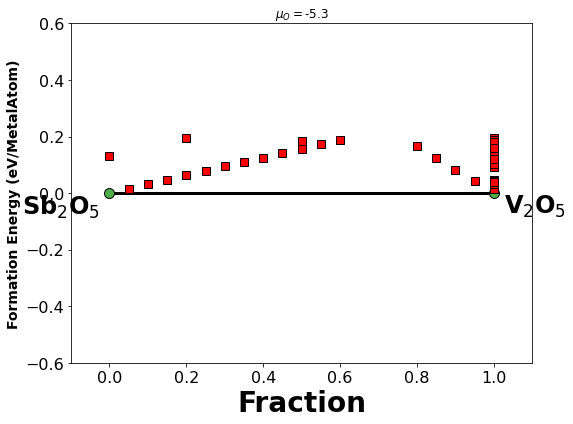

defaultdict(None, {'0.05': array([[0.0107996 , 0.01139132, 0.01424846, 0.0171056 , 0.01996274,
        0.02281989, 0.02567703, 0.02853417, 0.03139132, 0.03424846,
        0.0371056 ]]), '0.1': array([[0.0215992 , 0.02278263, 0.02849692, 0.0342112 , 0.03992549,
        0.04563977, 0.05135406, 0.05706835, 0.06278263, 0.06849692,
        0.0742112 ]]), '0.15': array([[0.0323988 , 0.03417395, 0.04274538, 0.0513168 , 0.05988823,
        0.06845966, 0.07703109, 0.08560252, 0.09417395, 0.10274538,
        0.1113168 ]]), '0.2': array([[0.04319841, 0.04556526, 0.05699383, 0.06842241, 0.07985098,
        0.09127955, 0.10270812, 0.11413669, 0.12556526, 0.13699383,
        0.14842241]]), '0.25': array([[0.05399801, 0.05695658, 0.07124229, 0.08552801, 0.09981372,
        0.11409944, 0.12838515, 0.14267086, 0.15695658, 0.17124229,
        0.18552801]]), '0.3': array([[0.06479761, 0.06834789, 0.08549075, 0.10263361, 0.11977647,
        0.13691932, 0.15406218, 0.17120504, 0.18834789, 0.20549075,
     

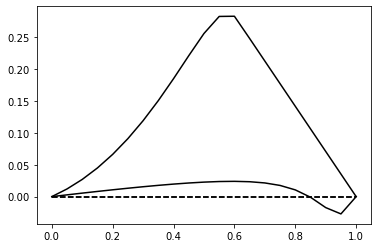

Cr0.05Sb0.95O2.50
Cr0.10Sb0.90O2.50
Cr0.15Sb0.85O2.50
Cr0.20Sb0.80O2.50
Cr0.25Sb0.75O2.50
Cr0.30Sb0.70O2.50
Cr0.35Sb0.65O2.50
Cr0.40Sb0.60O2.50
Cr0.45Sb0.55O2.50
Cr0.50Sb0.50O2.50
Cr0.55Sb0.45O2.50
Cr0.60Sb0.40O2.50
Cr0.65Sb0.35O2.50
Cr0.70Sb0.30O2.50
Cr0.75Sb0.25O2.50
Cr0.80Sb0.20O2.50
Cr0.85Sb0.15O2.50
Cr0.90Sb0.10O2.50
Cr0.95Sb0.05O2.50


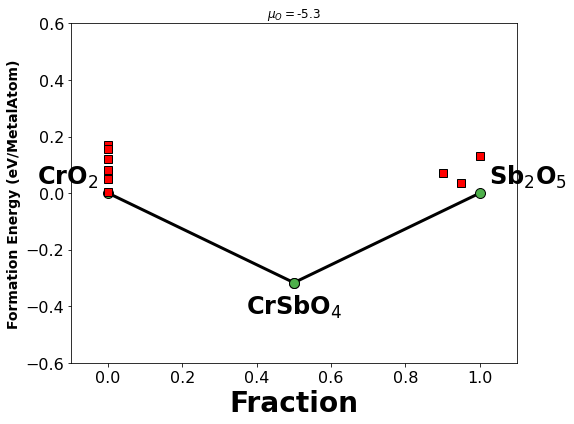

defaultdict(None, {'0.05': array([[0.02723186, 0.02437472, 0.02151758, 0.01866044, 0.01664701,
        0.01807558, 0.01950415, 0.02093272, 0.02236129, 0.02378986,
        0.02521844]]), '0.1': array([[0.05440358, 0.04868929, 0.042975  , 0.03726072, 0.03323386,
        0.036091  , 0.03894815, 0.04180529, 0.04466243, 0.04751958,
        0.05037672]]), '0.15': array([[0.08150384, 0.07293241, 0.06436098, 0.05578955, 0.04974927,
        0.05403498, 0.0583207 , 0.06260641, 0.06689213, 0.07117784,
        0.07546355]]), '0.2': array([[0.10851841, 0.09708984, 0.08566127, 0.0742327 , 0.06617898,
        0.07189327, 0.07760755, 0.08332184, 0.08903612, 0.09475041,
        0.1004647 ]]), '0.25': array([[0.13542906, 0.12114335, 0.10685763, 0.09257192, 0.08250478,
        0.08964763, 0.09679049, 0.10393335, 0.1110762 , 0.11821906,
        0.12536192]]), '0.3': array([[0.16221214, 0.14506929, 0.12792643, 0.11078357, 0.098703  ,
        0.10727443, 0.11584586, 0.12441729, 0.13298872, 0.14156014,
     

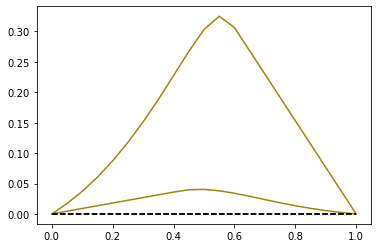

Mn0.05Sb0.95O2.50
Making synthetic formation energy, since MP doesn't have data for Mn in ox state: 5.0
Mn0.10Sb0.90O2.50
Making synthetic formation energy, since MP doesn't have data for Mn in ox state: 5.0
Mn0.15Sb0.85O2.50
Making synthetic formation energy, since MP doesn't have data for Mn in ox state: 5.0
Mn0.20Sb0.80O2.50
Making synthetic formation energy, since MP doesn't have data for Mn in ox state: 5.0
Mn0.25Sb0.75O2.50
Making synthetic formation energy, since MP doesn't have data for Mn in ox state: 5.0
Mn0.30Sb0.70O2.50
Making synthetic formation energy, since MP doesn't have data for Mn in ox state: 5.0
Mn0.35Sb0.65O2.50
Making synthetic formation energy, since MP doesn't have data for Mn in ox state: 5.0
Mn0.40Sb0.60O2.50
Making synthetic formation energy, since MP doesn't have data for Mn in ox state: 5.0
Mn0.45Sb0.55O2.50
Making synthetic formation energy, since MP doesn't have data for Mn in ox state: 5.0
Mn0.50Sb0.50O2.50
Making synthetic formation energy, since MP do

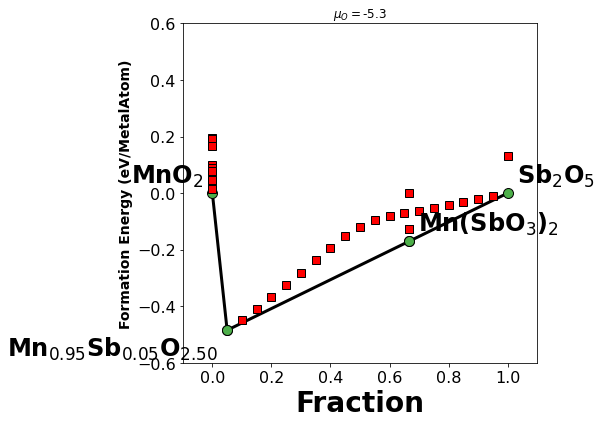

defaultdict(None, {'0.05': array([[0.01341893, 0.00913322, 0.0048475 , 0.00435227, 0.00435227,
        0.00435227, 0.00435227, 0.00435227, 0.00435227, 0.00435227,
        0.00435227]]), '0.1': array([[0.02683786, 0.01826643, 0.009695  , 0.00870454, 0.00870454,
        0.00870454, 0.00870454, 0.00870454, 0.00870454, 0.00870454,
        0.00870454]]), '0.15': array([[0.04025679, 0.02739965, 0.0145425 , 0.01305681, 0.01305681,
        0.01305681, 0.01305681, 0.01305681, 0.01305681, 0.01305681,
        0.01305681]]), '0.2': array([[0.05367572, 0.03653286, 0.01939   , 0.01740908, 0.01740908,
        0.01740908, 0.01740908, 0.01740908, 0.01740908, 0.01740908,
        0.01740908]]), '0.25': array([[0.06709465, 0.04566608, 0.02423751, 0.02176136, 0.02176136,
        0.02176136, 0.02176136, 0.02176136, 0.02176136, 0.02176136,
        0.02176136]]), '0.3': array([[0.08051358, 0.05479929, 0.02908501, 0.02611363, 0.02611363,
        0.02611363, 0.02611363, 0.02611363, 0.02611363, 0.02611363,
     

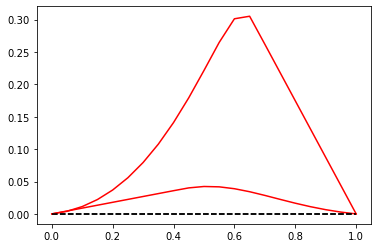

Fe0.05Sb0.95O2.50
Making synthetic formation energy, since MP doesn't have data for Fe in ox state: 5.0
Fe0.10Sb0.90O2.50
Making synthetic formation energy, since MP doesn't have data for Fe in ox state: 5.0
Fe0.15Sb0.85O2.50
Making synthetic formation energy, since MP doesn't have data for Fe in ox state: 5.0
Fe0.20Sb0.80O2.50
Making synthetic formation energy, since MP doesn't have data for Fe in ox state: 5.0
Fe0.25Sb0.75O2.50
Making synthetic formation energy, since MP doesn't have data for Fe in ox state: 5.0
Fe0.30Sb0.70O2.50
Making synthetic formation energy, since MP doesn't have data for Fe in ox state: 5.0
Fe0.35Sb0.65O2.50
Making synthetic formation energy, since MP doesn't have data for Fe in ox state: 5.0
Fe0.40Sb0.60O2.50
Making synthetic formation energy, since MP doesn't have data for Fe in ox state: 5.0
Fe0.45Sb0.55O2.50
Making synthetic formation energy, since MP doesn't have data for Fe in ox state: 5.0
Fe0.50Sb0.50O2.50
Making synthetic formation energy, since MP do

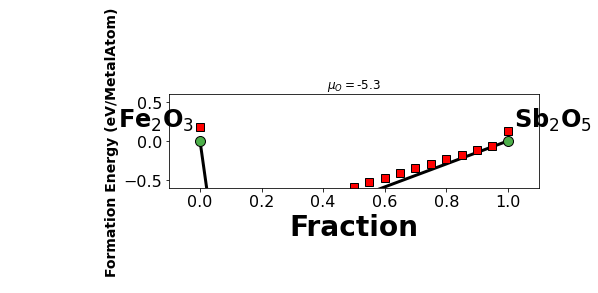

defaultdict(None, {'0.05': array([[0.00390437, 0.00390437, 0.00390437, 0.00390437, 0.00390437,
        0.00390437, 0.00390437, 0.00390437, 0.00390437, 0.00390437,
        0.00390437]]), '0.1': array([[0.00866375, 0.00866375, 0.00866375, 0.00866375, 0.00866375,
        0.00866375, 0.00866375, 0.00866375, 0.00866375, 0.00866375,
        0.00866375]]), '0.15': array([[0.01299563, 0.01299563, 0.01299563, 0.01299563, 0.01299563,
        0.01299563, 0.01299563, 0.01299563, 0.01299563, 0.01299563,
        0.01299563]]), '0.2': array([[0.0173275, 0.0173275, 0.0173275, 0.0173275, 0.0173275, 0.0173275,
        0.0173275, 0.0173275, 0.0173275, 0.0173275, 0.0173275]]), '0.25': array([[0.02165938, 0.02165938, 0.02165938, 0.02165938, 0.02165938,
        0.02165938, 0.02165938, 0.02165938, 0.02165938, 0.02165938,
        0.02165938]]), '0.3': array([[0.02599125, 0.02599125, 0.02599125, 0.02599125, 0.02599125,
        0.02599125, 0.02599125, 0.02599125, 0.02599125, 0.02599125,
        0.02599125]]), '

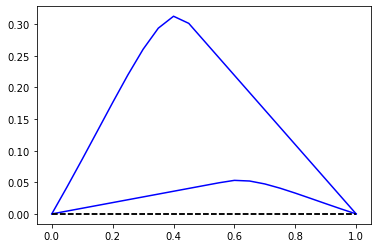

Co0.05Sb0.95O2.50
Making synthetic formation energy, since MP doesn't have data for Co in ox state: 5.0
Co0.10Sb0.90O2.50
Making synthetic formation energy, since MP doesn't have data for Co in ox state: 5.0
Co0.15Sb0.85O2.50
Making synthetic formation energy, since MP doesn't have data for Co in ox state: 5.0
Co0.20Sb0.80O2.50
Making synthetic formation energy, since MP doesn't have data for Co in ox state: 5.0
Co0.25Sb0.75O2.50
Making synthetic formation energy, since MP doesn't have data for Co in ox state: 5.0
Co0.30Sb0.70O2.50
Making synthetic formation energy, since MP doesn't have data for Co in ox state: 5.0
Co0.35Sb0.65O2.50
Making synthetic formation energy, since MP doesn't have data for Co in ox state: 5.0
Co0.40Sb0.60O2.50
Making synthetic formation energy, since MP doesn't have data for Co in ox state: 5.0
Co0.45Sb0.55O2.50
Making synthetic formation energy, since MP doesn't have data for Co in ox state: 5.0
Co0.50Sb0.50O2.50
Making synthetic formation energy, since MP do

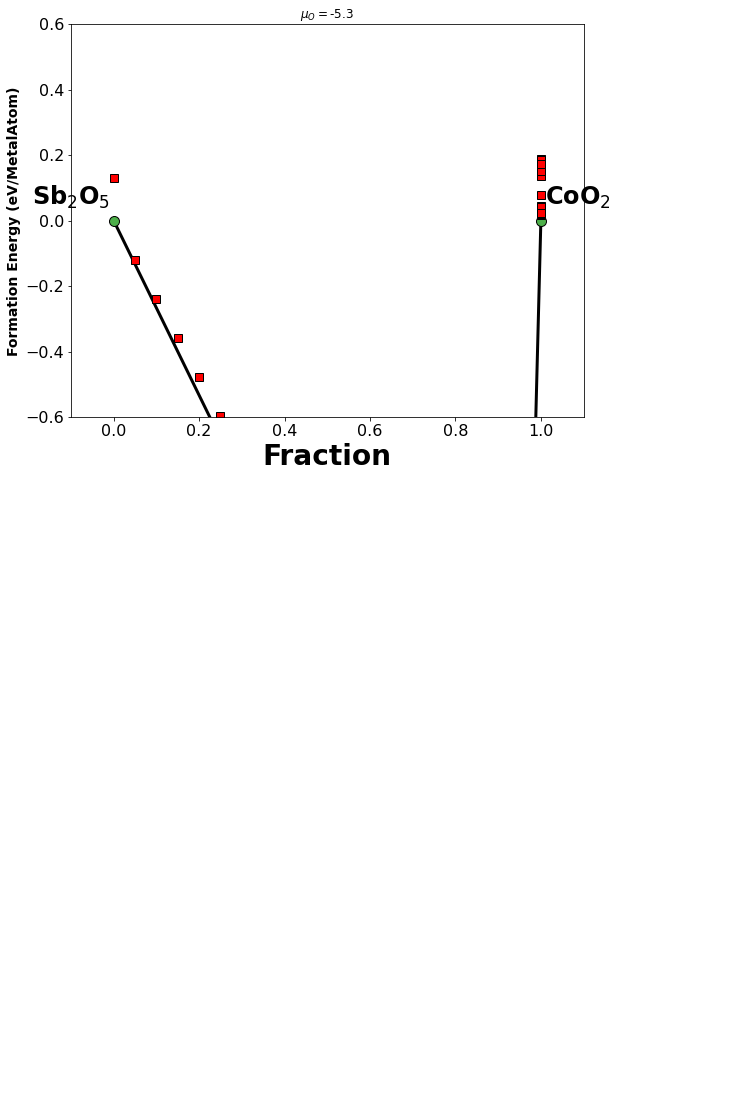

defaultdict(None, {'0.05': array([[0.0040609, 0.0040609, 0.0040609, 0.0040609, 0.0040609, 0.0040609,
        0.0040609, 0.0040609, 0.0040609, 0.0040609, 0.0040609]]), '0.1': array([[0.00812181, 0.00812181, 0.00812181, 0.00812181, 0.00812181,
        0.00812181, 0.00812181, 0.00812181, 0.00812181, 0.00812181,
        0.00812181]]), '0.15': array([[0.01218271, 0.01218271, 0.01218271, 0.01218271, 0.01218271,
        0.01218271, 0.01218271, 0.01218271, 0.01218271, 0.01218271,
        0.01218271]]), '0.2': array([[0.01624362, 0.01624362, 0.01624362, 0.01624362, 0.01624362,
        0.01624362, 0.01624362, 0.01624362, 0.01624362, 0.01624362,
        0.01624362]]), '0.25': array([[0.02030452, 0.02030452, 0.02030452, 0.02030452, 0.02030452,
        0.02030452, 0.02030452, 0.02030452, 0.02030452, 0.02030452,
        0.02030452]]), '0.3': array([[0.02436543, 0.02436543, 0.02436543, 0.02436543, 0.02436543,
        0.02436543, 0.02436543, 0.02436543, 0.02436543, 0.02436543,
        0.02436543]]), '

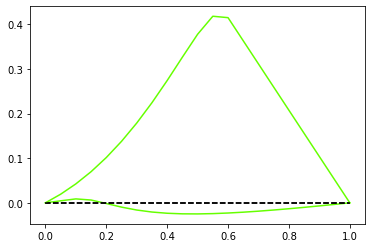

Ni0.05Sb0.95O2.50
Ni0.10Sb0.90O2.50
Ni0.15Sb0.85O2.50
Ni0.20Sb0.80O2.50
Ni0.25Sb0.75O2.50
Ni0.30Sb0.70O2.50
Ni0.35Sb0.65O2.50
Ni0.40Sb0.60O2.50
Ni0.45Sb0.55O2.50
Ni0.50Sb0.50O2.50
Ni0.55Sb0.45O2.50
Ni0.60Sb0.40O2.50
Ni0.65Sb0.35O2.50
Ni0.70Sb0.30O2.50
Ni0.75Sb0.25O2.50
Ni0.80Sb0.20O2.50
Ni0.85Sb0.15O2.50
Ni0.90Sb0.10O2.50
Ni0.95Sb0.05O2.50


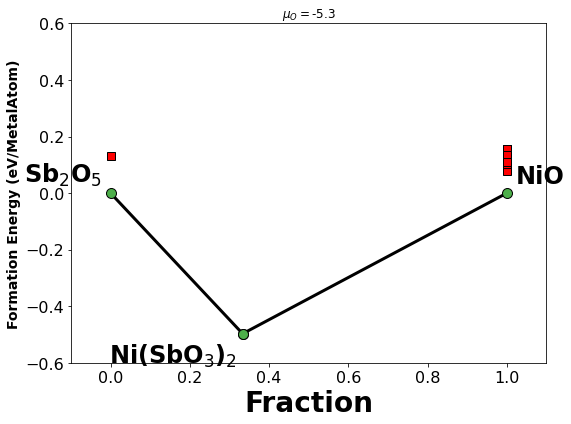

defaultdict(None, {'0.05': array([[0.06810871, 0.063823  , 0.05953729, 0.05525157, 0.05096586,
        0.04668014, 0.04239443, 0.03810871, 0.033823  , 0.02953729,
        0.02525157]]), '0.1': array([[0.13603179, 0.12746036, 0.11888893, 0.1103175 , 0.10174607,
        0.09317464, 0.08460321, 0.07603179, 0.06746036, 0.05888893,
        0.0503175 ]]), '0.15': array([[0.1971172 , 0.18426006, 0.17140292, 0.15854577, 0.14568863,
        0.13283149, 0.11997434, 0.1071172 , 0.09426006, 0.08140292,
        0.06854577]]), '0.2': array([[0.25299375, 0.23585089, 0.21870803, 0.20156517, 0.18442232,
        0.16727946, 0.1501366 , 0.13299375, 0.11585089, 0.09870803,
        0.08156517]]), '0.25': array([[0.30850487, 0.2870763 , 0.26564773, 0.24421916, 0.22279058,
        0.20136201, 0.17993344, 0.15850487, 0.1370763 , 0.11564773,
        0.09421916]]), '0.3': array([[0.36563558, 0.3399213 , 0.31420701, 0.28849273, 0.26277844,
        0.23706415, 0.21134987, 0.18563558, 0.1599213 , 0.13420701,
     

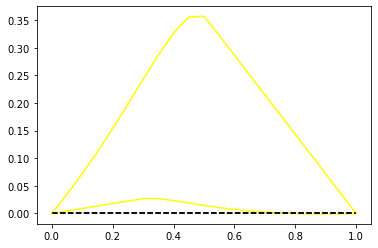

Cu0.05Sb0.95O2.50
Making synthetic formation energy, since MP doesn't have data for Cu in ox state: 5.0
Cu0.10Sb0.90O2.50
Making synthetic formation energy, since MP doesn't have data for Cu in ox state: 5.0
Cu0.15Sb0.85O2.50
Making synthetic formation energy, since MP doesn't have data for Cu in ox state: 5.0
Cu0.20Sb0.80O2.50
Making synthetic formation energy, since MP doesn't have data for Cu in ox state: 5.0
Cu0.25Sb0.75O2.50
Making synthetic formation energy, since MP doesn't have data for Cu in ox state: 5.0
Cu0.30Sb0.70O2.50
Making synthetic formation energy, since MP doesn't have data for Cu in ox state: 5.0
Cu0.35Sb0.65O2.50
Making synthetic formation energy, since MP doesn't have data for Cu in ox state: 5.0
Cu0.40Sb0.60O2.50
Making synthetic formation energy, since MP doesn't have data for Cu in ox state: 5.0
Cu0.45Sb0.55O2.50
Making synthetic formation energy, since MP doesn't have data for Cu in ox state: 5.0
Cu0.50Sb0.50O2.50
Making synthetic formation energy, since MP do

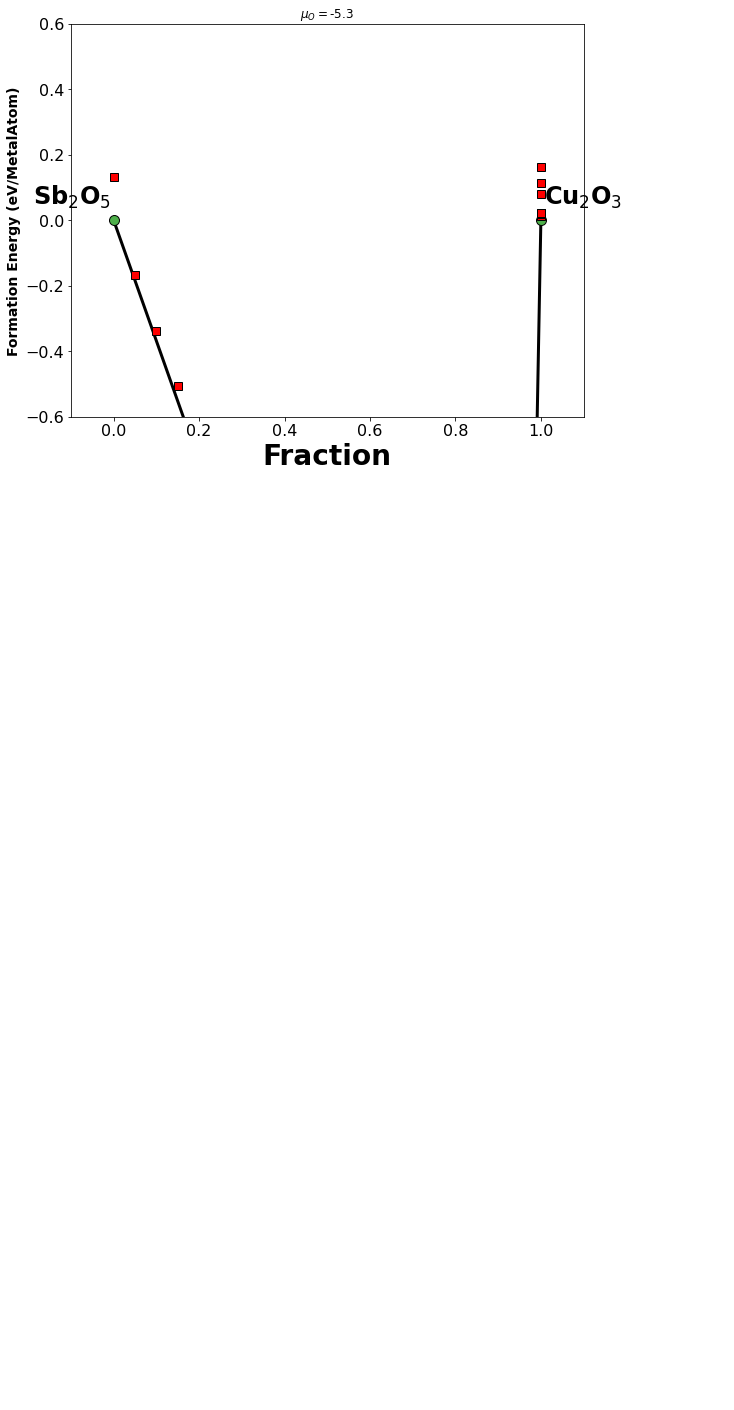

defaultdict(None, {'0.05': array([[0.00452478, 0.00452478, 0.00452478, 0.00452478, 0.00452478,
        0.00452478, 0.00452478, 0.00452478, 0.00452478, 0.00452478,
        0.00452478]]), '0.1': array([[0.00904955, 0.00904955, 0.00904955, 0.00904955, 0.00904955,
        0.00904955, 0.00904955, 0.00904955, 0.00904955, 0.00904955,
        0.00904955]]), '0.15': array([[0.01357433, 0.01357433, 0.01357433, 0.01357433, 0.01357433,
        0.01357433, 0.01357433, 0.01357433, 0.01357433, 0.01357433,
        0.01357433]]), '0.2': array([[0.0180991, 0.0180991, 0.0180991, 0.0180991, 0.0180991, 0.0180991,
        0.0180991, 0.0180991, 0.0180991, 0.0180991, 0.0180991]]), '0.25': array([[0.02262388, 0.02262388, 0.02262388, 0.02262388, 0.02262388,
        0.02262388, 0.02262388, 0.02262388, 0.02262388, 0.02262388,
        0.02262388]]), '0.3': array([[0.02710455, 0.02710455, 0.02710455, 0.02710455, 0.02710455,
        0.02710455, 0.02710455, 0.02710455, 0.02710455, 0.02710455,
        0.02710455]]), '

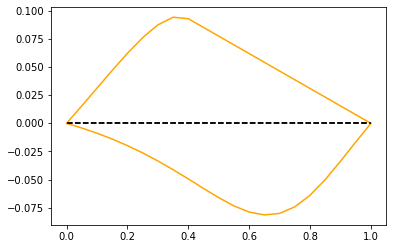

Mo0.05Sb0.95O2.50
Mo0.10Sb0.90O2.50
Mo0.15Sb0.85O2.50
Mo0.20Sb0.80O2.50
Mo0.25Sb0.75O2.50
Mo0.30Sb0.70O2.50
Mo0.35Sb0.65O2.50
Mo0.40Sb0.60O2.50
Mo0.45Sb0.55O2.50
Mo0.50Sb0.50O2.50
Mo0.55Sb0.45O2.50
Mo0.60Sb0.40O2.50
Mo0.65Sb0.35O2.50
Mo0.70Sb0.30O2.50
Mo0.75Sb0.25O2.50
Mo0.80Sb0.20O2.50
Mo0.85Sb0.15O2.50
Mo0.90Sb0.10O2.50
Mo0.95Sb0.05O2.50


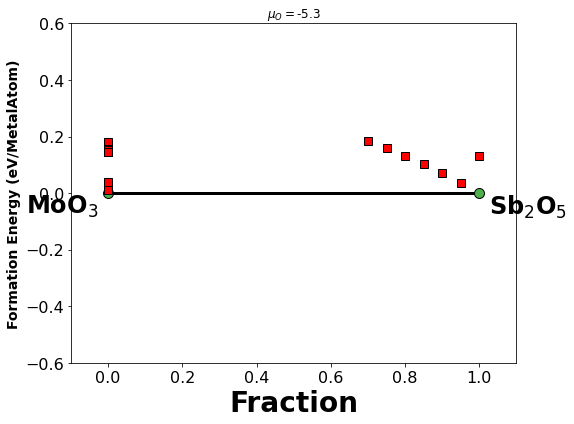

defaultdict(None, {'0.05': array([[0.00721998, 0.00864855, 0.01007713, 0.0115057 , 0.01293427,
        0.01436284, 0.01579141, 0.01721998, 0.01864855, 0.02007713,
        0.0215057 ]]), '0.1': array([[0.0139203 , 0.01677745, 0.01963459, 0.02249173, 0.02534887,
        0.02820602, 0.03106316, 0.0339203 , 0.03677745, 0.03963459,
        0.04249173]]), '0.15': array([[0.02004677, 0.02433248, 0.0286182 , 0.03290391, 0.03718962,
        0.04147534, 0.04576105, 0.05004677, 0.05433248, 0.0586182 ,
        0.06290391]]), '0.2': array([[0.02555026, 0.03126455, 0.03697883, 0.04269312, 0.0484074 ,
        0.05412169, 0.05983597, 0.06555026, 0.07126455, 0.07697883,
        0.08269312]]), '0.25': array([[0.03039585, 0.03753871, 0.04468157, 0.05182442, 0.05896728,
        0.06611014, 0.07325299, 0.08039585, 0.08753871, 0.09468157,
        0.10182442]]), '0.3': array([[0.03457782, 0.04314925, 0.05172068, 0.0602921 , 0.06886353,
        0.07743496, 0.08600639, 0.09457782, 0.10314925, 0.11172068,
     

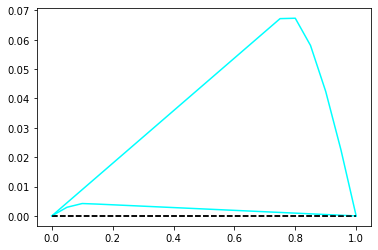

Nb0.05Sb0.95O2.50
Nb0.10Sb0.90O2.50
Nb0.15Sb0.85O2.50
Nb0.20Sb0.80O2.50
Nb0.25Sb0.75O2.50
Nb0.30Sb0.70O2.50
Nb0.35Sb0.65O2.50
Nb0.40Sb0.60O2.50
Nb0.45Sb0.55O2.50
Nb0.50Sb0.50O2.50
Nb0.55Sb0.45O2.50
Nb0.60Sb0.40O2.50
Nb0.65Sb0.35O2.50
Nb0.70Sb0.30O2.50
Nb0.75Sb0.25O2.50
Nb0.80Sb0.20O2.50
Nb0.85Sb0.15O2.50
Nb0.90Sb0.10O2.50
Nb0.95Sb0.05O2.50


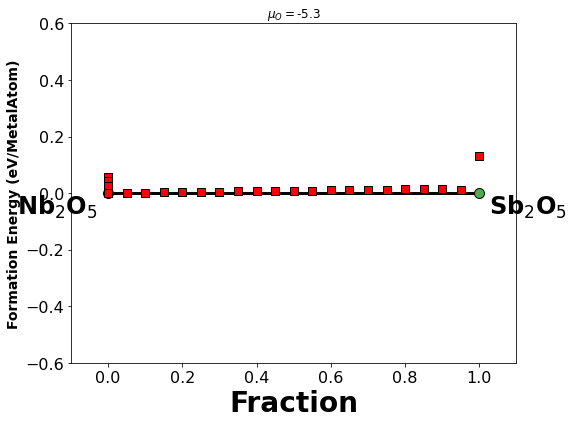

defaultdict(None, {'0.05': array([[0.0039642, 0.0039642, 0.0039642, 0.0039642, 0.0039642, 0.0039642,
        0.0039642, 0.0039642, 0.0039642, 0.0039642, 0.0039642]]), '0.1': array([[0.00624494, 0.00624494, 0.00624494, 0.00624494, 0.00624494,
        0.00624494, 0.00624494, 0.00624494, 0.00624494, 0.00624494,
        0.00624494]]), '0.15': array([[0.00706469, 0.00706469, 0.00706469, 0.00706469, 0.00706469,
        0.00706469, 0.00706469, 0.00706469, 0.00706469, 0.00706469,
        0.00706469]]), '0.2': array([[0.00784113, 0.00784113, 0.00784113, 0.00784113, 0.00784113,
        0.00784113, 0.00784113, 0.00784113, 0.00784113, 0.00784113,
        0.00784113]]), '0.25': array([[0.00861758, 0.00861758, 0.00861758, 0.00861758, 0.00861758,
        0.00861758, 0.00861758, 0.00861758, 0.00861758, 0.00861758,
        0.00861758]]), '0.3': array([[0.00939402, 0.00939402, 0.00939402, 0.00939402, 0.00939402,
        0.00939402, 0.00939402, 0.00939402, 0.00939402, 0.00939402,
        0.00939402]]), '

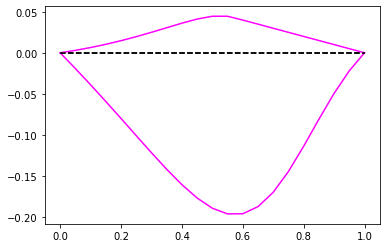

[2, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
W0.05Sb0.95O2.50
W0.10Sb0.90O2.50
W0.15Sb0.85O2.50
W0.20Sb0.80O2.50
W0.25Sb0.75O2.50
W0.30Sb0.70O2.50
W0.35Sb0.65O2.50
W0.40Sb0.60O2.50
W0.45Sb0.55O2.50
W0.50Sb0.50O2.50
W0.55Sb0.45O2.50
W0.60Sb0.40O2.50
W0.65Sb0.35O2.50
W0.70Sb0.30O2.50
W0.75Sb0.25O2.50
W0.80Sb0.20O2.50
W0.85Sb0.15O2.50
W0.90Sb0.10O2.50
W0.95Sb0.05O2.50


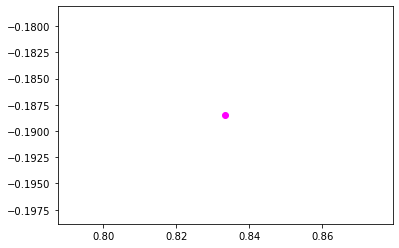

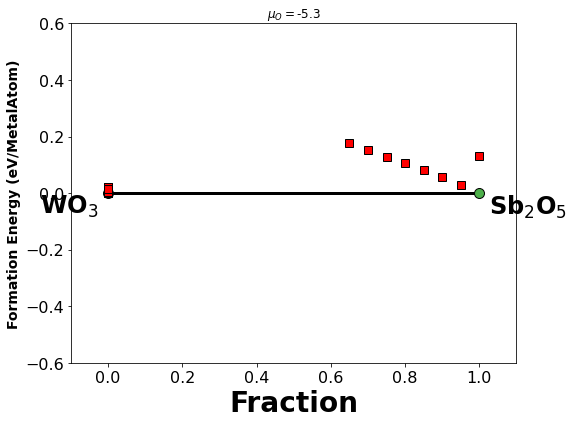

defaultdict(None, {'0.05': array([[0.00530233, 0.0067309 , 0.00815947, 0.00958804, 0.01101661,
        0.01244519, 0.01387376, 0.01530233, 0.0167309 , 0.01815947,
        0.01958804]]), '0.1': array([[0.01003454, 0.01289168, 0.01574883, 0.01860597, 0.02146311,
        0.02432025, 0.0271774 , 0.03003454, 0.03289168, 0.03574883,
        0.03860597]]), '0.15': array([[0.01424981, 0.01853553, 0.02282124, 0.02710695, 0.03139267,
        0.03567838, 0.0399641 , 0.04424981, 0.04853553, 0.05282124,
        0.05710695]]), '0.2': array([[0.01806079, 0.02377508, 0.02948936, 0.03520365, 0.04091794,
        0.04663222, 0.05234651, 0.05806079, 0.06377508, 0.06948936,
        0.07520365]]), '0.25': array([[0.02166966, 0.02881252, 0.03595538, 0.04309824, 0.05024109,
        0.05738395, 0.06452681, 0.07166966, 0.07881252, 0.08595538,
        0.09309824]]), '0.3': array([[0.02540918, 0.03398061, 0.04255203, 0.05112346, 0.05969489,
        0.06826632, 0.07683775, 0.08540918, 0.09398061, 0.10255203,
     

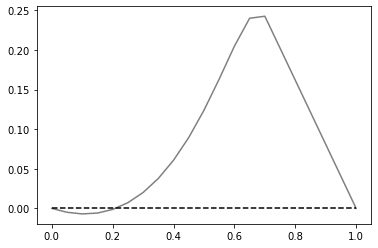

Ti0.05Ta0.95O2.50
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5.0
Ti0.10Ta0.90O2.50
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5.0
Ti0.15Ta0.85O2.50
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5.0
Ti0.20Ta0.80O2.50
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5.0
Ti0.25Ta0.75O2.50
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5.0
Ti0.30Ta0.70O2.50
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5.0
Ti0.35Ta0.65O2.50
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5.0
Ti0.40Ta0.60O2.50
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5.0
Ti0.45Ta0.55O2.50
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5.0
Ti0.50Ta0.50O2.50
Making synthetic formation energy, since MP do

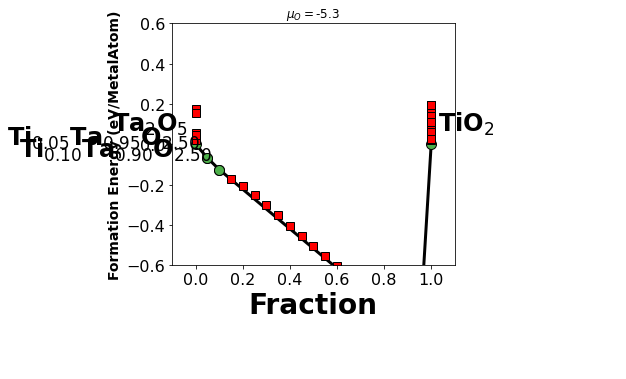

defaultdict(None, {'0.05': array([[0.10682881, 0.10682881, 0.10682881, 0.10682881, 0.10682881,
        0.10682881, 0.10682881, 0.10682881, 0.10682881, 0.10682881,
        0.10682881]]), '0.1': array([[0.09855677, 0.09855677, 0.09855677, 0.09855677, 0.09855677,
        0.09855677, 0.09855677, 0.09855677, 0.09855677, 0.09855677,
        0.09855677]]), '0.15': array([[0.09342734, 0.09342734, 0.09342734, 0.09342734, 0.09342734,
        0.09342734, 0.09342734, 0.09342734, 0.09342734, 0.09342734,
        0.09342734]]), '0.2': array([[0.09180555, 0.09180555, 0.09180555, 0.09180555, 0.09180555,
        0.09180555, 0.09180555, 0.09180555, 0.09180555, 0.09180555,
        0.09180555]]), '0.25': array([[0.08688847, 0.08688847, 0.08688847, 0.08688847, 0.08688847,
        0.08688847, 0.08688847, 0.08688847, 0.08688847, 0.08688847,
        0.08688847]]), '0.3': array([[0.08068215, 0.08068215, 0.08068215, 0.08068215, 0.08068215,
        0.08068215, 0.08068215, 0.08068215, 0.08068215, 0.08068215,
     

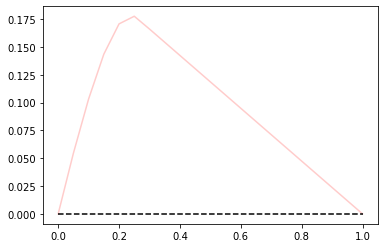

[6, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[6, 6, 6, 6, 4, 4, 4, 4]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[4, 6, 6, 6, 6, 6, 6, 6, 6, 6]
[2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
V0.05Ta0.95O2.50
V0.10Ta0.90O2.50
V0.15Ta0.85O2.50
V0.20Ta0.80O2.50
V0.25Ta0.75O2.50
V0.30Ta0.70O2.50
V0.35Ta0.65O2.50
V0.40Ta0.60O2.50
V0.45Ta0.55O2.50
V0.50Ta0.50O2.50
V0.55Ta0.45O2.50
V0.60Ta0.40O2.50
V0.65Ta0.35O2.50
V0.70Ta0.30O2.50
V0.75Ta0.25O2.50
V0.80Ta0.20O2.50
V0.85Ta0.15O2.50
V0.90Ta0.10O2.50
V0.95Ta0.05O2.50


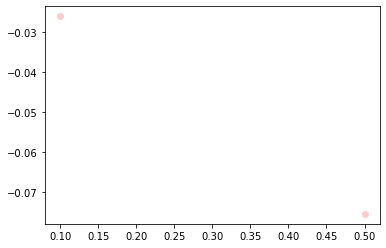

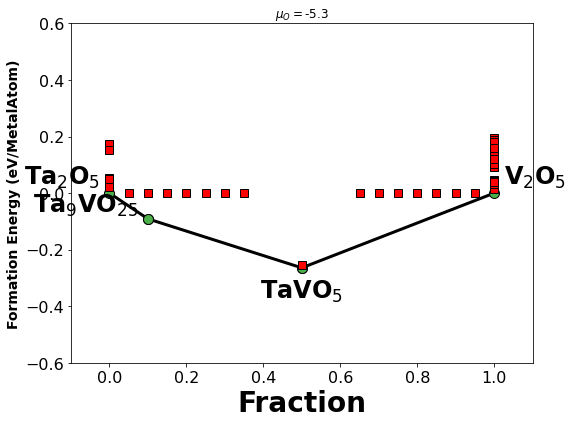

defaultdict(None, {'0.05': array([[0.1183439 , 0.11893562, 0.12179276, 0.1246499 , 0.12750705,
        0.13036419, 0.13322133, 0.13607848, 0.13893562, 0.14179276,
        0.1446499 ]]), '0.1': array([[0.11876774, 0.11995117, 0.12566545, 0.13137974, 0.13709402,
        0.14280831, 0.1485226 , 0.15423688, 0.15995117, 0.16566545,
        0.17137974]]), '0.15': array([[0.11919157, 0.12096671, 0.12953814, 0.13810957, 0.146681  ,
        0.15525243, 0.16382386, 0.17239529, 0.18096671, 0.18953814,
        0.19810957]]), '0.2': array([[0.1196154 , 0.12198226, 0.13341083, 0.1448394 , 0.15626798,
        0.16769655, 0.17912512, 0.19055369, 0.20198226, 0.21341083,
        0.2248394 ]]), '0.25': array([[0.12003924, 0.12299781, 0.13728352, 0.15156924, 0.16585495,
        0.18014067, 0.19442638, 0.2087121 , 0.22299781, 0.23728352,
        0.25156924]]), '0.3': array([[0.12046307, 0.12401336, 0.14115621, 0.15829907, 0.17544193,
        0.19258479, 0.20972764, 0.2268705 , 0.24401336, 0.26115621,
     

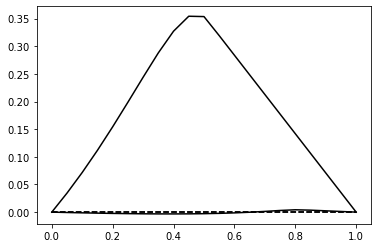

Cr0.05Ta0.95O2.50
Cr0.10Ta0.90O2.50
Cr0.15Ta0.85O2.50
Cr0.20Ta0.80O2.50
Cr0.25Ta0.75O2.50
Cr0.30Ta0.70O2.50
Cr0.35Ta0.65O2.50
Cr0.40Ta0.60O2.50
Cr0.45Ta0.55O2.50
Cr0.50Ta0.50O2.50
Cr0.55Ta0.45O2.50
Cr0.60Ta0.40O2.50
Cr0.65Ta0.35O2.50
Cr0.70Ta0.30O2.50
Cr0.75Ta0.25O2.50
Cr0.80Ta0.20O2.50
Cr0.85Ta0.15O2.50
Cr0.90Ta0.10O2.50
Cr0.95Ta0.05O2.50


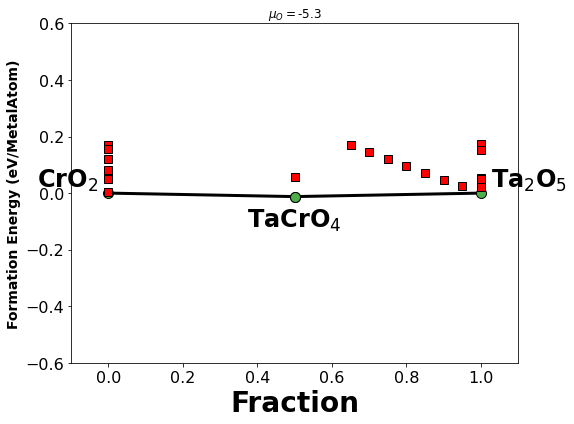

defaultdict(None, {'0.05': array([[0.13580396, 0.13294681, 0.13008967, 0.12723253, 0.1252191 ,
        0.12664767, 0.12807624, 0.12950481, 0.13093338, 0.13236196,
        0.13379053]]), '0.1': array([[0.15374095, 0.14802666, 0.14231237, 0.13659809, 0.13257123,
        0.13542837, 0.13828552, 0.14114266, 0.1439998 , 0.14685695,
        0.14971409]]), '0.15': array([[0.17173926, 0.16316784, 0.15459641, 0.14602498, 0.13998469,
        0.14427041, 0.14855612, 0.15284184, 0.15712755, 0.16141326,
        0.16569898]]), '0.2': array([[0.18980885, 0.17838028, 0.16695171, 0.15552314, 0.14746942,
        0.15318371, 0.158898  , 0.16461228, 0.17032657, 0.17604085,
        0.18175514]]), '0.25': array([[0.20796181, 0.19367609, 0.17939038, 0.16510466, 0.15503752,
        0.16218038, 0.16932323, 0.17646609, 0.18360895, 0.19075181,
        0.19789466]]), '0.3': array([[0.22621294, 0.20907008, 0.19192722, 0.17478436, 0.16270379,
        0.17127522, 0.17984665, 0.18841808, 0.19698951, 0.20556094,
     

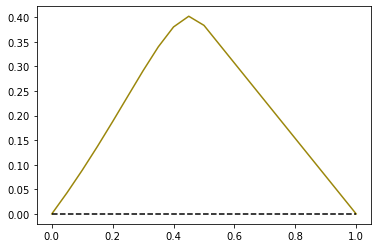

Mn0.05Ta0.95O2.50
Making synthetic formation energy, since MP doesn't have data for Mn in ox state: 5.0
Mn0.10Ta0.90O2.50
Making synthetic formation energy, since MP doesn't have data for Mn in ox state: 5.0
Mn0.15Ta0.85O2.50
Making synthetic formation energy, since MP doesn't have data for Mn in ox state: 5.0
Mn0.20Ta0.80O2.50
Making synthetic formation energy, since MP doesn't have data for Mn in ox state: 5.0
Mn0.25Ta0.75O2.50
Making synthetic formation energy, since MP doesn't have data for Mn in ox state: 5.0
Mn0.30Ta0.70O2.50
Making synthetic formation energy, since MP doesn't have data for Mn in ox state: 5.0
Mn0.35Ta0.65O2.50
Making synthetic formation energy, since MP doesn't have data for Mn in ox state: 5.0
Mn0.40Ta0.60O2.50
Making synthetic formation energy, since MP doesn't have data for Mn in ox state: 5.0
Mn0.45Ta0.55O2.50
Making synthetic formation energy, since MP doesn't have data for Mn in ox state: 5.0
Mn0.50Ta0.50O2.50
Making synthetic formation energy, since MP do

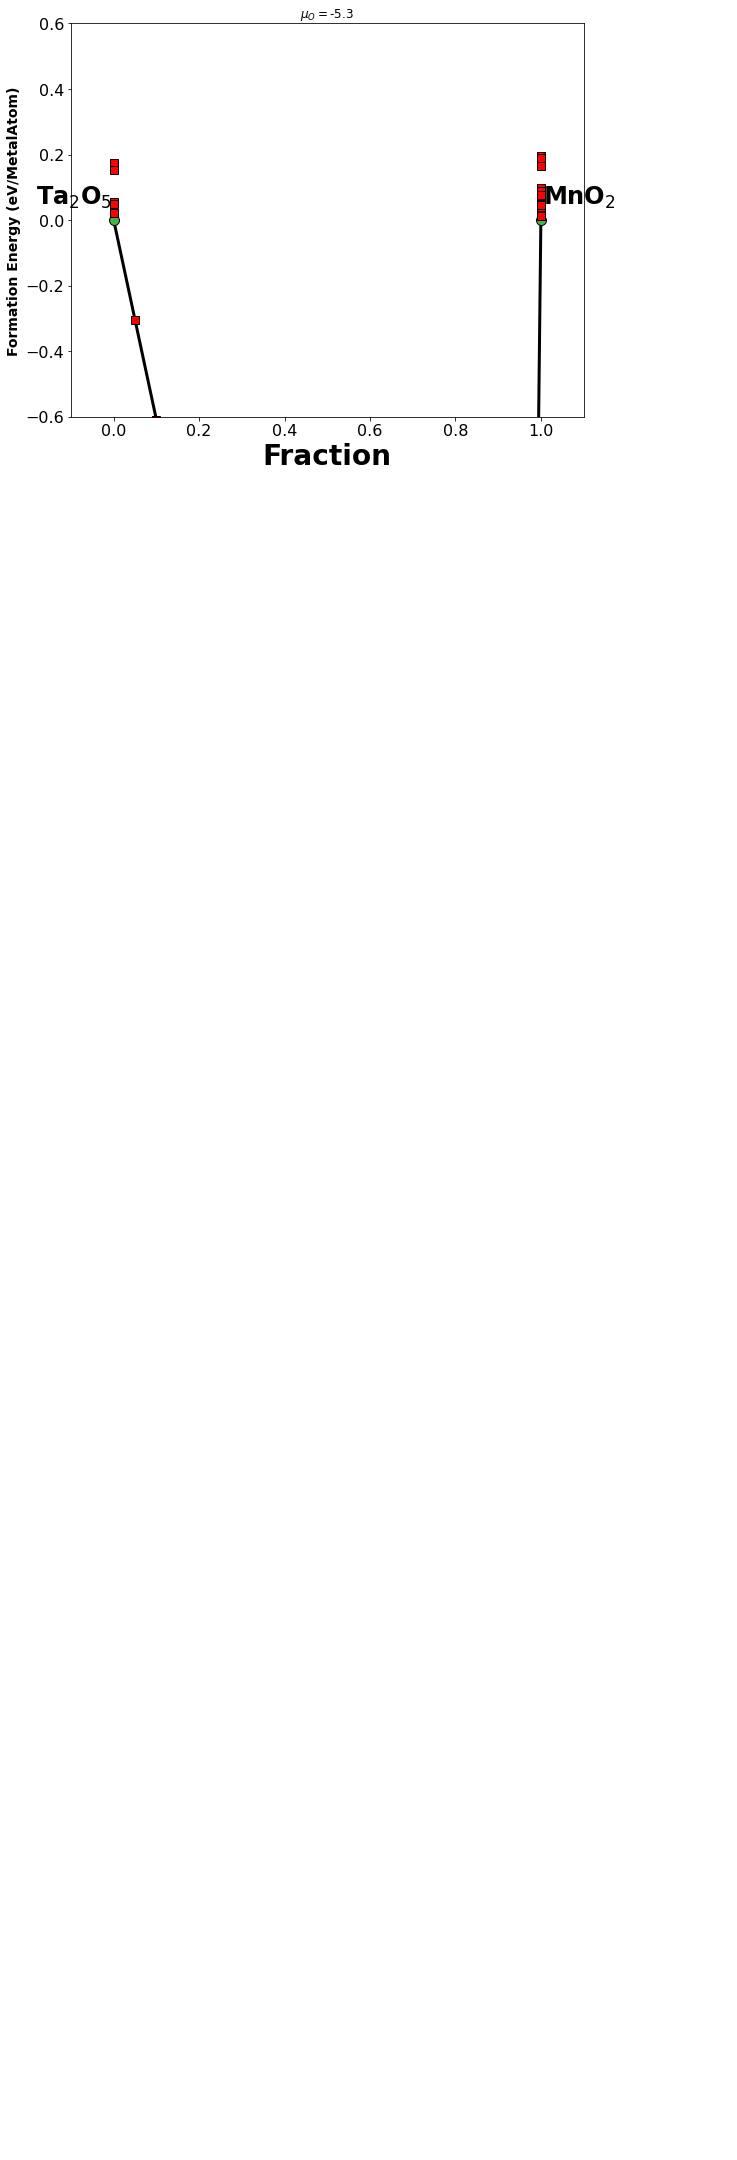

defaultdict(None, {'0.05': array([[0.11171375, 0.11171375, 0.11171375, 0.11171375, 0.11171375,
        0.11171375, 0.11171375, 0.11171375, 0.11171375, 0.11171375,
        0.11171375]]), '0.1': array([[0.10550743, 0.10550743, 0.10550743, 0.10550743, 0.10550743,
        0.10550743, 0.10550743, 0.10550743, 0.10550743, 0.10550743,
        0.10550743]]), '0.15': array([[0.09930111, 0.09930111, 0.09930111, 0.09930111, 0.09930111,
        0.09930111, 0.09930111, 0.09930111, 0.09930111, 0.09930111,
        0.09930111]]), '0.2': array([[0.09309479, 0.09309479, 0.09309479, 0.09309479, 0.09309479,
        0.09309479, 0.09309479, 0.09309479, 0.09309479, 0.09309479,
        0.09309479]]), '0.25': array([[0.08688847, 0.08688847, 0.08688847, 0.08688847, 0.08688847,
        0.08688847, 0.08688847, 0.08688847, 0.08688847, 0.08688847,
        0.08688847]]), '0.3': array([[0.08068215, 0.08068215, 0.08068215, 0.08068215, 0.08068215,
        0.08068215, 0.08068215, 0.08068215, 0.08068215, 0.08068215,
     

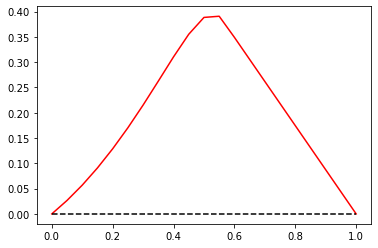

Fe0.05Ta0.95O2.50
Making synthetic formation energy, since MP doesn't have data for Fe in ox state: 5.0
Fe0.10Ta0.90O2.50
Making synthetic formation energy, since MP doesn't have data for Fe in ox state: 5.0
Fe0.15Ta0.85O2.50
Making synthetic formation energy, since MP doesn't have data for Fe in ox state: 5.0
Fe0.20Ta0.80O2.50
Making synthetic formation energy, since MP doesn't have data for Fe in ox state: 5.0
Fe0.25Ta0.75O2.50
Making synthetic formation energy, since MP doesn't have data for Fe in ox state: 5.0
Fe0.30Ta0.70O2.50
Making synthetic formation energy, since MP doesn't have data for Fe in ox state: 5.0
Fe0.35Ta0.65O2.50
Making synthetic formation energy, since MP doesn't have data for Fe in ox state: 5.0
Fe0.40Ta0.60O2.50
Making synthetic formation energy, since MP doesn't have data for Fe in ox state: 5.0
Fe0.45Ta0.55O2.50
Making synthetic formation energy, since MP doesn't have data for Fe in ox state: 5.0
Fe0.50Ta0.50O2.50
Making synthetic formation energy, since MP do

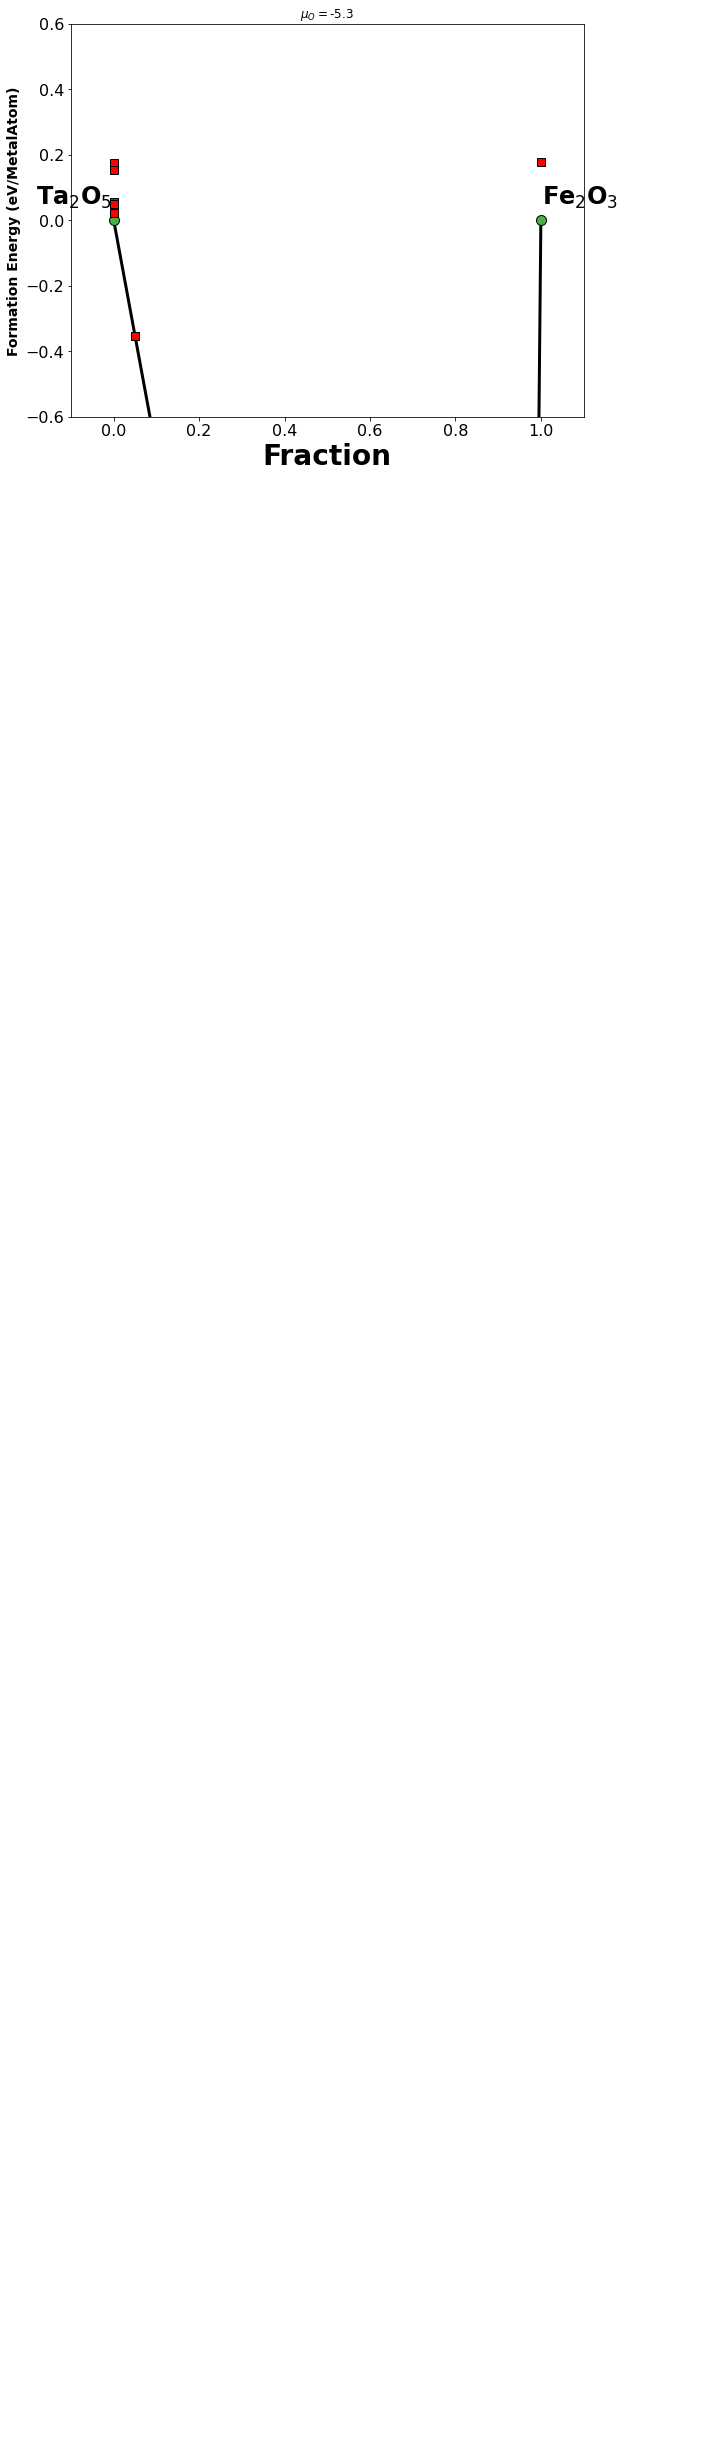

defaultdict(None, {'0.05': array([[0.11171375, 0.11171375, 0.11171375, 0.11171375, 0.11171375,
        0.11171375, 0.11171375, 0.11171375, 0.11171375, 0.11171375,
        0.11171375]]), '0.1': array([[0.10550743, 0.10550743, 0.10550743, 0.10550743, 0.10550743,
        0.10550743, 0.10550743, 0.10550743, 0.10550743, 0.10550743,
        0.10550743]]), '0.15': array([[0.09930111, 0.09930111, 0.09930111, 0.09930111, 0.09930111,
        0.09930111, 0.09930111, 0.09930111, 0.09930111, 0.09930111,
        0.09930111]]), '0.2': array([[0.09309479, 0.09309479, 0.09309479, 0.09309479, 0.09309479,
        0.09309479, 0.09309479, 0.09309479, 0.09309479, 0.09309479,
        0.09309479]]), '0.25': array([[0.08688847, 0.08688847, 0.08688847, 0.08688847, 0.08688847,
        0.08688847, 0.08688847, 0.08688847, 0.08688847, 0.08688847,
        0.08688847]]), '0.3': array([[0.08068215, 0.08068215, 0.08068215, 0.08068215, 0.08068215,
        0.08068215, 0.08068215, 0.08068215, 0.08068215, 0.08068215,
     

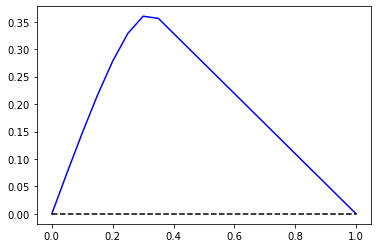

Co0.05Ta0.95O2.50
Making synthetic formation energy, since MP doesn't have data for Co in ox state: 5.0
Co0.10Ta0.90O2.50
Making synthetic formation energy, since MP doesn't have data for Co in ox state: 5.0
Co0.15Ta0.85O2.50
Making synthetic formation energy, since MP doesn't have data for Co in ox state: 5.0
Co0.20Ta0.80O2.50
Making synthetic formation energy, since MP doesn't have data for Co in ox state: 5.0
Co0.25Ta0.75O2.50
Making synthetic formation energy, since MP doesn't have data for Co in ox state: 5.0
Co0.30Ta0.70O2.50
Making synthetic formation energy, since MP doesn't have data for Co in ox state: 5.0
Co0.35Ta0.65O2.50
Making synthetic formation energy, since MP doesn't have data for Co in ox state: 5.0
Co0.40Ta0.60O2.50
Making synthetic formation energy, since MP doesn't have data for Co in ox state: 5.0
Co0.45Ta0.55O2.50
Making synthetic formation energy, since MP doesn't have data for Co in ox state: 5.0
Co0.50Ta0.50O2.50
Making synthetic formation energy, since MP do

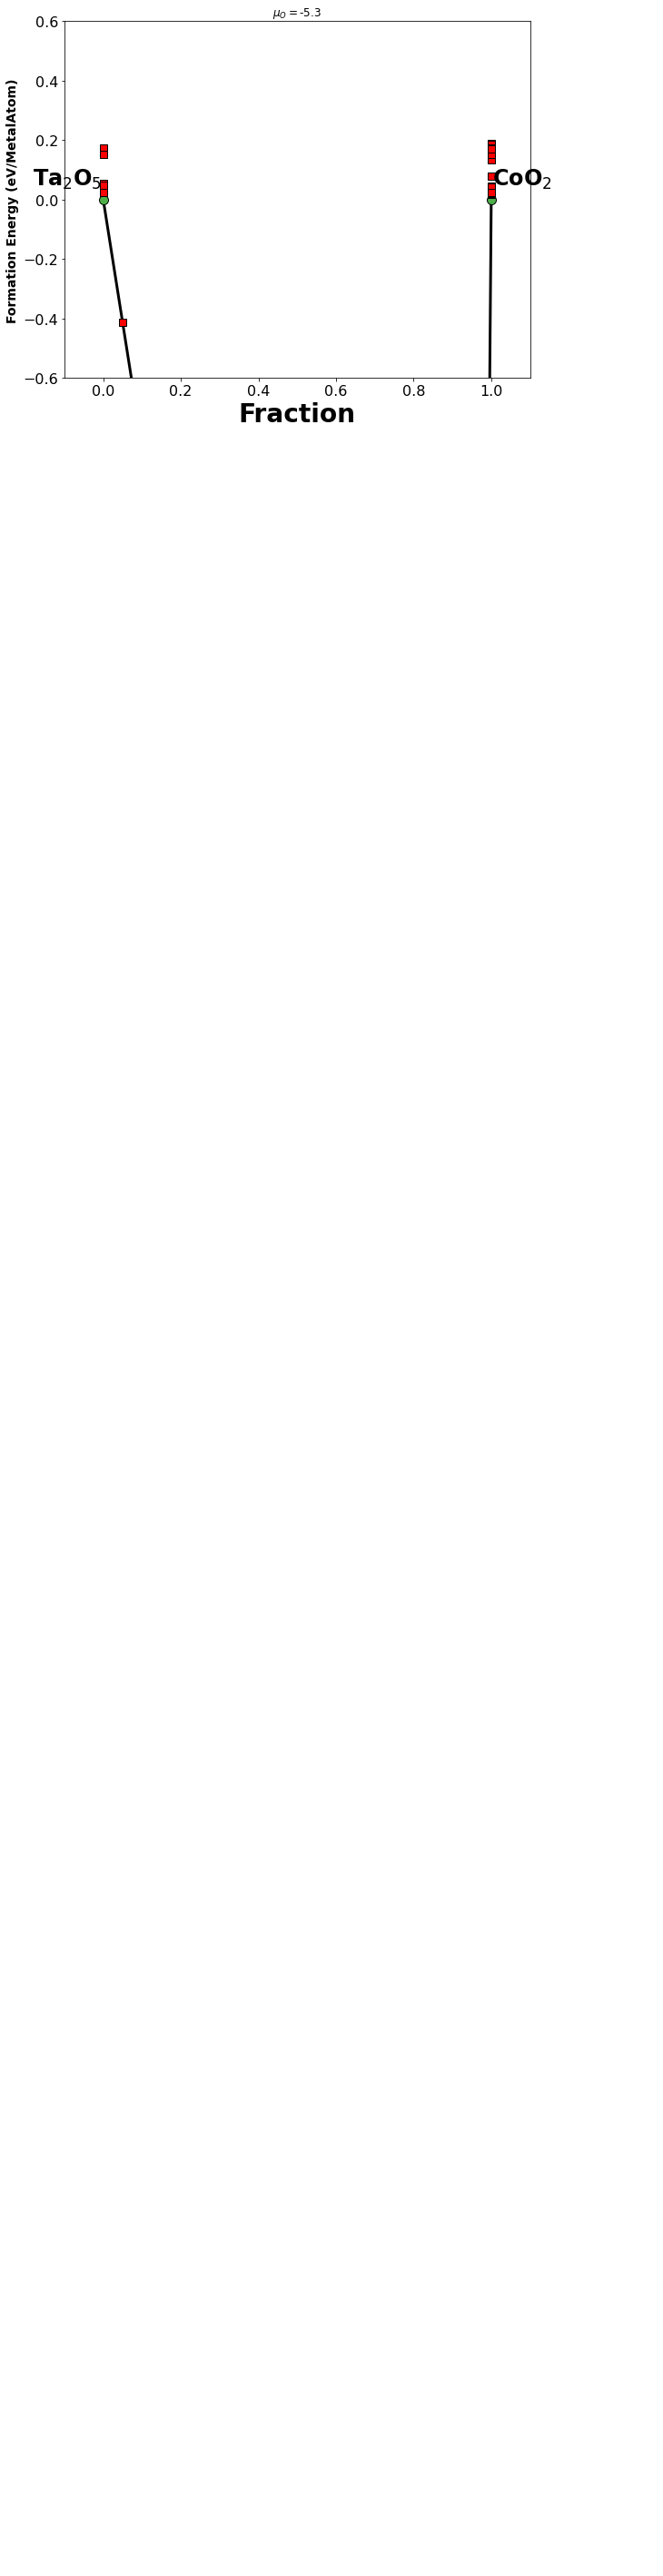

defaultdict(None, {'0.05': array([[0.11171375, 0.11171375, 0.11171375, 0.11171375, 0.11171375,
        0.11171375, 0.11171375, 0.11171375, 0.11171375, 0.11171375,
        0.11171375]]), '0.1': array([[0.10550743, 0.10550743, 0.10550743, 0.10550743, 0.10550743,
        0.10550743, 0.10550743, 0.10550743, 0.10550743, 0.10550743,
        0.10550743]]), '0.15': array([[0.09930111, 0.09930111, 0.09930111, 0.09930111, 0.09930111,
        0.09930111, 0.09930111, 0.09930111, 0.09930111, 0.09930111,
        0.09930111]]), '0.2': array([[0.09309479, 0.09309479, 0.09309479, 0.09309479, 0.09309479,
        0.09309479, 0.09309479, 0.09309479, 0.09309479, 0.09309479,
        0.09309479]]), '0.25': array([[0.08688847, 0.08688847, 0.08688847, 0.08688847, 0.08688847,
        0.08688847, 0.08688847, 0.08688847, 0.08688847, 0.08688847,
        0.08688847]]), '0.3': array([[0.08068215, 0.08068215, 0.08068215, 0.08068215, 0.08068215,
        0.08068215, 0.08068215, 0.08068215, 0.08068215, 0.08068215,
     

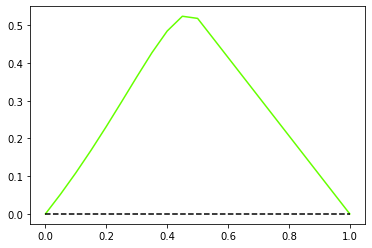

Ni0.05Ta0.95O2.50
Ni0.10Ta0.90O2.50
Ni0.15Ta0.85O2.50
Ni0.20Ta0.80O2.50
Ni0.25Ta0.75O2.50
Ni0.30Ta0.70O2.50
Ni0.35Ta0.65O2.50
Ni0.40Ta0.60O2.50
Ni0.45Ta0.55O2.50
Ni0.50Ta0.50O2.50
Ni0.55Ta0.45O2.50
Ni0.60Ta0.40O2.50
Ni0.65Ta0.35O2.50
Ni0.70Ta0.30O2.50
Ni0.75Ta0.25O2.50
Ni0.80Ta0.20O2.50
Ni0.85Ta0.15O2.50
Ni0.90Ta0.10O2.50
Ni0.95Ta0.05O2.50


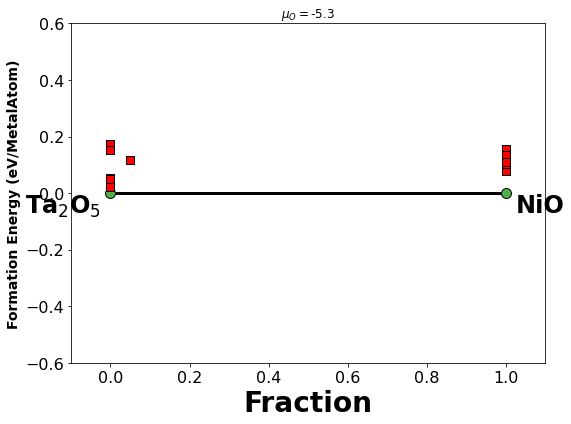

defaultdict(None, {'0.05': array([[0.17006343, 0.16577771, 0.161492  , 0.15720629, 0.15292057,
        0.14863486, 0.14434914, 0.14006343, 0.13577771, 0.131492  ,
        0.12720629]]), '0.1': array([[0.22220679, 0.21363536, 0.20506393, 0.1964925 , 0.18792107,
        0.17934964, 0.17077822, 0.16220679, 0.15363536, 0.14506393,
        0.1364925 ]]), '0.15': array([[0.27435015, 0.261493  , 0.24863586, 0.23577872, 0.22292157,
        0.21006443, 0.19720729, 0.18435015, 0.171493  , 0.15863586,
        0.14577872]]), '0.2': array([[0.3264935 , 0.30935065, 0.29220779, 0.27506493, 0.25792208,
        0.24077922, 0.22363636, 0.2064935 , 0.18935065, 0.17220779,
        0.15506493]]), '0.25': array([[0.37863686, 0.35720829, 0.33577972, 0.31435115, 0.29292258,
        0.27149401, 0.25006543, 0.22863686, 0.20720829, 0.18577972,
        0.16435115]]), '0.3': array([[0.43078022, 0.40506593, 0.37935165, 0.35363736, 0.32792308,
        0.30220879, 0.27649451, 0.25078022, 0.22506593, 0.19935165,
     

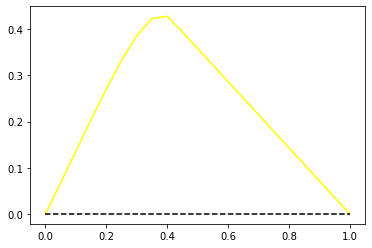

Cu0.05Ta0.95O2.50
Making synthetic formation energy, since MP doesn't have data for Cu in ox state: 5.0
Cu0.10Ta0.90O2.50
Making synthetic formation energy, since MP doesn't have data for Cu in ox state: 5.0
Cu0.15Ta0.85O2.50
Making synthetic formation energy, since MP doesn't have data for Cu in ox state: 5.0
Cu0.20Ta0.80O2.50
Making synthetic formation energy, since MP doesn't have data for Cu in ox state: 5.0
Cu0.25Ta0.75O2.50
Making synthetic formation energy, since MP doesn't have data for Cu in ox state: 5.0
Cu0.30Ta0.70O2.50
Making synthetic formation energy, since MP doesn't have data for Cu in ox state: 5.0
Cu0.35Ta0.65O2.50
Making synthetic formation energy, since MP doesn't have data for Cu in ox state: 5.0
Cu0.40Ta0.60O2.50
Making synthetic formation energy, since MP doesn't have data for Cu in ox state: 5.0
Cu0.45Ta0.55O2.50
Making synthetic formation energy, since MP doesn't have data for Cu in ox state: 5.0
Cu0.50Ta0.50O2.50
Making synthetic formation energy, since MP do

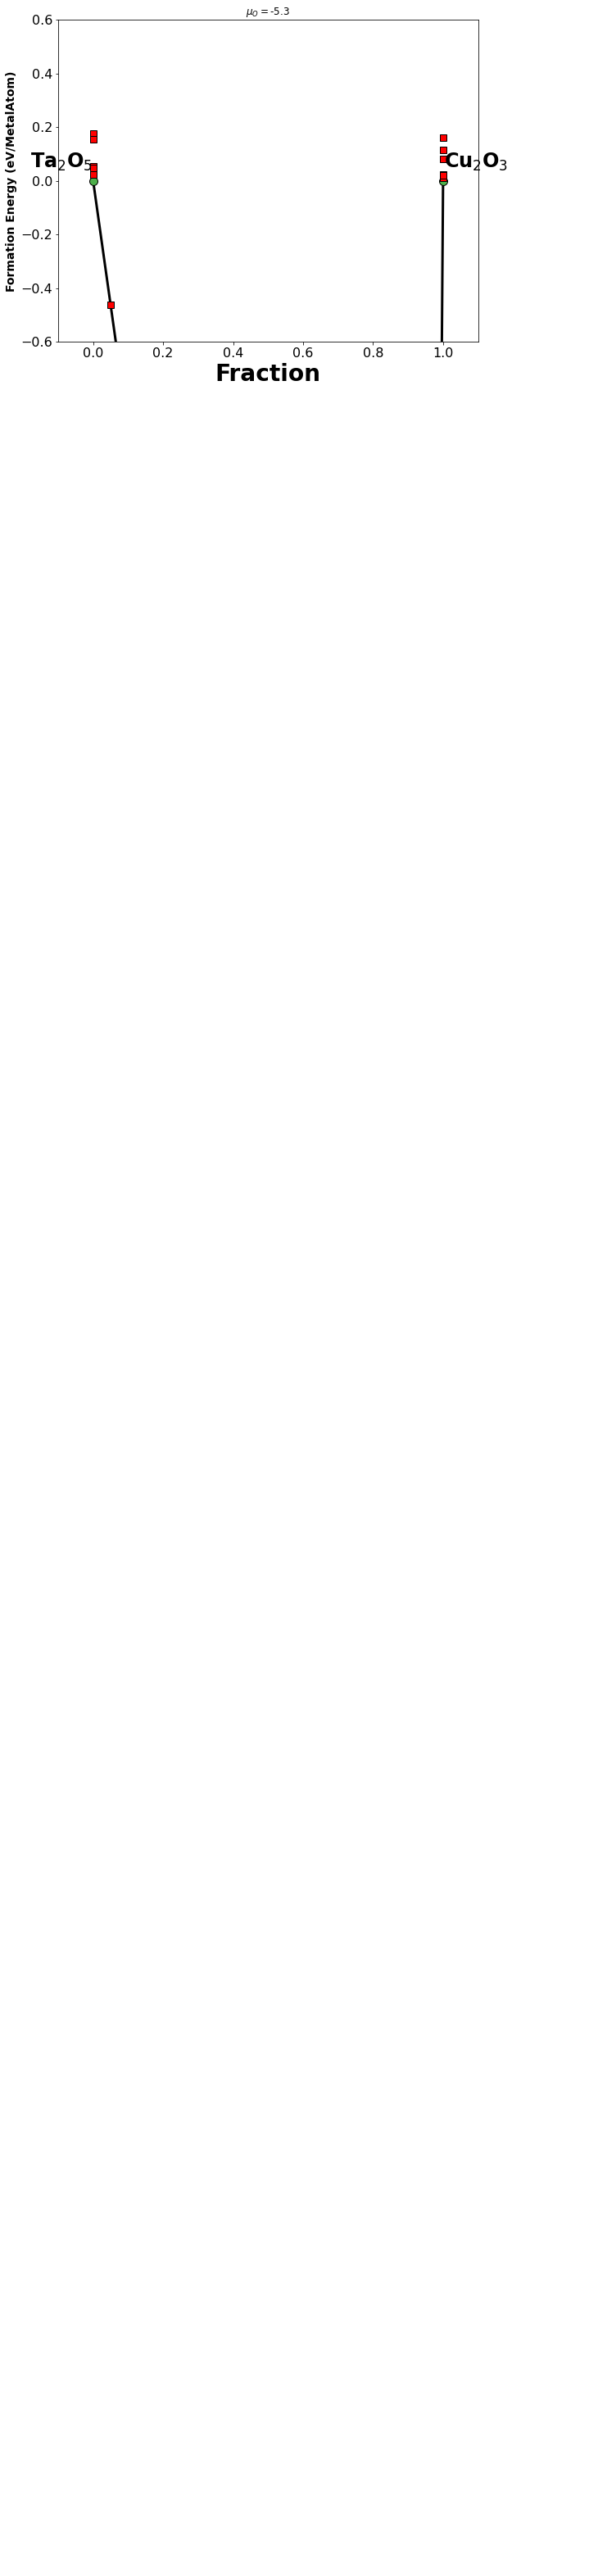

defaultdict(None, {'0.05': array([[0.11171375, 0.11171375, 0.11171375, 0.11171375, 0.11171375,
        0.11171375, 0.11171375, 0.11171375, 0.11171375, 0.11171375,
        0.11171375]]), '0.1': array([[0.10550743, 0.10550743, 0.10550743, 0.10550743, 0.10550743,
        0.10550743, 0.10550743, 0.10550743, 0.10550743, 0.10550743,
        0.10550743]]), '0.15': array([[0.09930111, 0.09930111, 0.09930111, 0.09930111, 0.09930111,
        0.09930111, 0.09930111, 0.09930111, 0.09930111, 0.09930111,
        0.09930111]]), '0.2': array([[0.09309479, 0.09309479, 0.09309479, 0.09309479, 0.09309479,
        0.09309479, 0.09309479, 0.09309479, 0.09309479, 0.09309479,
        0.09309479]]), '0.25': array([[0.08688847, 0.08688847, 0.08688847, 0.08688847, 0.08688847,
        0.08688847, 0.08688847, 0.08688847, 0.08688847, 0.08688847,
        0.08688847]]), '0.3': array([[0.08068215, 0.08068215, 0.08068215, 0.08068215, 0.08068215,
        0.08068215, 0.08068215, 0.08068215, 0.08068215, 0.08068215,
     

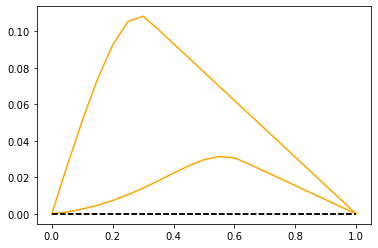

Mo0.05Ta0.95O2.50
Mo0.10Ta0.90O2.50
Mo0.15Ta0.85O2.50
Mo0.20Ta0.80O2.50
Mo0.25Ta0.75O2.50
Mo0.30Ta0.70O2.50
Mo0.35Ta0.65O2.50
Mo0.40Ta0.60O2.50
Mo0.45Ta0.55O2.50
Mo0.50Ta0.50O2.50
Mo0.55Ta0.45O2.50
Mo0.60Ta0.40O2.50
Mo0.65Ta0.35O2.50
Mo0.70Ta0.30O2.50
Mo0.75Ta0.25O2.50
Mo0.80Ta0.20O2.50
Mo0.85Ta0.15O2.50
Mo0.90Ta0.10O2.50
Mo0.95Ta0.05O2.50


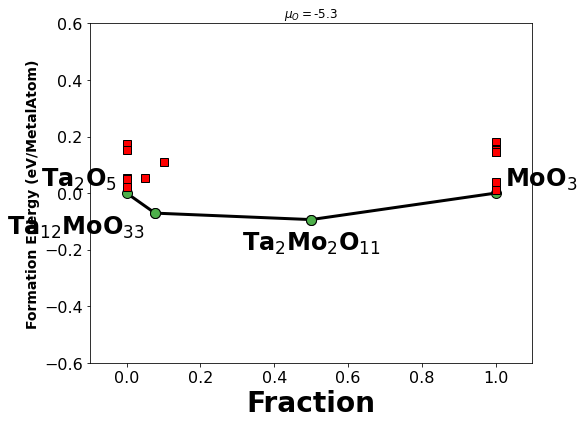

defaultdict(None, {'0.05': array([[0.12444735, 0.12587593, 0.1273045 , 0.12873307, 0.13016164,
        0.13159021, 0.13301878, 0.13444735, 0.13587593, 0.1373045 ,
        0.13873307]]), '0.1': array([[0.13145472, 0.13431186, 0.13716901, 0.14002615, 0.14288329,
        0.14574043, 0.14859758, 0.15145472, 0.15431186, 0.15716901,
        0.16002615]]), '0.15': array([[0.13897639, 0.1432621 , 0.14754782, 0.15183353, 0.15611925,
        0.16040496, 0.16469068, 0.16897639, 0.1732621 , 0.17754782,
        0.18183353]]), '0.2': array([[0.14703438, 0.15274867, 0.15846295, 0.16417724, 0.16989152,
        0.17560581, 0.18132009, 0.18703438, 0.19274867, 0.19846295,
        0.20417724]]), '0.25': array([[0.15562724, 0.16277009, 0.16991295, 0.17705581, 0.18419867,
        0.19134152, 0.19848438, 0.20562724, 0.21277009, 0.21991295,
        0.22705581]]), '0.3': array([[0.16471261, 0.17328403, 0.18185546, 0.19042689, 0.19899832,
        0.20756975, 0.21614118, 0.22471261, 0.23328403, 0.24185546,
     

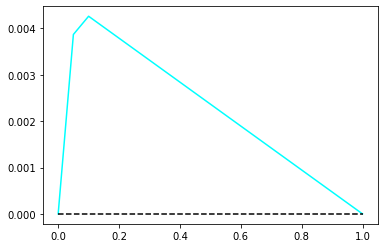

[4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[4, 4, 4, 4, 6, 6, 6, 6]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Nb0.05Ta0.95O2.50
Nb0.10Ta0.90O2.50
Nb0.15Ta0.85O2.50
Nb0.20Ta0.80O2.50
Nb0.25Ta0.75O2.50
Nb0.30Ta0.70O2.50
Nb0.35Ta0.65O2.50
Nb0.40Ta0.60O2.50
Nb0.45Ta0.55O2.50
Nb0.50Ta0.50O2.50
Nb0.55Ta0.45O2.50
Nb0.60Ta0.40O2.50
Nb0.65Ta0.35O2.50
Nb0.70Ta0.30O2.50
Nb0.75Ta0.25O2.50
Nb0.80Ta0.20O2.50
Nb0.85Ta0.15O2.50
Nb0.90Ta0.10O2.50
Nb0.95Ta0.05O2.50


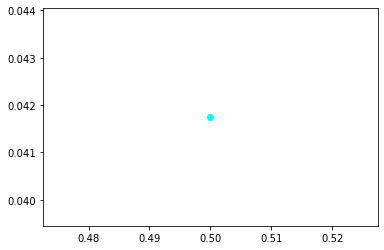

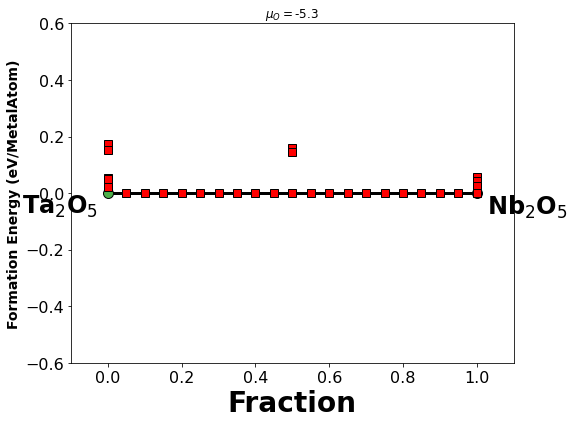

defaultdict(None, {'0.05': array([[0.11303728, 0.11303728, 0.11303728, 0.11303728, 0.11303728,
        0.11303728, 0.11303728, 0.11303728, 0.11303728, 0.11303728,
        0.11303728]]), '0.1': array([[0.10815449, 0.10815449, 0.10815449, 0.10815449, 0.10815449,
        0.10815449, 0.10815449, 0.10815449, 0.10815449, 0.10815449,
        0.10815449]]), '0.15': array([[0.1032717, 0.1032717, 0.1032717, 0.1032717, 0.1032717, 0.1032717,
        0.1032717, 0.1032717, 0.1032717, 0.1032717, 0.1032717]]), '0.2': array([[0.0983889, 0.0983889, 0.0983889, 0.0983889, 0.0983889, 0.0983889,
        0.0983889, 0.0983889, 0.0983889, 0.0983889, 0.0983889]]), '0.25': array([[0.09350611, 0.09350611, 0.09350611, 0.09350611, 0.09350611,
        0.09350611, 0.09350611, 0.09350611, 0.09350611, 0.09350611,
        0.09350611]]), '0.3': array([[0.08862332, 0.08862332, 0.08862332, 0.08862332, 0.08862332,
        0.08862332, 0.08862332, 0.08862332, 0.08862332, 0.08862332,
        0.08862332]]), '0.35': array([[0.08

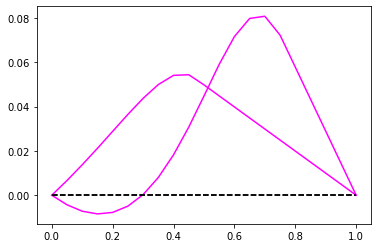

W0.05Ta0.95O2.50
W0.10Ta0.90O2.50
W0.15Ta0.85O2.50
W0.20Ta0.80O2.50
W0.25Ta0.75O2.50
W0.30Ta0.70O2.50
W0.35Ta0.65O2.50
W0.40Ta0.60O2.50
W0.45Ta0.55O2.50
W0.50Ta0.50O2.50
W0.55Ta0.45O2.50
W0.60Ta0.40O2.50
W0.65Ta0.35O2.50
W0.70Ta0.30O2.50
W0.75Ta0.25O2.50
W0.80Ta0.20O2.50
W0.85Ta0.15O2.50
W0.90Ta0.10O2.50
W0.95Ta0.05O2.50


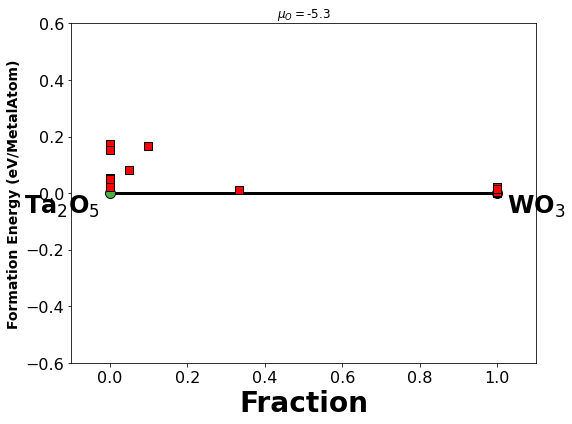

defaultdict(None, {'0.05': array([[0.13221917, 0.13364774, 0.13507631, 0.13650488, 0.13793346,
        0.13936203, 0.1407906 , 0.14221917, 0.14364774, 0.14507631,
        0.14650488]]), '0.1': array([[0.14795771, 0.15081485, 0.15367199, 0.15652914, 0.15938628,
        0.16224342, 0.16510056, 0.16795771, 0.17081485, 0.17367199,
        0.17652914]]), '0.15': array([[0.16535823, 0.16964394, 0.17392966, 0.17821537, 0.18250109,
        0.1867868 , 0.19107251, 0.19535823, 0.19964394, 0.20392966,
        0.20821537]]), '0.2': array([[0.18466178, 0.19037606, 0.19609035, 0.20180463, 0.20751892,
        0.2132332 , 0.21894749, 0.22466178, 0.23037606, 0.23609035,
        0.24180463]]), '0.25': array([[0.20611405, 0.21325691, 0.22039977, 0.22754262, 0.23468548,
        0.24182834, 0.2489712 , 0.25611405, 0.26325691, 0.27039977,
        0.27754262]]), '0.3': array([[0.22993783, 0.23850926, 0.24708069, 0.25565212, 0.26422355,
        0.27279497, 0.2813664 , 0.28993783, 0.29850926, 0.30708069,
     

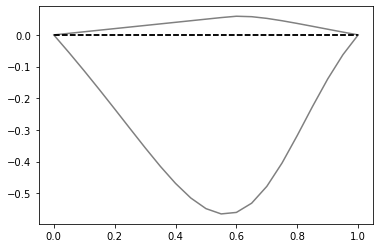

Ti0.05W0.95O2.50
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5.0
Ti0.10W0.90O2.50
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5.0
Ti0.15W0.85O2.50
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5.0
Ti0.20W0.80O2.50
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5.0
Ti0.25W0.75O2.50
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5.0
Ti0.30W0.70O2.50
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5.0
Ti0.35W0.65O2.50
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5.0
Ti0.40W0.60O2.50
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5.0
Ti0.45W0.55O2.50
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5.0
Ti0.50W0.50O2.50
Making synthetic formation energy, since MP doesn't have

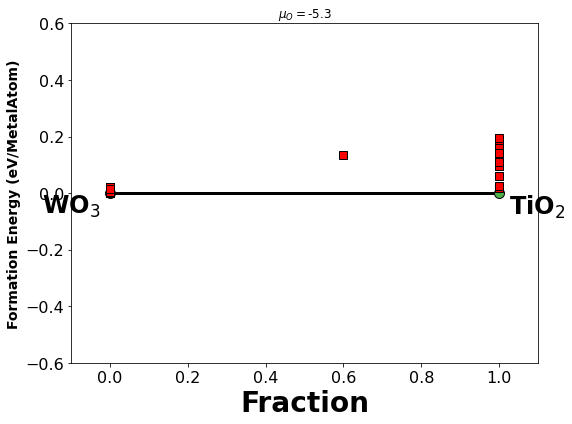

defaultdict(None, {'0.05': array([[0.47091252, 0.4966268 , 0.52234109, 0.54805538, 0.57376966,
        0.59948395, 0.62519823, 0.65091252, 0.6766268 , 0.70234109,
        0.72805538]]), '0.1': array([[0.44952462, 0.47238177, 0.49523891, 0.51809605, 0.54095319,
        0.56381034, 0.58666748, 0.60952462, 0.63238177, 0.65523891,
        0.67809605]]), '0.15': array([[0.42641772, 0.44641772, 0.46641772, 0.48641772, 0.50641772,
        0.52641772, 0.54641772, 0.56641772, 0.58641772, 0.60641772,
        0.62641772]]), '0.2': array([[0.40197943, 0.41912229, 0.43626514, 0.453408  , 0.47055086,
        0.48769372, 0.50483657, 0.52197943, 0.53912229, 0.55626514,
        0.573408  ]]), '0.25': array([[0.37690122, 0.39118693, 0.40547265, 0.41975836, 0.43404408,
        0.44832979, 0.46261551, 0.47690122, 0.49118693, 0.50547265,
        0.51975836]]), '0.3': array([[0.35231036, 0.36373893, 0.37516751, 0.38659608, 0.39802465,
        0.40945322, 0.42088179, 0.43231036, 0.44373893, 0.45516751,
     

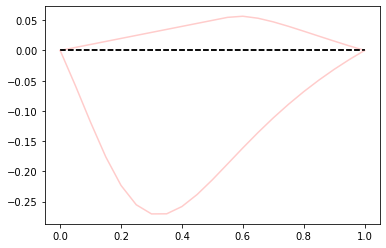

[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
[2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
V0.05W0.95O2.50
V0.10W0.90O2.50
V0.15W0.85O2.50
V0.20W0.80O2.50
V0.25W0.75O2.50
V0.30W0.70O2.50
V0.35W0.65O2.50
V0.40W0.60O2.50
V0.45W0.55O2.50
V0.50W0.50O2.50
V0.55W0.45O2.50
V0.60W0.40O2.50
V0.65W0.35O2.50
V0.70W0.30O2.50
V0.75W0.25O2.50
V0.80W0.20O2.50
V0.85W0.15O2.50
V0.90W0.10O2.50
V0.95W0.05O2.50


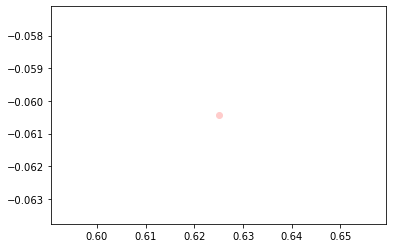

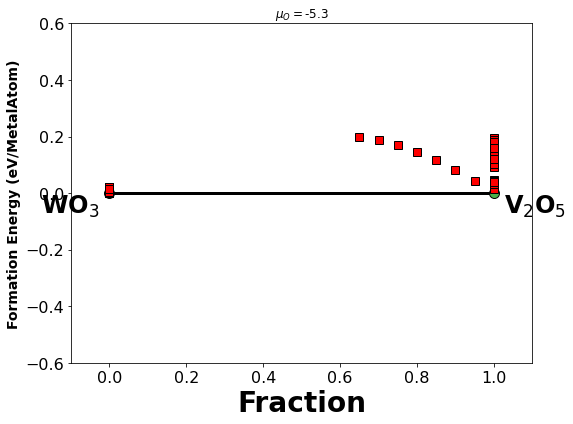

entry.name
V5W3O20(s)
entry.name
Pourbaix Entry : V10 W6 O40 with energy = -12.3295, npH = -80.0, nPhi = -80.0, nH2O = 40.0, entry_id = mp-757241 
[[0.20246495 0.22057566 0.26700423 0.3134328  0.35986138 0.40628995
  0.45271852 0.49914709 0.54557566 0.59200423 0.6384328 ]]
defaultdict(None, {'0.05': array([[0.41407868, 0.44181325, 0.47181325, 0.50181325, 0.53181325,
        0.56181325, 0.59181325, 0.62181325, 0.65181325, 0.68181325,
        0.71181325]]), '0.1': array([[0.33511122, 0.36200893, 0.3934375 , 0.42486608, 0.45629465,
        0.48772322, 0.51915179, 0.55058036, 0.58200893, 0.6134375 ,
        0.64486608]]), '0.15': array([[0.25966478, 0.28572564, 0.31858278, 0.35143993, 0.38429707,
        0.41715421, 0.45001136, 0.4828685 , 0.51572564, 0.54858278,
        0.58143993]]), '0.2': array([[0.19438673, 0.21961073, 0.25389644, 0.28818216, 0.32246787,
        0.35675359, 0.3910393 , 0.42532502, 0.45961073, 0.49389644,
        0.52818216]]), '0.25': array([[0.14422511, 0.16861226, 0

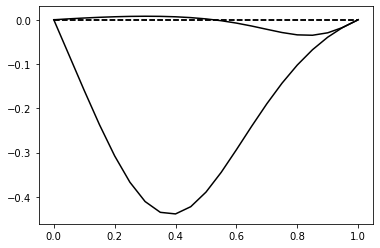

Cr0.05W0.95O2.50
Cr0.10W0.90O2.50
Cr0.15W0.85O2.50
Cr0.20W0.80O2.50
Cr0.25W0.75O2.50
Cr0.30W0.70O2.50
Cr0.35W0.65O2.50
Cr0.40W0.60O2.50
Cr0.45W0.55O2.50
Cr0.50W0.50O2.50
Cr0.55W0.45O2.50
Cr0.60W0.40O2.50
Cr0.65W0.35O2.50
Cr0.70W0.30O2.50
Cr0.75W0.25O2.50
Cr0.80W0.20O2.50
Cr0.85W0.15O2.50
Cr0.90W0.10O2.50
Cr0.95W0.05O2.50


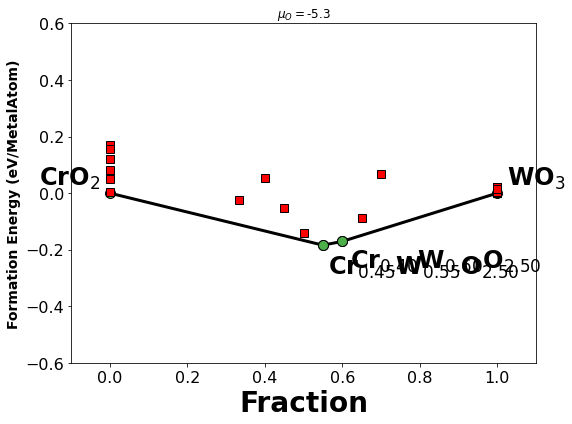

entry.name
CrWO6(s)
entry.name
entry.name
CrWO6(s)
entry.name
Pourbaix Entry : Cr1 W1 O6 with energy = 3.1811, npH = -12.0, nPhi = -12.0, nH2O = 6.0, entry_id = mvc-5774 
[[0.3963177 0.3588177 0.3213177 0.2838177 0.2537002 0.2537002 0.2537002
  0.2537002 0.2537002 0.2537002 0.2537002]]
Pourbaix Entry : Cr2 W2 O12 with energy = 7.1900, npH = -24.0, nPhi = -24.0, nH2O = 12.0, entry_id = mvc-5000 
[[0.44805953 0.41055953 0.37305953 0.33555953 0.30544203 0.30544203
  0.30544203 0.30544203 0.30544203 0.30544203 0.30544203]]
defaultdict(None, {'0.05': array([[0.41064059, 0.4349263 , 0.45921202, 0.48349773, 0.50862716,
        0.53719859, 0.56577002, 0.59434144, 0.62291287, 0.6514843 ,
        0.68005573]]), '0.1': array([[0.33062229, 0.35062229, 0.37062229, 0.39062229, 0.41230972,
        0.44088114, 0.46945257, 0.498024  , 0.52659543, 0.55516686,
        0.58373829]]), '0.15': array([[0.25332094, 0.26903522, 0.28474951, 0.30046379, 0.31870922,
        0.34728065, 0.37585208, 0.40442351, 0.4

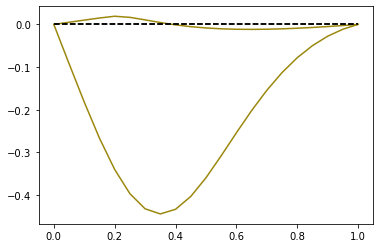

Mn0.05W0.95O2.50
Making synthetic formation energy, since MP doesn't have data for Mn in ox state: 5.0
Mn0.10W0.90O2.50
Making synthetic formation energy, since MP doesn't have data for Mn in ox state: 5.0
Mn0.15W0.85O2.50
Making synthetic formation energy, since MP doesn't have data for Mn in ox state: 5.0
Mn0.20W0.80O2.50
Making synthetic formation energy, since MP doesn't have data for Mn in ox state: 5.0
Mn0.25W0.75O2.50
Making synthetic formation energy, since MP doesn't have data for Mn in ox state: 5.0
Mn0.30W0.70O2.50
Making synthetic formation energy, since MP doesn't have data for Mn in ox state: 5.0
Mn0.35W0.65O2.50
Making synthetic formation energy, since MP doesn't have data for Mn in ox state: 5.0
Mn0.40W0.60O2.50
Making synthetic formation energy, since MP doesn't have data for Mn in ox state: 5.0
Mn0.45W0.55O2.50
Making synthetic formation energy, since MP doesn't have data for Mn in ox state: 5.0
Mn0.50W0.50O2.50
Making synthetic formation energy, since MP doesn't have

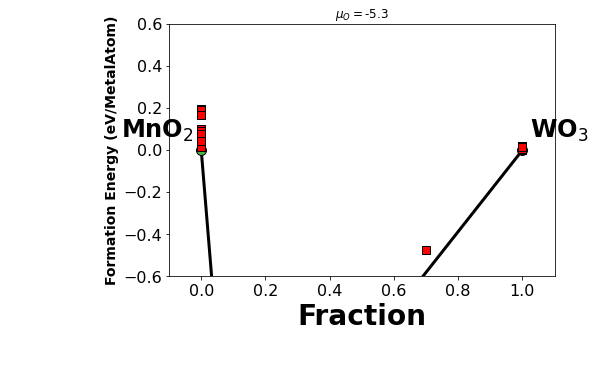

defaultdict(None, {'0.05': array([[0.3920643 , 0.4165541 , 0.4415362 , 0.4665362 , 0.4915362 ,
        0.5165362 , 0.5415362 , 0.56676708, 0.5921639 , 0.61756073,
        0.64413525]]), '0.1': array([[0.29514523, 0.3155534 , 0.33694617, 0.35837474, 0.37980331,
        0.40123188, 0.42266046, 0.44455079, 0.46677301, 0.48899523,
        0.51357285]]), '0.15': array([[0.20402284, 0.22034937, 0.23815281, 0.25600995, 0.27386709,
        0.29172424, 0.30958138, 0.32813116, 0.34717878, 0.3662264 ,
        0.38880711]]), '0.2': array([[0.12403109, 0.13627599, 0.15049011, 0.16477582, 0.17906153,
        0.19334725, 0.20763296, 0.2228422 , 0.23871521, 0.25458823,
        0.27517203]]), '0.25': array([[0.0607035 , 0.06886677, 0.07949155, 0.09020584, 0.10092012,
        0.11163441, 0.1223487 , 0.13421738, 0.14691579, 0.15961421,
        0.1782011 ]]), '0.3': array([[0.0185904 , 0.02267203, 0.02970749, 0.03685035, 0.04399321,
        0.05113606, 0.05827892, 0.06680706, 0.07633087, 0.08585468,
     

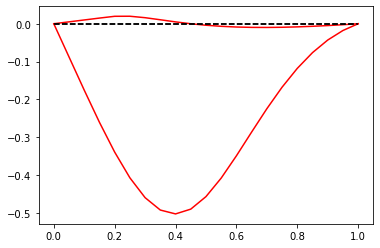

Fe0.05W0.95O2.50
Making synthetic formation energy, since MP doesn't have data for Fe in ox state: 5.0
Fe0.10W0.90O2.50
Making synthetic formation energy, since MP doesn't have data for Fe in ox state: 5.0
Fe0.15W0.85O2.50
Making synthetic formation energy, since MP doesn't have data for Fe in ox state: 5.0
Fe0.20W0.80O2.50
Making synthetic formation energy, since MP doesn't have data for Fe in ox state: 5.0
Fe0.25W0.75O2.50
Making synthetic formation energy, since MP doesn't have data for Fe in ox state: 5.0
Fe0.30W0.70O2.50
Making synthetic formation energy, since MP doesn't have data for Fe in ox state: 5.0
Fe0.35W0.65O2.50
Making synthetic formation energy, since MP doesn't have data for Fe in ox state: 5.0
Fe0.40W0.60O2.50
Making synthetic formation energy, since MP doesn't have data for Fe in ox state: 5.0
Fe0.45W0.55O2.50
Making synthetic formation energy, since MP doesn't have data for Fe in ox state: 5.0
Fe0.50W0.50O2.50
Making synthetic formation energy, since MP doesn't have

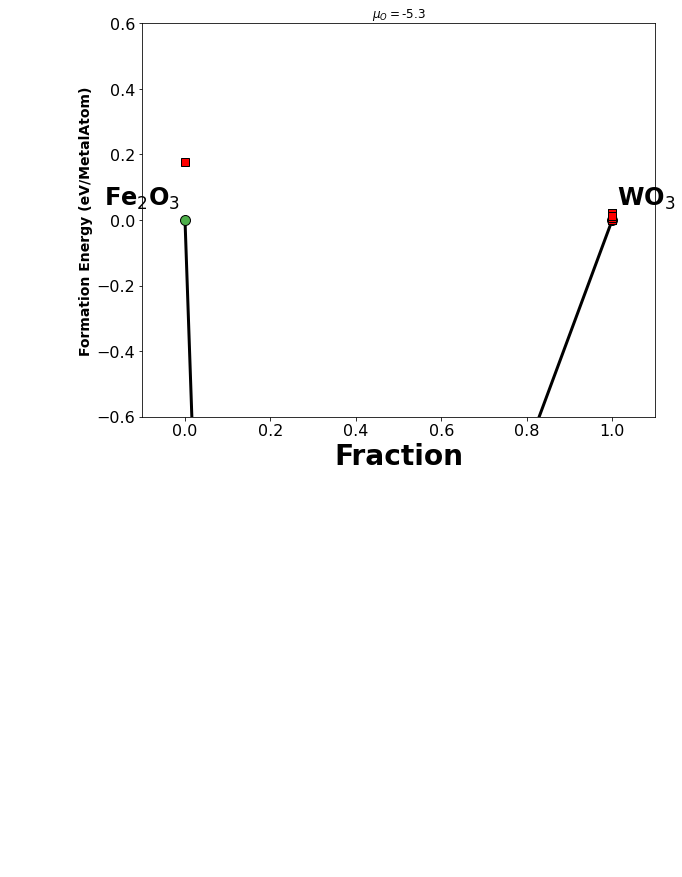

defaultdict(None, {'0.05': array([[0.40421872, 0.42921872, 0.45421872, 0.47921872, 0.50423938,
        0.52963621, 0.55503303, 0.58042986, 0.60582668, 0.63122351,
        0.65662034]]), '0.1': array([[0.31802564, 0.33945421, 0.36088278, 0.38231135, 0.40378124,
        0.42600347, 0.44822569, 0.47044791, 0.49267013, 0.51489235,
        0.53711458]]), '0.15': array([[0.23452399, 0.25238114, 0.27023828, 0.28809542, 0.30601454,
        0.32506216, 0.34410978, 0.3631574 , 0.38220502, 0.40125264,
        0.42030026]]), '0.2': array([[0.15734716, 0.17163288, 0.18591859, 0.20020431, 0.21457266,
        0.23044568, 0.24631869, 0.26219171, 0.27806473, 0.29393774,
        0.30981076]]), '0.25': array([[0.09091222, 0.1016265 , 0.11234079, 0.12305507, 0.13387266,
        0.14657107, 0.15926949, 0.1719679 , 0.18466631, 0.19736472,
        0.21006314]]), '0.3': array([[0.03995891, 0.04710176, 0.05424462, 0.06138748, 0.0686543 ,
        0.07817811, 0.08770192, 0.09722573, 0.10674954, 0.11627334,
     

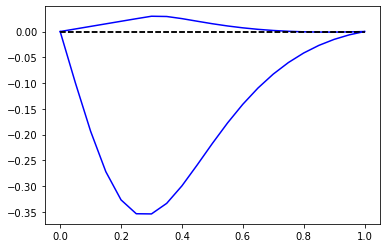

Co0.05W0.95O2.50
Making synthetic formation energy, since MP doesn't have data for Co in ox state: 5.0
Co0.10W0.90O2.50
Making synthetic formation energy, since MP doesn't have data for Co in ox state: 5.0
Co0.15W0.85O2.50
Making synthetic formation energy, since MP doesn't have data for Co in ox state: 5.0
Co0.20W0.80O2.50
Making synthetic formation energy, since MP doesn't have data for Co in ox state: 5.0
Co0.25W0.75O2.50
Making synthetic formation energy, since MP doesn't have data for Co in ox state: 5.0
Co0.30W0.70O2.50
Making synthetic formation energy, since MP doesn't have data for Co in ox state: 5.0
Co0.35W0.65O2.50
Making synthetic formation energy, since MP doesn't have data for Co in ox state: 5.0
Co0.40W0.60O2.50
Making synthetic formation energy, since MP doesn't have data for Co in ox state: 5.0
Co0.45W0.55O2.50
Making synthetic formation energy, since MP doesn't have data for Co in ox state: 5.0
Co0.50W0.50O2.50
Making synthetic formation energy, since MP doesn't have

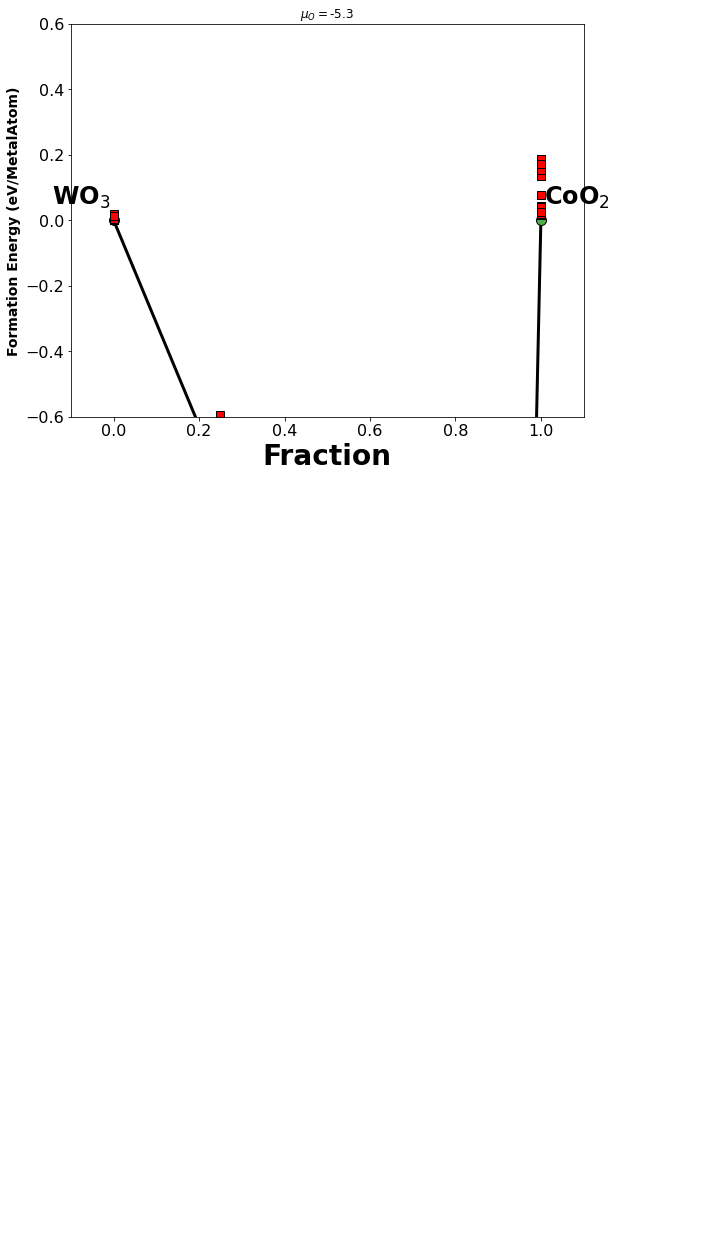

defaultdict(None, {'0.05': array([[0.3683454 , 0.3928352 , 0.41942039, 0.44648806, 0.47355572,
        0.50062339, 0.52769106, 0.55475873, 0.5818264 , 0.60889407,
        0.63596174]]), '0.1': array([[0.2520615 , 0.27246966, 0.29706861, 0.32263252, 0.34819643,
        0.37376034, 0.39932425, 0.42488816, 0.45045207, 0.47601598,
        0.50157989]]), '0.15': array([[0.15114354, 0.16747007, 0.19008277, 0.21414293, 0.23820308,
        0.26226323, 0.28632338, 0.31038353, 0.33444368, 0.35850383,
        0.38256398]]), '0.2': array([[0.07396542, 0.08621032, 0.10683678, 0.12939317, 0.15194956,
        0.17450595, 0.19706234, 0.21961873, 0.24217513, 0.26473152,
        0.28728791]]), '0.25': array([[0.02467659, 0.03283985, 0.05148007, 0.0725327 , 0.09358534,
        0.11463797, 0.1356906 , 0.15674323, 0.17779586, 0.19884849,
        0.21990113]]), '0.3': array([[0.00191487, 0.0059965 , 0.02265048, 0.04219935, 0.06174822,
        0.08129709, 0.10084597, 0.12039484, 0.13994371, 0.15949258,
     

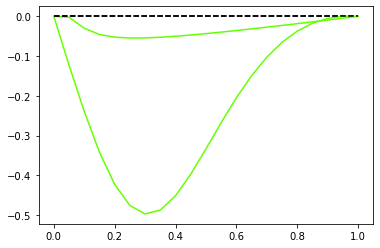

Ni0.05W0.95O2.50
Ni0.10W0.90O2.50
Ni0.15W0.85O2.50
Ni0.20W0.80O2.50
Ni0.25W0.75O2.50
Ni0.30W0.70O2.50
Ni0.35W0.65O2.50
Ni0.40W0.60O2.50
Ni0.45W0.55O2.50
Ni0.50W0.50O2.50
Ni0.55W0.45O2.50
Ni0.60W0.40O2.50
Ni0.65W0.35O2.50
Ni0.70W0.30O2.50
Ni0.75W0.25O2.50
Ni0.80W0.20O2.50
Ni0.85W0.15O2.50
Ni0.90W0.10O2.50
Ni0.95W0.05O2.50


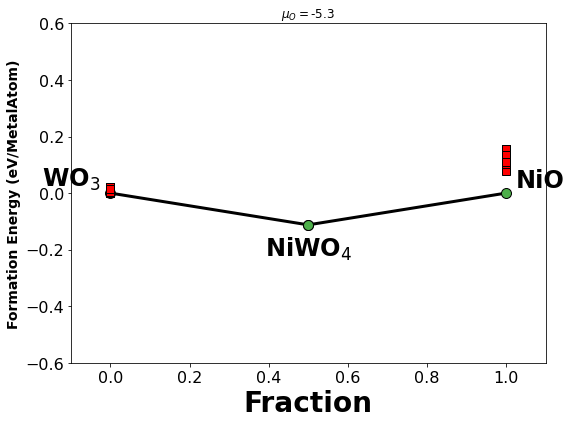

defaultdict(None, {'0.05': array([[0.40107617, 0.42393331, 0.44679045, 0.4696476 , 0.49250474,
        0.51536188, 0.53821903, 0.56107617, 0.58393331, 0.60679045,
        0.6296476 ]]), '0.1': array([[0.31828373, 0.33542658, 0.35256944, 0.3697123 , 0.38685516,
        0.40399801, 0.42114087, 0.43828373, 0.45542658, 0.47256944,
        0.4897123 ]]), '0.15': array([[0.24920439, 0.26063296, 0.27206153, 0.28349011, 0.29491868,
        0.30634725, 0.31777582, 0.32920439, 0.34063296, 0.35206153,
        0.36349011]]), '0.2': array([[0.20159278, 0.20730707, 0.21302136, 0.21873564, 0.22444993,
        0.23016421, 0.2358785 , 0.24159278, 0.24730707, 0.25302136,
        0.25873564]]), '0.25': array([[0.18210599, 0.18210599, 0.18210599, 0.18210599, 0.18210599,
        0.18210599, 0.18210599, 0.18210599, 0.18210599, 0.18210599,
        0.18210599]]), '0.3': array([[0.19437611, 0.18866182, 0.18294753, 0.17723325, 0.17151896,
        0.16580468, 0.16009039, 0.15437611, 0.14866182, 0.14294753,
     

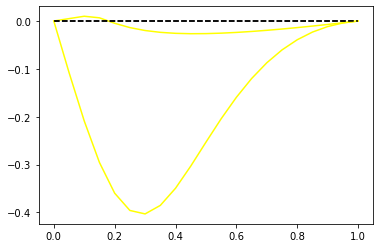

Cu0.05W0.95O2.50
Making synthetic formation energy, since MP doesn't have data for Cu in ox state: 5.0
Cu0.10W0.90O2.50
Making synthetic formation energy, since MP doesn't have data for Cu in ox state: 5.0
Cu0.15W0.85O2.50
Making synthetic formation energy, since MP doesn't have data for Cu in ox state: 5.0
Cu0.20W0.80O2.50
Making synthetic formation energy, since MP doesn't have data for Cu in ox state: 5.0
Cu0.25W0.75O2.50
Making synthetic formation energy, since MP doesn't have data for Cu in ox state: 5.0
Cu0.30W0.70O2.50
Making synthetic formation energy, since MP doesn't have data for Cu in ox state: 5.0
Cu0.35W0.65O2.50
Making synthetic formation energy, since MP doesn't have data for Cu in ox state: 5.0
Cu0.40W0.60O2.50
Making synthetic formation energy, since MP doesn't have data for Cu in ox state: 5.0
Cu0.45W0.55O2.50
Making synthetic formation energy, since MP doesn't have data for Cu in ox state: 5.0
Cu0.50W0.50O2.50
Making synthetic formation energy, since MP doesn't have

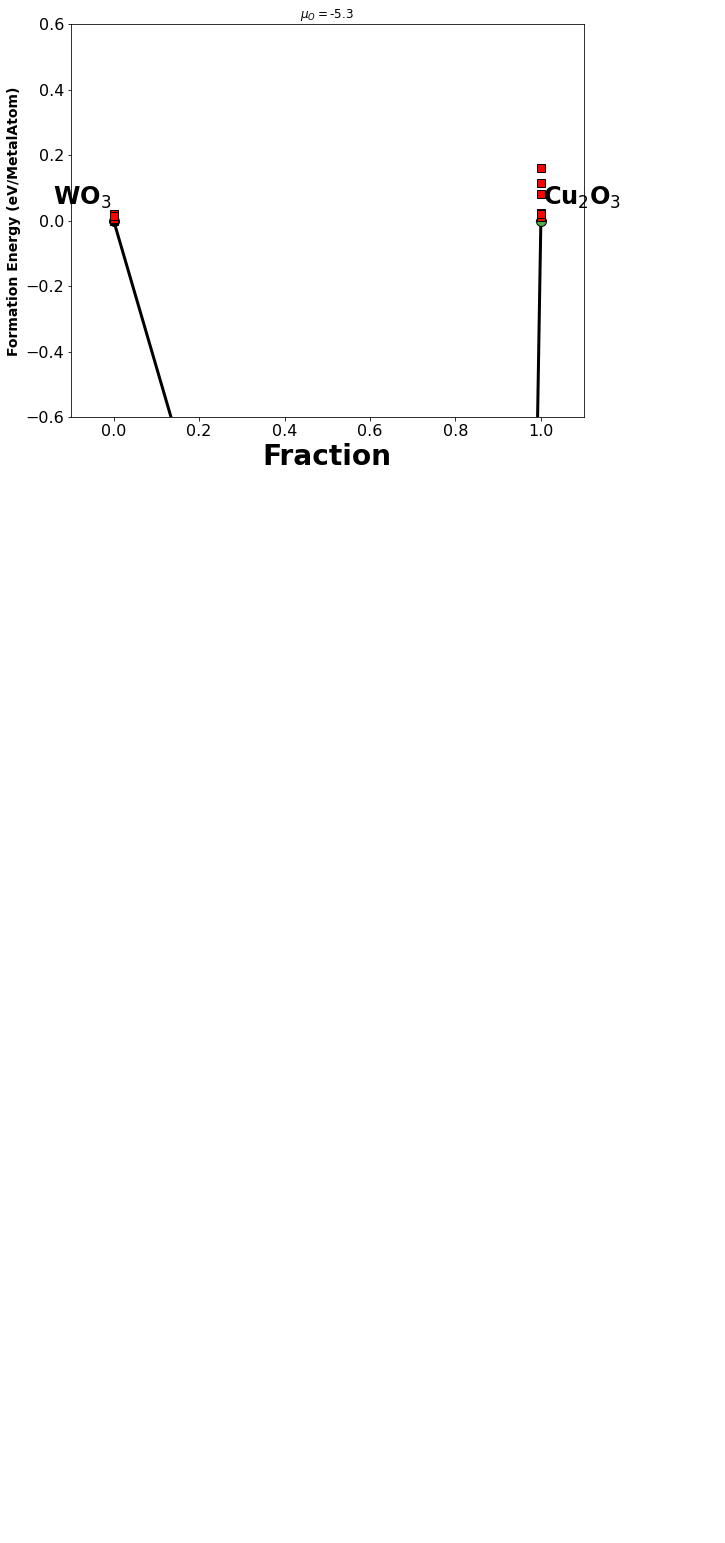

defaultdict(None, {'0.05': array([[0.36838707, 0.39241666, 0.41690646, 0.44139625, 0.46588605,
        0.49268974, 0.51975741, 0.54682507, 0.57389274, 0.60096041,
        0.62802808]]), '0.1': array([[0.25250673, 0.27199449, 0.29240265, 0.31281082, 0.33321898,
        0.35825493, 0.38381884, 0.40938275, 0.43494666, 0.46051057,
        0.48607447]]), '0.15': array([[0.15115227, 0.1660982 , 0.18242473, 0.19875126, 0.21507779,
        0.23834599, 0.26240614, 0.28646629, 0.31052644, 0.33458659,
        0.35864675]]), '0.2': array([[0.07244724, 0.08285134, 0.09509624, 0.10734114, 0.11958603,
        0.14108649, 0.16364289, 0.18619928, 0.20875567, 0.23131206,
        0.25386845]]), '0.25': array([[0.0217886 , 0.02765087, 0.03581414, 0.0439774 , 0.05214067,
        0.07187339, 0.09292602, 0.11397865, 0.13503128, 0.15608391,
        0.17713655]]), '0.3': array([[5.07530526e-16, 1.32043560e-03, 5.40206825e-03, 9.48370091e-03,
        1.35653336e-02, 3.15303112e-02, 5.10791834e-02, 7.06280556e-0

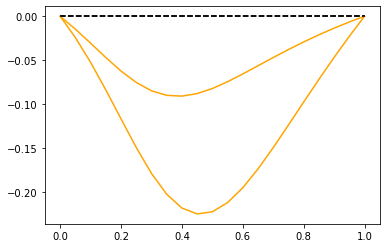

Mo0.05W0.95O2.50
Mo0.10W0.90O2.50
Mo0.15W0.85O2.50
Mo0.20W0.80O2.50
Mo0.25W0.75O2.50
Mo0.30W0.70O2.50
Mo0.35W0.65O2.50
Mo0.40W0.60O2.50
Mo0.45W0.55O2.50
Mo0.50W0.50O2.50
Mo0.55W0.45O2.50
Mo0.60W0.40O2.50
Mo0.65W0.35O2.50
Mo0.70W0.30O2.50
Mo0.75W0.25O2.50
Mo0.80W0.20O2.50
Mo0.85W0.15O2.50
Mo0.90W0.10O2.50
Mo0.95W0.05O2.50


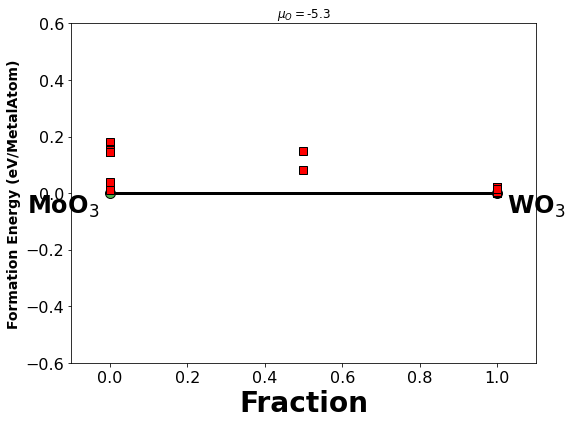

entry.name
MoWO6(s)
entry.name
entry.name
MoWO6(s)
entry.name
Pourbaix Entry : Mo2 W2 O12 with energy = 1.0276, npH = -24.0, nPhi = -24.0, nH2O = 12.0, entry_id = mvc-5033 
[[0.03764746 0.03764746 0.03764746 0.03764746 0.03764746 0.03764746
  0.03764746 0.03764746 0.03764746 0.03764746 0.03764746]]
Pourbaix Entry : Mo1 W1 O6 with energy = 0.3788, npH = -12.0, nPhi = -12.0, nH2O = 6.0, entry_id = mvc-5693 
[[0.02077375 0.02077375 0.02077375 0.02077375 0.02077375 0.02077375
  0.02077375 0.02077375 0.02077375 0.02077375 0.02077375]]
defaultdict(None, {'0.05': array([[0.45295565, 0.48152708, 0.51009851, 0.53866994, 0.56724137,
        0.5958128 , 0.62438423, 0.65295565, 0.68152708, 0.71009851,
        0.73866994]]), '0.1': array([[0.41163478, 0.44020621, 0.46877764, 0.49734907, 0.5259205 ,
        0.55449192, 0.58306335, 0.61163478, 0.64020621, 0.66877764,
        0.69734907]]), '0.15': array([[0.36719359, 0.39576502, 0.42433645, 0.45290788, 0.48147931,
        0.51005073, 0.53862216, 0.56

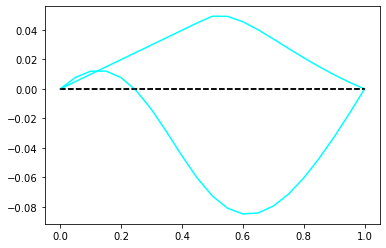

Nb0.05W0.95O2.50
Nb0.10W0.90O2.50
Nb0.15W0.85O2.50
Nb0.20W0.80O2.50
Nb0.25W0.75O2.50
Nb0.30W0.70O2.50
Nb0.35W0.65O2.50
Nb0.40W0.60O2.50
Nb0.45W0.55O2.50
Nb0.50W0.50O2.50
Nb0.55W0.45O2.50
Nb0.60W0.40O2.50
Nb0.65W0.35O2.50
Nb0.70W0.30O2.50
Nb0.75W0.25O2.50
Nb0.80W0.20O2.50
Nb0.85W0.15O2.50
Nb0.90W0.10O2.50
Nb0.95W0.05O2.50


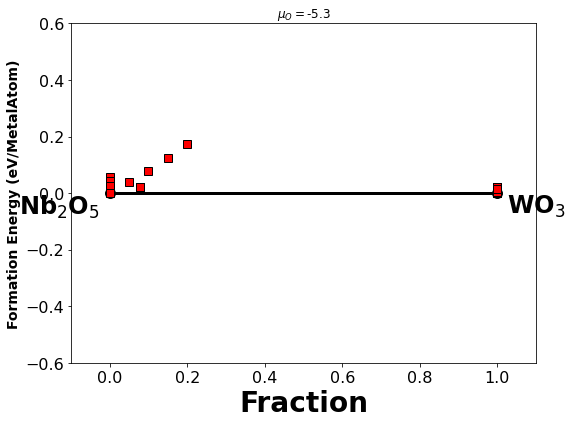

defaultdict(None, {'0.05': array([[0.47186755, 0.49901041, 0.52615326, 0.55329612, 0.58043898,
        0.60758183, 0.63472469, 0.66186755, 0.68901041, 0.71615326,
        0.74329612]]), '0.1': array([[0.45333731, 0.4790516 , 0.50476589, 0.53048017, 0.55619446,
        0.58190874, 0.60762303, 0.63333731, 0.6590516 , 0.68476589,
        0.71048017]]), '0.15': array([[0.43203176, 0.45631747, 0.48060319, 0.5048889 , 0.52917461,
        0.55346033, 0.57774604, 0.60203176, 0.62631747, 0.65060319,
        0.6748889 ]]), '0.2': array([[0.404085  , 0.42694214, 0.44979929, 0.47265643, 0.49551357,
        0.51837072, 0.54122786, 0.564085  , 0.58694214, 0.60979929,
        0.63265643]]), '0.25': array([[0.37167353, 0.3931021 , 0.41453068, 0.43595925, 0.45738782,
        0.47881639, 0.50024496, 0.52167353, 0.5431021 , 0.56453068,
        0.58595925]]), '0.3': array([[0.33543698, 0.35543698, 0.37543698, 0.39543698, 0.41543698,
        0.43543698, 0.45543698, 0.47543698, 0.49543698, 0.51543698,
     

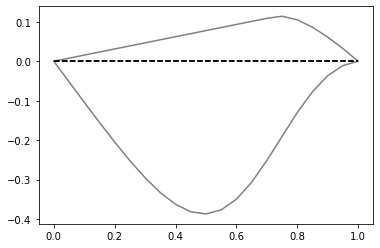

Ti0.05Mo0.95O2.50
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5.0
Ti0.10Mo0.90O2.50
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5.0
Ti0.15Mo0.85O2.50
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5.0
Ti0.20Mo0.80O2.50
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5.0
Ti0.25Mo0.75O2.50
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5.0
Ti0.30Mo0.70O2.50
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5.0
Ti0.35Mo0.65O2.50
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5.0
Ti0.40Mo0.60O2.50
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5.0
Ti0.45Mo0.55O2.50
Making synthetic formation energy, since MP doesn't have data for Ti in ox state: 5.0
Ti0.50Mo0.50O2.50
Making synthetic formation energy, since MP do

In [ ]:
potential_hosts = ['Ag', 'Ge', 'Bi', 'Co', 'Ir', 'Nb', 'Pb', 'Pd', 'Pt', 'Rh',
                  'Ru', 'Sb', 'Si', 'Sn', 'Ta', 'Te', 'Ti', 'Tl', 'W']
# hosts that could be MO2
potential_hosts = ['Ir', 'Co', 'Pb', 'Pd', 'Pt', 'Rh',
                  'Ru', 'Sb', 'Si', 'Sn', 'Ta', 'Te', 'Ti', 'Tl', 'W']

#potential_hosts = [ 'Ta', 'Te', 'Ti', 'Tl', 'W']
#potential_hosts = ['Ir',]
largest_stabilisation = defaultdict()
differences = defaultdict()
#quadratic_equations_ox['Sb'] = oqmd_quadratic_equations_ox['Sb']

seen_combos = []
acid_stability = defaultdict()
of_interest_entries = defaultdict(list)
on_hull_only = defaultdict(list)
acid_stable_only = defaultdict(list)
acid_stable = defaultdict(list)

p_stabilisers = ['Li', 'Na', 'K', 'Rb', 'Cs', 'Mg', 'Y', 'Sc', 'Ba', 'Zn', 'Ca',
                 'La', 'Ce', 'Pr', 'Nd', 'Sm', 'Eu', 'Tb', 'Er', 'Tm', 'Yb']

potential_hosts =['Nb', 'Sb', 'Ta', 'W', 'Mo', ]

if ox_state==6:
    # just take linear part, has weird curvature
    quadratic_equations_ox['W'][0] =0

#quadratic_equations_ox['Sb'] = oqmd_quadratic_equations_ox['Sb']


for housing_element in potential_hosts:#['W']:#potential_hosts:
    
    if (housing_element not in quadratic_equations_ox.keys() or housing_element not in quadratic_equations_red.keys()):
        print("Missing eq for {}".format(housing_element))    
        continue
    
    pairings = []
    ground_states =  []
    concs = np.linspace(0, 1.00, 21)

    for ele in d2metals['3']+['Mo', 'Nb', 'W',]:#+p_stabilisers:
        #if ele2mp_3[ele] is None:
        #    continue
        if housing_element+ele in seen_combos or ele+housing_element in seen_combos:
            print('already seen {},{}'.format(housing_element, ele))
            continue
        if ele==housing_element:# or ele in d2metals['3']+['Mo', 'Nb', 'W']:
            continue

        else: 
#             pred_1, pred_2, ox_1, ox_2 = formation_energy_mixing(quadratic_equations_ox[ele], oqmd_quadratic_equations_red[housing_element],
#                                                                   quadratic_equations_ox[housing_element], quadratic_equations_red[ele], concs, plotting=False)
            pred_1, pred_2, ox_1, ox_2 = formation_energy_mixing(ele, housing_element,
                                                                 concs, plotting=False)
        print(ele, housing_element)
        can_reduce = True
        can_oxidise = True
        # check if it found any solutions 
        if sum(ox_1)==0:
            can_reduce = False
        if sum(ox_2)==0:
            can_oxidise = False 
            
        if can_reduce:
            plt.plot(concs, pred_1, label="B={}".format(ele), color=ele2col[ele])
            plt.plot([concs[0], concs[-1]], [0, 0], 'k--')
        if can_oxidise:
            plt.plot(concs, pred_2, label="B={}".format(ele), ls='-', color=ele2col[ele])#, 'r-')
            plt.plot([concs[0], concs[-1]], [0, 0], 'k--')
        plt.show()
        indices = np.round(np.linspace(len(concs)/10, len(concs)*9/10, 9)).astype(int)
        pairs, info_dict = get_binary_mp_data(housing_element, ele, 5)
        if len(info_dict)>0:
            for key in info_dict:
                plt.plot(info_dict[key][0], info_dict[key][1], 'o', color=ele2col[key.split("_")[0]])
                closest_idx = find_nearest(concs, info_dict[key][0])
                if ele<housing_element and min(pred_2[closest_idx], pred_1[closest_idx])<0:
                    #print("Difference for {},{} = {:.3f} eV/atom".format(housing_element, ele, info_dict[key][1]-min(pred_2[closest_idx], pred_1[closest_idx])))
                    differences[ele+housing_element] = (concs[closest_idx], min(pred_2[closest_idx], pred_1[closest_idx]))
                elif min(pred_2[closest_idx], pred_1[closest_idx])<0:
                    #print("Difference for {},{} = {:.3f} eV/atom".format(housing_element, ele, info_dict[key][1]-min(pred_2[closest_idx], pred_1[closest_idx])))
                    differences[housing_element+ele] = (concs[closest_idx], min(pred_2[closest_idx], pred_1[closest_idx]))
        if min(pred_2)<min(pred_1) and min(pred_2)<0:
            if ele<housing_element:
                largest_stabilisation[ele+housing_element] = (np.min(pred_2), np.argmin(pred_2))
            else:
                largest_stabilisation[housing_element+ele] = (np.min(pred_2), np.argmin(pred_2))
        if min(pred_1)<min(pred_2) and min(pred_1)<0:
            if ele<housing_element:
                largest_stabilisation[ele+housing_element] = (np.min(pred_1), np.argmin(pred_1))
            else:
                largest_stabilisation[housing_element+ele] = (np.min(pred_1), np.argmin(pred_1))
                
        mp_entries, mp_labels = load_data(ele, housing_element)
        synth_entries = []
        for idx, conc in enumerate(concs):
            if conc==0 or conc==1:
                continue
            corr = min(pred_1[idx], pred_2[idx])
            if pred_1[idx]<pred_2[idx]:
                entry_, label_ = make_synthetic_mp(corr, ele, housing_element, conc, 5./7)
                synth_entries.append(entry_)
            else:
                entry_, label_ = make_synthetic_mp(corr, ele, housing_element, conc, 5./7)
                synth_entries.append(entry_)            
            
        fig = plt.figure()
        # RuO2 goes to RuO4 at -5.716, -5.3 ~ 1.23 V applied potential
        mu_o = -5.3
        open_elements_specific = {Element("O"):mu_o}
        gcpd = GrandPotentialPhaseDiagram(mp_entries+synth_entries, open_elements_specific)

        plotter = PDPlotter(gcpd, backend='matplotlib', show_unstable=0.2)
        plotter.get_plot(label_stable=True, label_unstable=False, plt=plt)
        plt.ylim(-0.6, 0.6)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.ylabel('Formation Energy (eV/MetalAtom)', fontsize=14)
        plt.title(r'$\mu_O = ${0}'.format(mu_o))
        plt.tight_layout()
        plt.show()
        # this retrieves the energies for our entries
        our_entries = [e for e in gcpd.all_entries if '0.' in e.name]
        hull_energies = [gcpd.get_e_above_hull(e) for e in our_entries]
        
        synth_pbx_entries = make_pbx_entries(synth_entries)
        def_entries = mpr.get_pourbaix_entries([ele, housing_element])
        acid_energies, considered_compositions = get_synthetic_pourbaix_energies(def_entries, synth_pbx_entries, ele, housing_element)
        print(acid_energies)
        print(synth_pbx_entries)
        acid_stability[ele+housing_element] = (acid_energies, considered_compositions)
        min_dist2hull = min(hull_energies)
        min_index = np.argmin(hull_energies)
        for idx, hull_e in enumerate(hull_energies):
            # the key we use for acid_stability dictionary is the concentration excluding 0 and 1, so need to 
            # add one from the index since there isnt a 0
            concentration_key = str(round(concs[idx+1], 2))
            #if hull_e==0 and isinstance(hull_e, int) and min(acid_stability[ele+housing_element][0][concentration_key][0][:4])<0.05:
            
            if hull_e==0 and min(acid_stability[ele+housing_element][0][concentration_key][0])<0.2 and min(pred_1[idx+1], pred_2[idx+1])<0:
                print("*******OF INTEREST*******")
                print(our_entries[idx])
                print(hull_e)
                print(acid_stability[ele+housing_element][0][concentration_key][0])
                print("*******OF INTEREST*******\n")
                #of_interest_entries[ele+housing_element].append(our_entries[idx])
                #acid_stable[ele+housing_element+str(concentration_key)] = acid_energies[concentration_key]


            if min(acid_stability[ele+housing_element][0][concentration_key][0])<0.05:

                acid_stability[ele+housing_element+str(concentration_key)] = acid_energies[concentration_key]
        
        #seen_combos.append(housing_element+ele)


        
